# **Forecast Pipeline**

## **1. Setup**

This initial section prepares the Python environment by importing all the necessary libraries for the forecasting pipeline and defining a custom function for a key performance metri

*   **Core Libraries**: It starts by importing `numpy` for numerical operations and `pandas` for data manipulation and analysis, which are fundamental for handling the weather dataset.
*   **Standard Utilities**: Libraries like `warnings` (to suppress unnecessary warnings and keep the output clean), `os` (for interacting with the operating system), and `re` (for regular expressions) are included for general-purpose tasks.
*   **Visualization**: `matplotlib` and `seaborn` are imported for creating static, animated, and interactive visualizations, which are essential for data exploration and result analysis.
*   **Statistical Analysis**: `statsmodels` is used for statistical tests and plotting functions like the Autocorrelation Function (ACF) plot, which is vital for time series analysis. `scipy` is included for scientific and technical computing.
*   **Machine Learning Models**: A wide range of regression models are imported from popular libraries:
    *   `scikit-learn`: `SGDRegressor`, `RandomForestRegressor`, and `StackingRegressor`.
    *   `xgboost`: `XGBRegressor` and `XGBClassifier`, known for their high performance.
    *   `lightgbm`: `LGBMRegressor`, another powerful gradient-boosting framework.
*   **Model Evaluation & Preprocessing**:
    *   From `scikit-learn`, various metrics like `mean_squared_error` and `r2_score` are imported to evaluate model performance. `MinMaxScaler` is used for feature scaling.
    *   `TimeSeriesSplit` is specifically included for cross-validation on time series data, which respects the temporal order of observations.
*   **Hyperparameter Tuning**: `optuna` is imported for efficient hyperparameter optimization, helping to find the best settings for the models.
*   **Model Explainability**: `shap` is included to help explain the output of the machine learning models, providing insights into which features are most important for the predictions.
*   **Custom Metric**: A function `rmse` (Root Mean Squared Error) is defined. This is a standard metric for regression tasks that measures the average magnitude of the errors, giving more weight to larger errors.

In [80]:
# 1. Setup & Imports
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import re
import os

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import shap
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    mean_absolute_percentage_error,
    make_scorer,
    mean_squared_error,
    root_mean_squared_error,
    mean_absolute_error,
    r2_score
)
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.feature_selection import mutual_info_regression

from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor

import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner
from sklearn.ensemble import StackingRegressor


In [81]:
def rmse(y, yhat):
    return np.sqrt(mean_squared_error(y, yhat))

## **2. Load local weather data**

This section loads the historical hourly weather data from a local Excel file and performs an initial inspection to understand its structure and identify any missing values. This is the first step in the data preprocessing pipeline.

### **2.1. Data Loading and Initial Data Preview**

*   **Data Loading**: The code uses the `pd.read_excel()` function from the pandas library to read the weather data from a file named `"HCMWeatherHourly.xlsx"`. This dataset is loaded into a pandas DataFrame called `df`, which is a powerful and flexible data structure for handling tabular data.

*   **Initial Data Preview**: Immediately after loading, `df.head(24)` is called. This command displays the first 24 rows of the DataFrame. Since the data is recorded hourly, this provides a convenient snapshot of the full 24-hour cycle for the first day in the dataset. This allows for a quick visual check of the column names (`name`, `datetime`, `temp`, etc.), the format of the data in each column, and confirms that the file was read correctly.

In [ ]:
df = pd.read_excel("HCMWeatherHourly.xlsx")
df.head(24)

,name,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
0,"10.82, 106.67",2015-01-01T00:00:00,24.9,24.9,19.0,69.35,0.0,0,NaN,0.0,...,1012.0,50.0,7.0,0.0,0.0,0.0,NaN,Partially cloudy,partly-cloudy-night,"48900099999,VVTS"
1,"10.82, 106.67",2015-01-01T01:00:00,24.9,24.9,20.0,73.79,0.0,0,NaN,0.0,...,1012.0,50.0,7.0,0.0,0.0,0.0,NaN,Partially cloudy,partly-cloudy-night,"48894099999,48900099999,VVTS"
2,"10.82, 106.67",2015-01-01T02:00:00,24.0,24.0,20.0,78.35,0.0,0,NaN,0.0,...,1012.0,50.0,7.0,0.0,0.0,0.0,NaN,Partially cloudy,partly-cloudy-night,"48900099999,VVTS"
3,"10.82, 106.67",2015-01-01T03:00:00,24.0,24.0,20.0,78.35,0.0,0,NaN,0.0,...,1012.0,50.0,6.0,0.0,0.0,0.0,NaN,Partially cloudy,partly-cloudy-night,"48900099999,VVTS"
4,"10.82, 106.67",2015-01-01T04:00:00,24.0,24.0,20.9,83.33,0.0,0,NaN,0.0,...,1012.0,50.0,6.0,0.0,0.0,0.0,NaN,Partially cloudy,partly-cloudy-night,"48894099999,48900099999,VVTS"
5,"10.82, 106.67",2015-01-01T05:00:00,24.0,24.0,19.9,78.35,0.0,0,NaN,0.0,...,1012.0,50.0,6.0,0.0,0.0,0.0,NaN,Partially cloudy,partly-cloudy-night,"48900099999,VVTS"
6,"10.82, 106.67",2015-01-01T06:00:00,23.0,23.0,17.9,73.45,0.0,0,NaN,0.0,...,1013.0,50.0,6.0,0.0,0.0,0.0,NaN,Partially cloudy,partly-cloudy-night,"48900099999,VVTS"
7,"10.82, 106.67",2015-01-01T07:00:00,23.0,23.0,17.0,68.96,0.0,0,NaN,0.0,...,1013.0,88.0,8.0,38.0,0.1,0.0,NaN,Partially cloudy,partly-cloudy-day,"48894099999,48900099999,VVTS"
8,"10.82, 106.67",2015-01-01T08:00:00,24.0,24.0,17.0,64.92,0.0,0,NaN,0.0,...,1015.0,88.0,8.0,226.0,0.8,2.0,NaN,Partially cloudy,partly-cloudy-day,"48900099999,VVTS"
9,"10.82, 106.67",2015-01-01T09:00:00,26.0,26.0,18.0,61.38,0.0,0,NaN,0.0,...,1014.0,25.0,8.0,436.7,1.6,4.0,NaN,Partially cloudy,partly-cloudy-day,"48900099999,VVTS"


### **2.2. Missing Value Assessment**

*   **Missing Value Assessment**: The `df.isnull().sum()` command is then executed to perform a crucial data quality check.
    *   It systematically scans each column in the DataFrame and returns a count of the total number of missing or null (`NaN`) values within that column.
    *   This step is fundamental in any data science project, as it reveals the completeness of the dataset. Machine learning models typically cannot handle missing values, so identifying them is the first step toward deciding on a strategy for cleaning the data.
    *   The output shows that several columns like **`preciptype`** and **`severerisk`** have a very high number of missing values (81767 and 61603, respectively), suggesting they may not be reliable for modeling. Other columns like `precip` and `visibility` have a much smaller number of missing entries, which will need to be addressed in the next cleaning stage. Many other columns have no missing data at all.

In [121]:
df.isnull().sum()

name                    0
datetime                0
temp                    0
feelslike               0
dew                     0
humidity                0
precip                 39
precipprob              0
preciptype          81767
snow                   42
snowdepth              42
windgust               49
windspeed               0
winddir                10
sealevelpressure        0
cloudcover              0
visibility            198
solarradiation         36
solarenergy            36
uvindex                36
severerisk          61603
conditions              0
icon                    0
stations                0
dtype: int64

## **3. Basic cleaning and encoding**

This section focuses on essential data preprocessing tasks. It involves converting data types, removing irrelevant or problematic columns, creating new, more useful features from existing ones (feature engineering), and standardizing units of measurement to ensure the data is clean, consistent, and ready for modeling.

### **3.1. Data Type Conversion and Column Removal**

*   **Data Type Conversion**:
    *   The first step is to convert the `datetime` column from a generic object (string) into a proper `datetime` format using `pd.to_datetime()`. This is a critical step for any time series analysis, as it enables the extraction of time-based components (like hour, day, month) and allows the data to be sorted chronologically.

*   **Column Removal**:
    *   Several columns are dropped from the DataFrame using `df.drop()`. The decision to remove these columns is based on several factors:
        *   **High Missing Values**: The `severerisk` column, which had over 61,000 missing entries, is removed as it is too sparse to be reliable.
        *   **Irrelevance**: Columns like `snow` and `snowdepth` are irrelevant for a tropical climate like Ho Chi Minh City.
        *   **Redundancy or Low Utility**: Columns such as `name`, `stations`, and `icon` likely contain metadata that is either constant or not useful for predicting temperature. The `conditions` column, which contains text descriptions, is also removed to avoid the complexity of natural language processing.

In [83]:
df['datetime'] = pd.to_datetime(df['datetime'])

df.drop(columns = ['name','snow','snowdepth','conditions','icon','stations','severerisk'], inplace = True)

In [84]:
df.head(24)

,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex
0,2015-01-01 00:00:00,24.9,24.9,19.0,69.35,0.0,0,NaN,9.4,3.6,240.0,1012.0,50.0,7.0,0.0,0.0,0.0
1,2015-01-01 01:00:00,24.9,24.9,20.0,73.79,0.0,0,NaN,9.0,3.6,290.0,1012.0,50.0,7.0,0.0,0.0,0.0
2,2015-01-01 02:00:00,24.0,24.0,20.0,78.35,0.0,0,NaN,6.5,5.4,320.0,1012.0,50.0,7.0,0.0,0.0,0.0
3,2015-01-01 03:00:00,24.0,24.0,20.0,78.35,0.0,0,NaN,6.8,5.4,330.0,1012.0,50.0,6.0,0.0,0.0,0.0
4,2015-01-01 04:00:00,24.0,24.0,20.9,83.33,0.0,0,NaN,9.0,5.4,340.0,1012.0,50.0,6.0,0.0,0.0,0.0
5,2015-01-01 05:00:00,24.0,24.0,19.9,78.35,0.0,0,NaN,10.1,9.4,330.0,1012.0,50.0,6.0,0.0,0.0,0.0
6,2015-01-01 06:00:00,23.0,23.0,17.9,73.45,0.0,0,NaN,10.8,7.6,10.0,1013.0,50.0,6.0,0.0,0.0,0.0
7,2015-01-01 07:00:00,23.0,23.0,17.0,68.96,0.0,0,NaN,13.7,9.4,360.0,1013.0,88.0,8.0,38.0,0.1,0.0
8,2015-01-01 08:00:00,24.0,24.0,17.0,64.92,0.0,0,NaN,19.1,13.0,30.0,1015.0,88.0,8.0,226.0,0.8,2.0
9,2015-01-01 09:00:00,26.0,26.0,18.0,61.38,0.0,0,NaN,20.2,7.6,30.0,1014.0,25.0,8.0,436.7,1.6,4.0


### **3.2. One-Hot Encoding for Precipitation Type**

*   **One-Hot Encoding for Precipitation Type**:
    *   The `preciptype` column originally contained text describing the type of precipitation (e.g., "rain") but also had a significant number of missing values (over 81,000).
    *   To handle this, a new binary feature called `has_rain` is created. This process, a form of one-hot encoding, checks if the word "rain" is present in the `preciptype` entry for each row.
    *   The result is a simple and robust feature where `1` indicates it rained and `0` indicates it did not or the data was missing. After creating this new feature, the original `preciptype` column is dropped to avoid redundancy.

In [85]:
# --- One-hot encode preciptype to has_rain (rain=1, NaN/others=0)
df['has_rain'] = (
    df['preciptype']
    .fillna('')          # handle NaN safely
    .str.lower()         # normalize capitalization
    .str.contains('rain')
    .astype(int)         # True → 1, False → 0
)

# Optional: drop the original column
df.drop(columns=['preciptype'], inplace=True)

### **3.3. Unit Conversion and Standardization"**

*   **Unit Conversion and Standardization**:
    *   The script then standardizes the units of measurement for consistency, which is crucial for the model to interpret the features correctly.
        *   **Precipitation**: Converted from inches to millimeters (mm) by multiplying by `25.4`.
        *   **Percentage to Fraction**: Features like `humidity`, `cloudcover`, and `precipprob` are converted from percentages (0-100) to fractional values (0-1) by dividing by `100.0`.
        *   **Wind Speed**: Converted from miles per hour (mph) to meters per second (m/s) by dividing by `2.237`.
        *   **Visibility**: Converted from miles (mi) to kilometers (km) by multiplying by `1.609`.
        *   **Solar Energy**: The `solarenergy` feature, measured in MJ/m²/day, is converted to an equivalent in Watts per square meter (W/m²) by multiplying by `11.6`. This creates a new column `solarenergy_wm2eq` to represent solar energy in a more standard unit of power flux.

In [86]:
# Quy đổi các đơn vị đo lường
# Precipitation (in → mm)
df['precip'] = df['precip'] * 25.4

# Percentage-based to fraction
pct_cols = ['humidity','cloudcover','precipprob']
df[pct_cols] = df[pct_cols] / 100.0

# Wind (mph → m/s)
wind_cols = ['windspeed','windgust']
df[wind_cols] = df[wind_cols] / 2.237

# Visibility (mi → km)
df['visibility'] = df['visibility'] * 1.609

# Convert MJ/m²/day → W/m²-equivalent
df['solarenergy_wm2eq'] = df['solarenergy'] * 11.6


In [87]:
df

,datetime,temp,feelslike,dew,humidity,precip,precipprob,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,has_rain,solarenergy_wm2eq
0,2015-01-01 00:00:00,24.9,24.9,19.0,0.6935,0.00,0.0,4.202056,1.609298,240.0,1012.0,0.50,11.263,0.0,0.0,0.0,0,0.00
1,2015-01-01 01:00:00,24.9,24.9,20.0,0.7379,0.00,0.0,4.023245,1.609298,290.0,1012.0,0.50,11.263,0.0,0.0,0.0,0,0.00
2,2015-01-01 02:00:00,24.0,24.0,20.0,0.7835,0.00,0.0,2.905677,2.413947,320.0,1012.0,0.50,11.263,0.0,0.0,0.0,0,0.00
3,2015-01-01 03:00:00,24.0,24.0,20.0,0.7835,0.00,0.0,3.039785,2.413947,330.0,1012.0,0.50,9.654,0.0,0.0,0.0,0,0.00
4,2015-01-01 04:00:00,24.0,24.0,20.9,0.8333,0.00,0.0,4.023245,2.413947,340.0,1012.0,0.50,9.654,0.0,0.0,0.0,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94429,2025-10-09 13:00:00,33.0,39.1,24.0,0.5926,12.70,1.0,4.023245,3.397407,290.0,1008.0,0.50,16.090,836.0,3.0,8.0,1,34.80
94430,2025-10-09 14:00:00,31.0,36.4,24.0,0.6637,2.54,1.0,3.844435,7.420653,200.0,1007.0,0.88,12.872,541.0,1.9,5.0,1,22.04
94431,2025-10-09 15:00:00,28.0,31.8,24.0,0.7891,2.54,1.0,3.844435,8.225302,250.0,1007.0,0.88,16.090,344.0,1.2,3.0,1,13.92
94432,2025-10-09 16:00:00,30.0,35.0,24.0,0.7028,2.54,1.0,6.437193,3.397407,250.0,1006.0,0.88,16.090,204.0,0.7,2.0,1,8.12


In [88]:
df.columns

Index(['datetime', 'temp', 'feelslike', 'dew', 'humidity', 'precip',
       'precipprob', 'windgust', 'windspeed', 'winddir', 'sealevelpressure',
       'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex',
       'has_rain', 'solarenergy_wm2eq'],
      dtype='object')

## **4. Physics‑based feature engineering**

This section focuses on creating new, physically meaningful features from the existing data. The goal is to explicitly represent meteorological concepts and cyclical patterns, making it easier for the machine learning model to understand the underlying physics that drive temperature changes.

*   **1. Radiation Efficiency**:
    *   A new feature, `radiation_efficiency`, is created to model how effectively solar radiation penetrates the atmosphere and reaches the surface.
    *   **Rationale**: The amount of solar energy is a primary driver of temperature, but its effect is reduced (attenuated) by cloud cover. This feature combines `solarradiation` and `solarenergy` to create a robust proxy for incoming solar power and then divides it by a term related to `cloudcover`. A high value indicates strong solar radiation with clear skies, while a low value suggests that clouds are blocking the incoming energy.

*   **2. Moisture Ratio**:
    *   The `dew_humidity_ratio` is engineered by dividing the dew point (`dew`) by the humidity (`humidity`).
    *   **Rationale**: This ratio provides a measure of air moisture saturation. When the dew point temperature is close to the actual air temperature, the relative humidity is high. This feature captures that relationship. To prevent "division by zero" errors in cases where humidity is `0`, the code temporarily replaces these zeros with `NaN` (Not a Number) and then fills any resulting `NaN` values in the final ratio with `0`.

*   **3. Wind Vector Components**:
    *   The `winddir` (wind direction) and `windspeed` are used to create two new features: `wind_u` (the east-west component) and `wind_v` (the north-south component).
    *   **Rationale**: Wind direction is a cyclical feature (e.g., 359° is very close to 1°), which is difficult for machine learning models to interpret as a single number. By decomposing the wind into its U and V vector components using sine and cosine, this cyclical relationship is preserved in a way that models can easily understand.
    *   **De-biasing**: The mean is then subtracted from both the `wind_u` and `wind_v` components. This centers the wind data around zero, which helps stabilize the model's learning process and improves the reliability of feature importance analyses (like SHAP) later on.

*   **4. Hourly Convective Potential (Storminess)**:
    *   Two features are created to estimate the potential for convective storms: `convective_potential` and `storminess`.
    *   `convective_potential`: This feature combines `humidity`, `solarradiation`, and `windgust`. The logic is that convective storms are more likely to form when there is high humidity (moisture), high solar radiation (energy to lift the air), and gusty winds (atmospheric instability).
    *   `storminess`: This is a simpler, alternative metric calculated from `windspeed` squared (representing wind energy) and the probability of precipitation (`precipprob`).

*   **5. Seasonality (Annual and Diurnal)**:
    *   This part of the code encodes the cyclical nature of time, both for the day and the year.
    *   **Annual Cycle**: The `dayofyear` is extracted and then transformed into `doy_sin` and `doy_cos` components. This allows the model to understand that the end of the year is close to the beginning of the next year.
    *   **Diurnal Cycle**: Similarly, the `hour` of the day is converted into `hour_sin` and `hour_cos` to represent the 24-hour daily cycle, ensuring the model knows that hour 23 is close to hour 0.
    *   **Daylight Mask**: A simple binary feature, `is_daylight`, is created. It is set to `1` if `solarradiation` is greater than zero and `0` otherwise. This explicitly tells the model whether it is daytime or nighttime, a fundamental factor for temperature prediction.

In [89]:
# ============================================================================
# 🌡️ PHYSICS-BASED FEATURES — HOURLY VERSION (Leakage-Free, Stable)
# ============================================================================

# ---------------------------------------------------------------------------
# 0️⃣ Basic safety setup
# ---------------------------------------------------------------------------
df = df.sort_values("datetime").reset_index(drop=True)

# ---------------------------------------------------------------------------
# 1️⃣ Radiation Efficiency (hourly solar → cloud attenuation)
# ---------------------------------------------------------------------------
# Better physical formulation:
# Clear-sky radiation proxy ~ (solarenergy OR solarradiation)
# Cloudcover attenuates radiation linearly (approx.)
df['radiation_efficiency'] = (
    (df['solarradiation'] + 0.1 * df['solarenergy'])
    / (1 + df['cloudcover'] / 100.0)
).fillna(0)

# ---------------------------------------------------------------------------
# 2️⃣ Moisture ratio — dew point relative to humidity
# ---------------------------------------------------------------------------
# Avoid division spikes when humidity ~ 0
df['dew_humidity_ratio'] = df['dew'] / (df['humidity'].replace(0, np.nan))
df['dew_humidity_ratio'] = df['dew_humidity_ratio'].fillna(0)

# ---------------------------------------------------------------------------
# 3️⃣ Wind Vector Components (u, v) — hourly wind representation
# ---------------------------------------------------------------------------
df['wind_u'] = df['windspeed'] * np.cos(np.deg2rad(df['winddir']))
df['wind_v'] = df['windspeed'] * np.sin(np.deg2rad(df['winddir']))

# De-bias (stabilizes SHAP + avoids mean offset leakage)
df['wind_u'] -= df['wind_u'].mean()
df['wind_v'] -= df['wind_v'].mean()

# ---------------------------------------------------------------------------
# 4️⃣ Hourly Convective Potential (storminess)
# ---------------------------------------------------------------------------
# More meteorologically meaningful:
#   convective storms → high humidity + high radiation + gusty winds
df['convective_potential'] = (
    df['humidity'].clip(lower=0) *
    df['solarradiation'].clip(lower=0) *
    (df['windgust'] + 1)
)

# Earlier version relied only on wind² * precipprob, which is weaker.
df['storminess'] = (df['windspeed'] ** 2) * (df['precipprob'] / 100)

# ---------------------------------------------------------------------------
# 5️⃣ Seasonality (annual + diurnal)
# ---------------------------------------------------------------------------

# A. Annual seasonal cycle (day-of-year)
df['dayofyear'] = df['datetime'].dt.dayofyear
df['doy_sin'] = np.sin(2 * np.pi * df['dayofyear'] / 365.25)
df['doy_cos'] = np.cos(2 * np.pi * df['dayofyear'] / 365.25)

# B. Hour-of-day (diurnal heating cycle)
df['hour'] = df['datetime'].dt.hour
df['hour_sin']  = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos']  = np.cos(2 * np.pi * df['hour'] / 24)

# C. Whether solar radiation should be >0 (sunlight mask)
df['is_daylight'] = (df['solarradiation'] > 0).astype(int)


In [ ]:
df.head(5)

,datetime,temp,feelslike,dew,humidity,precip,precipprob,windgust,windspeed,winddir,...,wind_v,convective_potential,storminess,dayofyear,doy_sin,doy_cos,hour,hour_sin,hour_cos,is_daylight
0,2015-01-01 00:00:00,24.9,24.9,19.0,0.6935,0.0,0.0,4.202056,1.609298,240.0,...,-0.864997,0.0,0.0,1,0.017202,0.999852,0,0.000000,1.000000,0
1,2015-01-01 01:00:00,24.9,24.9,20.0,0.7379,0.0,0.0,4.023245,1.609298,290.0,...,-0.983550,0.0,0.0,1,0.017202,0.999852,1,0.258819,0.965926,0
2,2015-01-01 02:00:00,24.0,24.0,20.0,0.7835,0.0,0.0,2.905677,2.413947,320.0,...,-1.022959,0.0,0.0,1,0.017202,0.999852,2,0.500000,0.866025,0
3,2015-01-01 03:00:00,24.0,24.0,20.0,0.7835,0.0,0.0,3.039785,2.413947,330.0,...,-0.678278,0.0,0.0,1,0.017202,0.999852,3,0.707107,0.707107,0
4,2015-01-01 04:00:00,24.0,24.0,20.9,0.8333,0.0,0.0,4.023245,2.413947,340.0,...,-0.296923,0.0,0.0,1,0.017202,0.999852,4,0.866025,0.500000,0


## **5. Features engineering**

This section creates a comprehensive set of advanced features by building upon the previous physics-based concepts and introducing time-series specific techniques like rolling window statistics, gradients, and climate indicators. This is the most critical feature engineering step, designed to give the model a deep understanding of both recent trends and long-term climate patterns.

### **5.1. Hourly Feature Engineering**


*   **0. Physics-Based Base Features**:
    *   This part re-implements the core physics-based features from the previous section. This ensures all necessary base features are present before creating more complex ones that depend on them. It includes the calculation of `radiation_efficiency`, `dew_humidity_ratio`, wind vectors (`wind_u`, `wind_v`), `convective_potential`, `storminess`, and seasonality (`doy_sin`, `hour_sin`, etc.).

*   **1. Rolling / Lag Features (Windows: 24h, 168h, 336h)**:
    *   This is a classic time series technique where statistics are calculated over a moving "window" of past data. It allows the model to see recent history and trends.
    *   **Rolling Wind Statistics**: The code calculates the `mean` and `variance` of the `wind_u` and `wind_v` components over 168-hour (7-day) and 336-hour (14-day) windows. This provides the model with insights into the prevailing wind patterns and their stability over the past one to two weeks.

*   **2. Pressure & Humidity Gradients**:
    *   Gradients measure the rate of change of a variable, which is a powerful predictor in time series forecasting.
    *   **Hourly Changes**: The code uses `.diff(1)` to calculate the change in `sealevelpressure`, `humidity`, and `dew` point from the previous hour. A rapid drop in pressure, for example, can be a strong indicator of an impending storm.
    *   **Rolling Statistics on Gradients**: It then calculates the `mean` and `variance` of pressure and humidity over 24-hour and 168-hour windows to capture the average trend and volatility of these key meteorological variables.

*   **3. Climate & Regime Indicators**:
    *   These features are designed to capture the broader climate context beyond just the immediate weather.
    *   **Seasonal Indicators**: `is_wet_season` is a binary flag based on the month, and `season_progress` indicates how far into the wet/dry season the current date is.
    *   **Soil Moisture**: `soil_wetness_index` is a sophisticated feature that models moisture retention in the ground. It calculates the total rainfall over the past 14 days (336 hours) and uses a negative exponential function to estimate soil saturation. Wetter soil can significantly impact local temperature and humidity.
    *   **Monsoon Logic**: Based on the direction of the north-south wind (`wind_v`), the code creates flags to identify the Southwest (`sw_monsoon_flag`) and Northeast (`ne_monsoon_flag`) monsoon periods, which are dominant climate drivers in the region.

*   **4. Rain Type Classification**:
    *   This part aims to classify precipitation type using the available data, creating more nuanced rain features.
    *   **Rain Ratios**: Features like `precip_cloud_ratio` and `precip_efficiency` are engineered to characterize the nature of the rainfall (e.g., light rain from heavy clouds vs. heavy rain with low humidity).
    *   **Convective vs. Stratiform Rain**: A rule-based system is implemented to classify rain as either `is_convective_rain` (intense, stormy rain) or `is_stratiform_rain` (steady, less intense rain). This is based on whether precipitation, wind gust, and humidity are above their median values.

*   **5. Advanced Physical Coherence Features**:
    *   These features capture the dynamic interplay between different weather variables over time.
    *   `wind_dir_consistency`: Measures how stable the wind direction has been over 24 and 168 hours.
    *   **Covariances**: It calculates the 24-hour rolling `covariance` for several physically related pairs of variables (e.g., `humidity` and `solarradiation`). This tells the model how these variables have been trending together in the recent past.
    *   **Mean Wind Direction**: A robust 24-hour mean wind direction is calculated by averaging the U and V components, which correctly handles the circular nature of wind direction data.

*   **6. Cleanup**:
    *   **Handling Missing Values**: All the rolling window calculations produce `NaN` (Not a Number) values at the beginning of the dataset where a full window of past data is not available. The `df.fillna(0)` command fills these missing values with zero.
    *   **Preventing Data Leakage**: The `.iloc[max(windows):]` command is a crucial final step. It removes all rows from the beginning of the DataFrame that do not have a complete 336-hour (14-day) look-back window. This ensures that every row used for training has a full set of valid, calculated features, preventing the model from learning on incomplete data.
    *   The `print` statements at the end confirm that the feature engineering is complete and report the new total number of features, which has grown to 76.

In [91]:
# ============================================================================
# 🌡️ HOURLY FEATURE ENGINEERING (NO TEMP LEAKAGE, WINDOWS 1–14 DAYS)
# ============================================================================

df = df.sort_values("datetime").reset_index(drop=True)

# ===============================================================
# 0️⃣ PHYSICS-BASED BASE FEATURES
# ===============================================================

# --- Radiation efficiency (solar vs cloud attenuation) ---
df['radiation_efficiency'] = (
    (df['solarradiation'] + 0.05 * df['solarenergy'])
    / (df['cloudcover'] + 1e-3)
).fillna(0)

# --- Moisture ratio ---
df['dew_humidity_ratio'] = (df['dew'] / df['humidity'].replace(0, np.nan)).fillna(0)

# --- Wind vectors ---
df['wind_u'] = df['windspeed'] * np.cos(np.deg2rad(df['winddir']))
df['wind_v'] = df['windspeed'] * np.sin(np.deg2rad(df['winddir']))

# Center for SHAP clarity
df['wind_u'] -= df['wind_u'].mean()
df['wind_v'] -= df['wind_v'].mean()

# --- Convective potential ---
df['convective_potential'] = (
    df['humidity'].clip(lower=0) *
    df['solarradiation'].clip(lower=0) *
    (df['windgust'] + 1)
)

df['storminess'] = (df['windspeed']**2) * (df['precipprob'] / 100)

# --- Seasonality ---
df['dayofyear'] = df['datetime'].dt.dayofyear
df['doy_sin'] = np.sin(2*np.pi*df['dayofyear']/365.25)
df['doy_cos'] = np.cos(2*np.pi*df['dayofyear']/365.25)

df['hour'] = df['datetime'].dt.hour
df['hour_sin'] = np.sin(2*np.pi*df['hour']/24)
df['hour_cos'] = np.cos(2*np.pi*df['hour']/24)
df['is_daylight'] = (df['solarradiation'] > 0).astype(int)

# ===============================================================
# 1️⃣ ROLLING / LAGS — WINDOWS: 24h, 168h, 336h
# ===============================================================

windows = [24, 168, 336]    # 1 day, 7 days, 14 days

# Rolling wind statistics
for w in [168, 336]:
    df[f'wind_u_mean_w{w}h'] = df['wind_u'].rolling(w, 1).mean()
    df[f'wind_v_mean_w{w}h'] = df['wind_v'].rolling(w, 1).mean()
    df[f'wind_u_var_w{w}h']  = df['wind_u'].rolling(w, 1).var()
    df[f'wind_v_var_w{w}h']  = df['wind_v'].rolling(w, 1).var()

# ===============================================================
# 2️⃣ PRESSURE & HUMIDITY GRADIENTS — HOURLY
# ===============================================================

df['pressure_change_1h'] = df['sealevelpressure'].diff(1)
df['humidity_change_1h'] = df['humidity'].diff(1)
df['dew_change_1h']      = df['dew'].diff(1)

for w in [24, 168]:
    df[f'pressure_mean_w{w}h'] = df['sealevelpressure'].rolling(w,1).mean()
    df[f'pressure_var_w{w}h']  = df['sealevelpressure'].rolling(w,1).var()
    df[f'humidity_mean_w{w}h'] = df['humidity'].rolling(w,1).mean()
    df[f'humidity_var_w{w}h']  = df['humidity'].rolling(w,1).var()

# ===============================================================
# 3️⃣ CLIMATE & REGIME INDICATORS
# ===============================================================

m = df['datetime'].dt.month
df['is_wet_season'] = m.isin([5,6,7,8,9,10]).astype(int)

df['season_progress'] = np.where(
    m < 5, 0,
    np.where(m > 10, 1, (m - 5) / 5)
)

# Soil moisture over last 14 days (336 hours)
wet336 = df['precip'].rolling(336,1).sum()
df['soil_wetness_index'] = 1 - np.exp(-0.05 * wet336)

# Monsoon logic
df['sw_monsoon_flag'] = (df['wind_v'] > 0).astype(int)
df['ne_monsoon_flag'] = (df['wind_v'] < 0).astype(int)
df['wind_monsoon_index'] = df['wind_u'] + df['wind_v']
df['wind_monsoon_weighted'] = df['wind_monsoon_index'] * df['doy_sin']

# ===============================================================
# 4️⃣ RAIN TYPE CLASSIFICATION (NO PRECIPCOVER)
# ===============================================================

df['precip_intensity'] = df['precip']
df['precip_cloud_ratio'] = df['precip'] / (df['cloudcover'] + 1e-3)
df['precip_efficiency']  = df['precip'] / (df['humidity'] + 1e-3)

med_intensity = df['precip'].median()
med_gust      = df['windgust'].median()

df['is_convective_rain'] = (
    (df['precip'] > med_intensity) &
    (df['windgust'] > med_gust) &
    (df['humidity'] > 60)
).astype(int)

df['is_stratiform_rain'] = (
    (df['precip'] > 0) &
    (df['is_convective_rain'] == 0)
).astype(int)

df['convective_prev'] = df['is_convective_rain'].shift(1).fillna(0)

# ===============================================================
# 5️⃣ ADVANCED PHYSICAL COHERENCE FEATURES
# ===============================================================

u, v = df['wind_u'], df['wind_v']

df['wind_dir_consistency_w24h'] = (
    np.sqrt(u.rolling(24,1).mean()**2 + v.rolling(24,1).mean()**2)
    / (df['windspeed'].rolling(24,1).mean() + 1e-3)
)

df['wind_dir_consistency_w168h'] = (
    np.sqrt(u.rolling(168,1).mean()**2 + v.rolling(168,1).mean()**2)
    / (df['windspeed'].rolling(168,1).mean() + 1e-3)
)

df['wind_pressure_coupling'] = df['windspeed'] * (
    df['sealevelpressure'].rolling(3,1).mean() -
    df['sealevelpressure'].rolling(12,1).mean()
)

df['humid_radiation_balance'] = (
    df['humidity'].rolling(3,1).mean() *
    df['solarradiation'].rolling(3,1).mean()
)

df['humid_radiation_ratio'] = df['humidity'] / (df['solarradiation'] + 1e-3)

# 24h covariances
pairs = [
    ('humidity','solarradiation'),
    ('wind_u','wind_v'),
    ('humidity','precip'),
    ('sealevelpressure','windspeed')
]
for a,b in pairs:
    df[f'{a}_{b}_cov24h'] = df[a].rolling(24,1).cov(df[b])

# Wind direction (24h)
mean_u_24 = df['wind_u'].rolling(24,1).mean()
mean_v_24 = df['wind_v'].rolling(24,1).mean()

df['mean_wind_dir_w24h'] = np.degrees(np.arctan2(mean_v_24, mean_u_24)) % 360
df['mean_wind_dir_w24h_rad'] = np.deg2rad(df['mean_wind_dir_w24h'])
df['mean_wind_dir_w24h_sin'] = np.sin(df['mean_wind_dir_w24h_rad'])
df['mean_wind_dir_w24h_cos'] = np.cos(df['mean_wind_dir_w24h_rad'])

# ===============================================================
# 6️⃣ CLEANUP
# ===============================================================
df = df.fillna(0).iloc[max(windows):].reset_index(drop=True)

print("Hourly feature engineering complete (24–336h windows).")
print("Total feature count:", len(df.columns))


Hourly feature engineering complete (24–336h windows).
Total feature count: 76


### **5.2. Exponentially Weighted Moving Average (EWMA) Smoothing**

This section applies Exponentially Weighted Moving Average (EWMA) smoothing to a selection of key features. This is a sophisticated time-series technique used to create smoothed versions of features that capture underlying trends while reducing short-term noise.

*   **Feature Selection**: A specific list of important numerical features (`ewma_features`) is defined, including `humidity`, `dew`, `solarradiation`, `sealevelpressure`, `windspeed`, and `precip`. These are core meteorological variables that are likely to have meaningful trends over time.

*   **Configuration of Smoothing Levels**: A dictionary named `ewma_configs` is created to define three different smoothing levels, each with a different "memory":
    *   **Short Memory (72h)**: An alpha of `0.10` gives more weight to recent data, creating a smoothed feature that closely tracks recent changes over approximately the last 3 days.
    *   **Medium Memory (168h)**: An alpha of `0.05` provides a more balanced view, smoothing the data over roughly the past week (7 days).
    *   **Long Memory (336h)**: An alpha of `0.02` gives more weight to older data, capturing the long-term trend over approximately the last 14 days.

*   **Application of EWMA**: The code iterates through each selected feature and applies each of the three EWMA configurations to it.
    *   For each combination, it calculates the exponentially weighted moving average using the `.ewm()` method in pandas. The `adjust=False` argument is used to ensure that the weights are calculated recursively, giving more emphasis to recent observations in a consistent manner.
    *   This process generates 18 new features in total (6 original features × 3 smoothing levels). Each new feature is named descriptively, such as `humidity_ewma_72h`, making it clear which feature and which smoothing window it represents.

*   **Purpose and Benefit**: Unlike a simple moving average that weighs all past points equally, an EWMA gives exponentially more weight to recent data points. This makes it more responsive to recent changes while still providing a smoothed trend. By creating features with short, medium, and long-term memories, the model is given a multi-scale view of the trends in the data, which can significantly improve its predictive power. The "Leakage-Safe" comment in the code indicates that this operation is performed without using future information, making it safe for training a forecasting model.

In [92]:
# ===============================================================
# 🌡️ EWMA Smoothing for HOURLY Data (Leakage-Safe)
# ===============================================================

ewma_features = [
    'humidity', 'dew', 'solarradiation',
    'sealevelpressure', 'windspeed', 'precip'
]

# Adjusted EWMA α values for hourly resolution
ewma_configs = {
    '72h': 0.10,     # short memory (~3 days)
    '168h': 0.05,    # medium memory (~7 days)
    '336h': 0.02     # long memory (~14 days)
}

for col in ewma_features:
    for tag, alpha in ewma_configs.items():
        df[f'{col}_ewma_{tag}'] = df[col].ewm(alpha=alpha, adjust=False).mean()

print("EWMA (hourly) features added to df.")


EWMA (hourly) features added to df.


## **7. Target and Split**

### **7.1. Target Definition + Final Train / Test Split**

*   **1. Define Prediction Target**:
    *   The goal of this pipeline is to forecast the temperature for the *next* hour. To create the target variable (`target`), the `temp` column is shifted backward by one time step using `.shift(-1)`.
    *   This means that for each row (representing a specific hour `t`), the `target` column will contain the temperature from the next hour (`t+1`). This setup frames the problem as a supervised learning task where the model will learn to predict the future temperature based on the current hour's features.

*   **2. Handle Missing Target Value**:
    *   The `shift(-1)` operation naturally creates a missing value (`NaN`) in the very last row of the DataFrame, as there is no subsequent hour's temperature to fill it with.
    *   The `df.dropna(subset=['target'])` command removes this last row, ensuring that every row in the dataset has a valid target value.

*   **3. Chronological Train/Test Split**:
    *   For time series forecasting, it is essential to split the data chronologically to prevent "data leakage" (i.e., using future information to train the model).
    *   The data is split into a training set (the first 80% of the data) and a testing set (the final 20%). This ensures that the model is trained exclusively on past data and then evaluated on unseen future data, simulating a real-world forecasting scenario.

*   **4. Separate Features and Target**:
    *   The columns that will be used as input for the model (`feature_cols`) are separated from the columns that should not be used for training.
    *   **Excluded Columns**:
        *   `datetime`: This is used for sorting and splitting but is not a direct input feature (its components, like hour and day of the year, have already been engineered).
        *   `target`: This is the value the model is trying to predict, so it cannot be an input.
        *   `temp`: The original temperature column is also removed. Since the `target` is just a shifted version of `temp`, keeping it would make the problem trivial and lead to perfect but useless predictions (a form of data leakage).
    *   The remaining columns are assigned to `X_train` and `X_test` (the features), while the `target` column is assigned to `y_train` and `y_test` (the labels).

*   **5. Verify Split Integrity**:
    *   Finally, the code prints out the shapes and date ranges of the training and testing sets. This is a crucial verification step to confirm:
        *   The number of features and samples in each set.
        *   That the training period strictly precedes the testing period, confirming that the chronological split was successful and there is no overlap.

In [93]:
# ===============================================================
#  STAGE 7 : TARGET DEFINITION + FINAL TRAIN / TEST SPLIT
# ===============================================================

# 1️⃣  Define the prediction target (hourly forecasting)
# Next-hour temperature (shift by -1 hour)
df['target'] = df['temp'].shift(-1)

# Drop the last row (target unavailable)
df = df.dropna(subset=['target']).reset_index(drop=True)

# 2️⃣  Chronological Train/Test split (80% train, 20% test)
split_idx = int(len(df) * 0.8)
train = df.iloc[:split_idx].copy()
test  = df.iloc[split_idx:].copy()

# 3️⃣  Separate features and target
exclude_cols = ['datetime', 'target', 'temp']  # temp removed to avoid trivial learning
feature_cols = [c for c in df.columns if c not in exclude_cols]

X_train, y_train = train[feature_cols], train['target']
X_test,  y_test  = test[feature_cols],  test['target']

# 4️⃣  Verify split integrity
print("✅ Target defined and chronological Train/Test split complete.")
print(f"Train shape: {X_train.shape} | Test shape: {X_test.shape}")
print(f"Feature count: {len(feature_cols)}")
print(f"Train period: {train['datetime'].min()} → {train['datetime'].max()}")
print(f"Test period : {test['datetime'].min()} → {test['datetime'].max()}")


✅ Target defined and chronological Train/Test split complete.
Train shape: (75277, 92) | Test shape: (18820, 92)
Feature count: 92
Train period: 2015-01-15 00:00:00 → 2023-08-17 12:00:00
Test period : 2023-08-17 13:00:00 → 2025-10-09 16:00:00


### **Feature Group Inspection**

*   **Group Definition**: A list of `groups` is defined, where each item is a string keyword (e.g., `'wind'`, `'precip'`, `'radiation'`). These keywords represent the core physical or conceptual categories that the engineered features fall into.

*   **Iterative Grouping and Printing**: The code iterates through each defined `group` keyword. For each keyword:
    *   It searches through all the column names in the DataFrame.
    *   It creates a list (`cols`) of all column names that contain the current keyword (e.g., for the keyword `'wind'`, it finds columns like `windspeed`, `wind_gust`, `wind_u_mean_w168h`, etc.).
    *   If any features are found for that group, it prints a formatted header that includes the group name in uppercase and the total count of features in that group (e.g., `WIND (27 features)`).
    *   Finally, it lists all the feature names belonging to that group.

*   **Purpose and Outcome**: The primary purpose of this code is to provide a clean, human-readable summary of the 95 features that now exist in the dataset. This helps to:
    *   **Verify** that the feature engineering steps ran as expected.
    *   **Organize** the complex feature space into logical, domain-specific categories.
    *   **Facilitate** understanding of what types of information the model will have access to (e.g., how many features relate to wind vs. humidity).
    *   Serve as a reference for the subsequent feature selection and model interpretation stages.

In [94]:
# ==============================================================
# FEATURE GROUP INSPECTION – prints all feature names by keyword
# ==============================================================

groups = [
    'wind', 'precip', 'humidity', 'radiation', 'pressure',
    'dew', 'cloud', 'visibility', 'season', 'soil', 'regime',
    'energy', 'storm', 'rain', 'monsoon', 'dir', 'change',
    'index', 'flux', 'balance', 'ratio', 'consistency'
]

print(f"\nTotal features: {len(df.columns)}")

for g in groups:
    cols = [c for c in df.columns if g in c]
    if len(cols) > 0:
        print(f"\n{'='*80}\n {g.upper()} ({len(cols)} features)")
        for c in cols:
            print("   ", c)



Total features: 95

 WIND (27 features)
    windgust
    windspeed
    winddir
    wind_u
    wind_v
    wind_u_mean_w168h
    wind_v_mean_w168h
    wind_u_var_w168h
    wind_v_var_w168h
    wind_u_mean_w336h
    wind_v_mean_w336h
    wind_u_var_w336h
    wind_v_var_w336h
    wind_monsoon_index
    wind_monsoon_weighted
    wind_dir_consistency_w24h
    wind_dir_consistency_w168h
    wind_pressure_coupling
    wind_u_wind_v_cov24h
    sealevelpressure_windspeed_cov24h
    mean_wind_dir_w24h
    mean_wind_dir_w24h_rad
    mean_wind_dir_w24h_sin
    mean_wind_dir_w24h_cos
    windspeed_ewma_72h
    windspeed_ewma_168h
    windspeed_ewma_336h

 PRECIP (9 features)
    precip
    precipprob
    precip_intensity
    precip_cloud_ratio
    precip_efficiency
    humidity_precip_cov24h
    precip_ewma_72h
    precip_ewma_168h
    precip_ewma_336h

 HUMIDITY (12 features)
    humidity
    dew_humidity_ratio
    humidity_change_1h
    humidity_mean_w24h
    humidity_var_w24h
    humidity_mean_w

## **8. Baseline models**

This section defines and implements a "climatology" baseline model. A baseline model is a simple, common-sense model that provides a benchmark for performance. Any sophisticated machine learning model developed later must outperform this baseline to be considered effective and justify its complexity.

*   **The Climatology Concept**:
    *   In meteorology, "climatology" refers to the long-term average weather conditions for a particular location and time. This model formalizes that idea: the predicted temperature for any given hour is simply the historical average temperature for that same day of the year and hour of the day, calculated over all available years in the training data.
    *   For example, to predict the temperature for January 15th at 3 PM, the model calculates the average of all temperatures recorded on every January 15th at 3 PM in the training dataset.

*   **Implementation Details**:
    *   **Feature Extraction**: The function first extracts the `dayofyear` (1-366) and `hour` (0-23) from the datetime column for both the training and testing sets.
    *   **Building the Climatology Table**:
        *   The core of the model is a "climatology table" (`climo_table`), which is created by grouping the **training data** by both `dayofyear` and `hour`.
        *   For each unique `(day, hour)` combination, it calculates the `mean()` of the `target` temperature.
        *   This result is stored in a Python dictionary where the keys are `(day, hour)` tuples and the values are the corresponding average temperatures. This table essentially becomes the "memory" of the model.
    *   **Global Fallback**: A single global mean temperature (`gmean`) is also calculated across the entire training set. This serves as a fallback prediction for any `(day, hour)` combination in the test set that might not have been present in the training data (e.g., a leap day).
    *   **Prediction**: The function then iterates through each row of the **test set**. For each row, it looks up the `(day, hour)` key in the `climo_table`. If a match is found, it uses the stored average temperature as the prediction. If no match is found, it uses the global fallback mean. The final predictions are returned as a NumPy array.

In [ ]:
def climatology_pred_hourly(train_frame, test_frame, target_col='target', date_col='datetime'):
    """
    Hourly climatology baseline:
    mean temperature for (day-of-year, hour-of-day).
    """
    # Ensure datetime
    train_frame[date_col] = pd.to_datetime(train_frame[date_col])
    test_frame[date_col]  = pd.to_datetime(test_frame[date_col])

    # Extract DOY and hour
    train_frame['doy']  = train_frame[date_col].dt.dayofyear
    train_frame['hour'] = train_frame[date_col].dt.hour

    test_frame['doy']  = test_frame[date_col].dt.dayofyear
    test_frame['hour'] = test_frame[date_col].dt.hour

    # Build climatology table
    climo_table = (
        train_frame
        .groupby(['doy', 'hour'])[target_col]
        .mean()
        .to_dict()
    )

    # Global fallback mean
    gmean = train_frame[target_col].mean()

    # Predict test
    preds = []
    for d, h in zip(test_frame['doy'], test_frame['hour']):
        preds.append(climo_table.get((d, h), gmean))

    return np.array(preds)

## **8. Feature selection and XGBoost training**

### **8.1. Multi-Stage Feature Selection Pipeline**

This large code cell executes a sophisticated, multi-stage pipeline to intelligently reduce the feature set from 95 to a small, powerful, and diverse subset. This entire process is performed using **only the training data** to prevent any information from the test set from "leaking" into the selection process.

*   **Stage 0: Remove Temperature-Leaking Predictors**:
    *   It begins by explicitly removing any features that are direct derivatives or proxies of the target temperature, such as `feelslike`. This is a crucial step to prevent data leakage and ensure the model learns from genuinely predictive information, not from a disguised version of the answer.

*   **Stage 1: Mutual Information (MI) Filtering**:
    *   It calculates the Mutual Information score between each remaining feature and the target variable (`y_train`). MI is a powerful metric that captures any kind of relationship (not just linear).
    *   Only the top 15% of features (with a minimum of 20) with the highest MI scores are kept. This acts as a first-pass filter to eliminate the least relevant features and reduce noise.

*   **Stage 2: Redundancy Pruning (Remove Highly Correlated Features)**:
    *   A correlation matrix is created for the features that survived the MI filter.
    *   The code then identifies and removes any feature that has a correlation greater than 0.92 with another feature. This step eliminates redundant information (multicollinearity), which makes the model more stable and its feature importances easier to interpret.

*   **Stage 3: Train a Temporary XGBoost Model for Importance Ranking**:
    *   A temporary XGBoost model is trained on the now-reduced feature set. This model's purpose is not final prediction, but to generate a reliable ranking of feature importance. The `max_depth` is fixed to prevent the model from becoming too complex and inflating the importance of irrelevant features.

*   **Stage 4: Family-Aware Selection**:
    *   This is a custom logic designed to ensure feature diversity. It groups features by their "family" (prefix, e.g., 'humidity', 'dew', 'hour').
    *   It then ranks these families based on the average importance of their features.
    *   It iterates through the most important families, selecting up to 5 of the top features from each, until a hard cap of 80 total features is reached. This prevents the final feature set from being dominated by a single type of feature (e.g., ten different variations of humidity) and ensures a more balanced model.

*   **Stage 5: Retrain Lightweight XGBoost on Final Selected Features**:
    *   Finally, the temporary XGBoost model is retrained one last time on only the final set of features selected by the family-aware logic. The output confirms that this entire process has successfully reduced the feature count from over 90 down to just **12**.

In [96]:
# ============================================================================
# 1️⃣  Robust Feature Selection (Leakage-Safe, Overfit-Reduced)
# ============================================================================

import numpy as np
import pandas as pd
import re
from sklearn.feature_selection import mutual_info_regression
from xgboost import XGBRegressor

# =========================================================
# 0️⃣  Remove temperature-leaking predictors
# =========================================================
drop_cols = [
    'feelslike', 'feelslikemax', 'feelslikemin',
    'tempmax', 'tempmin'
]
X_train = X_train.drop(columns=[c for c in drop_cols if c in X_train.columns], errors='ignore')
X_test  = X_test.drop(columns=[c for c in drop_cols if c in X_test.columns],  errors='ignore')

# =========================================================
# 1️⃣  Mutual Information (MI) — fit only on TRAIN
# =========================================================
mi = mutual_info_regression(X_train, y_train, random_state=42)
mi_s = pd.Series(mi, index=X_train.columns).sort_values(ascending=False)

# Use only top 15%  to reduce noise
top_k = max(20, int(0.15 * len(mi_s)))
top_feats = mi_s.head(top_k).index

X_train_fs = X_train[top_feats]
X_test_fs  = X_test[top_feats]

print(f"🔍 MI stage → kept top {top_k} features")

# =========================================================
# 2️⃣  Remove Highly Correlated Features (redundancy pruning)
# =========================================================
corr = X_train_fs.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Drop any feature correlated >0.92 with another
to_drop_corr = [col for col in upper.columns if any(upper[col] > 0.92)]

X_train_fs = X_train_fs.drop(columns=to_drop_corr)
X_test_fs  = X_test_fs.drop(columns=to_drop_corr)

print(f"🔧 Correlation pruning removed {len(to_drop_corr)} redundant features")

# =========================================================
# 3️⃣  Stable XGB for family-based ranking (controlled depth!)
# =========================================================
# WHY: deep trees inflate noise in feature importance → overfitting risk
xgb_temp = XGBRegressor(
    n_estimators=250,
    learning_rate=0.05,
    max_depth=6,           # FIXED: prevent overfitting on hourly wiggles
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=3,
    reg_alpha=0.5,
    min_child_weight=5,
    random_state=42,
    n_jobs=-1,
    eval_metric='rmse'
)
xgb_temp.fit(X_train_fs, y_train)

# Compute importances
imp = pd.Series(
    xgb_temp.feature_importances_,
    index=X_train_fs.columns
).sort_values(ascending=False)

# =========================================================
# 4️⃣  Family-aware selection (max 3 features per family)
# =========================================================

def base(c):
    """Extract prefix family (before first underscore)."""
    m = re.match(r'([A-Za-z0-9]+)_', c)
    return m.group(1) if m else c

# Whitelist prefixes that make physical sense
VALID_PREFIXES = [
    'humidity','dew','solarradiation','sealevelpressure',
    'windspeed','wind','wind_u','wind_v','pressure','storminess',
    'radiation','cloud','hour','doy','convective','soil','precip'
]

# compute mean importance per family
grp = imp.groupby(imp.index.map(base)).mean().sort_values(ascending=False)

selected = []
for fam in grp.index:
    if fam not in VALID_PREFIXES:
        continue
    fam_feats = imp[imp.index.map(base) == fam].index
    selected.extend(fam_feats[:5])  # max 3 per family
    if len(selected) >= 80:         # hard cap
        break

sel = selected

X_train_sel = X_train_fs[sel]
X_test_sel  = X_test_fs[sel]

print(f"🎯 Final selected features: {len(sel)}")

# =========================================================
# 5️⃣  Retrain lightweight XGB on selected features
# =========================================================
xgb_temp.fit(X_train_sel, y_train)
print("✅ Final lightweight XGB trained on optimized features")


🔍 MI stage → kept top 20 features
🔧 Correlation pruning removed 6 redundant features
🎯 Final selected features: 12
✅ Final lightweight XGB trained on optimized features


### **8.2. Inspecting and Visualizing Feature Importance**

This cell visualizes the results from the feature selection process, providing a clear and intuitive understanding of which features and feature families were deemed most important by the temporary XGBoost model.

*   **Final Selected Feature Families**: It first prints a ranked list of the most important "feature families" (like `dew`, `humid`, `hour`) along with their average importance scores. This gives a high-level view of which physical concepts are most predictive.
*   **Detailed Selected Features**: It then lists the exact **12 features** that were chosen by the selection algorithm. This is the final, optimized feature set that will be used for further modeling.
*   **Feature Importance Visualization**: A horizontal bar chart is generated to visually represent the importance of the top 15 selected features. This plot makes it immediately obvious which features have the most influence on the model's predictions, with `dew_humidity_ratio` and `hour` standing out as the most dominant predictors.


=== Final Selected Feature Families (Top 15) ===
dew               0.4104
humid             0.3473
hour              0.0464
radiation         0.0231
solarradiation    0.0157
humidity          0.0102
windgust          0.0041
convective        0.0039
dtype: float32

=== Detailed Selected Features (Total: 12 ) ===
 1. dew_humidity_ratio
 2. hour
 3. hour_sin
 4. hour_cos
 5. radiation_efficiency
 6. solarradiation
 7. solarradiation_ewma_72h
 8. humidity
 9. humidity_mean_w24h
10. humidity_solarradiation_cov24h
11. humidity_change_1h
12. convective_potential


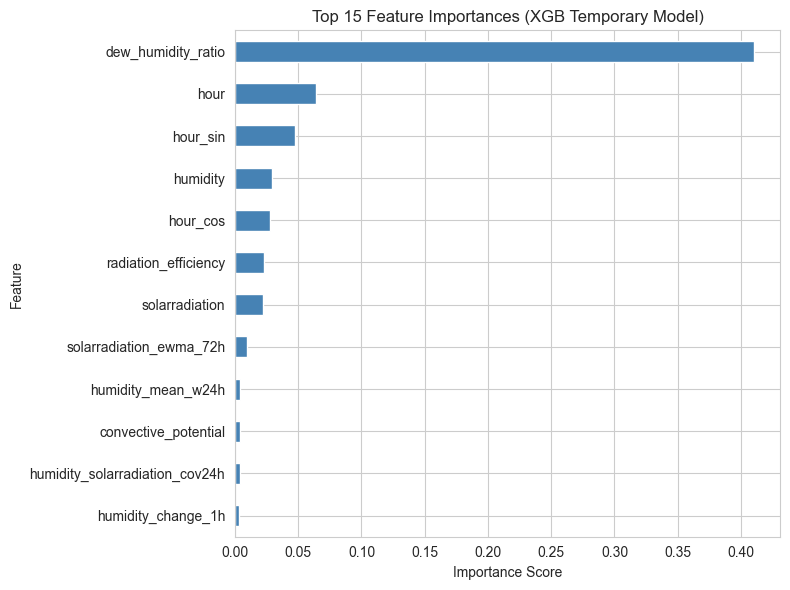

In [97]:
print("\n=== Final Selected Feature Families (Top 15) ===")
print(grp.head(15).round(4))

print("\n=== Detailed Selected Features (Total:", len(sel), ") ===")
for i, feat in enumerate(sel, 1):
    print(f"{i:2d}. {feat}")

# Optional: visualize feature importance for quick intuition
plt.figure(figsize=(8,6))
imp[sel].sort_values(ascending=True).tail(15).plot.barh(color='steelblue')
plt.title("Top 15 Feature Importances (XGB Temporary Model)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


### **8.3. Flagging Extreme Weather Events**

This cell prepares the data for more advanced modeling by identifying and flagging "extreme" temperature days. This is a preliminary step for potentially training a specialized model to handle these more difficult and impactful events.

*   **Define Extreme Thresholds from Training Data**: It calculates the 5th and 95th percentile temperature values from the **training set target (`y_train`) only**. These values (24.00 and 34.00) serve as the lower and upper thresholds for what will be considered an "extreme" temperature. Using only the training data for this is critical to avoid data leakage.
*   **Apply Thresholds to Both Sets**: The code then iterates through both the `train` and `test` DataFrames and creates a new boolean column called `is_extreme_target`. This column is `True` if the `target` temperature is either below the 5th percentile or above the 95th percentile.
*   **Convert to NumPy and Verify**: The new boolean flags are converted into NumPy arrays for faster access later. The code concludes by printing the total count of extreme samples found in both the training (3592) and test (925) sets, confirming the step was successful.

In [98]:
# =========================================================
#  STEP: Flag Extreme Target Days (Train/Test)
# =========================================================
# Define "extreme" days using only the TRAIN distribution — avoids test leakage
low_q, high_q = y_train.quantile([0.05, 0.95])

# Apply the same thresholds to both train and test sets
for df_ in [train, test]:
    df_['is_extreme_target'] = (
        (df_['target'] < low_q) | (df_['target'] > high_q)
    )

# Convert to numpy arrays for quick use later
is_extreme_train = train['is_extreme_target'].to_numpy()
is_extreme_test  = test['is_extreme_target'].to_numpy()

print(f" Extreme thresholds (5th, 95th): {low_q:.2f}, {high_q:.2f}")
print(f"Extreme samples → Train: {is_extreme_train.sum()} | Test: {is_extreme_test.sum()}")


 Extreme thresholds (5th, 95th): 24.00, 34.00
Extreme samples → Train: 3592 | Test: 925


### **8.4. SHAP Analysis for Model Explanation**

This part uses the powerful SHAP (SHapley Additive exPlanations) library to deeply explain the behavior of the temporary XGBoost model and validate the importance of the 12 selected features.

*   **SHAP Value Calculation**: A `shap.TreeExplainer` is used to compute the SHAP values for every prediction made on the test set. Each SHAP value represents the impact of a specific feature on a single prediction, indicating how much that feature pushed the prediction up or down.
*   **Global SHAP Importance (Beeswarm Plot)**: The first plot generated is a SHAP summary plot (often called a "beeswarm" plot). Each dot is a single prediction.
    *   **Feature Ranking**: Features are ranked by importance from top to bottom.
    *   **Impact on Prediction**: The x-axis shows the SHAP value—positive values mean the feature pushed the prediction higher (hotter), and negative values mean it pushed it lower (colder).
    *   **Feature Value**: The color indicates the original value of the feature, from low (blue) to high (red). This plot reveals not just *what* is important, but *how* it is important (e.g., high `dew_humidity_ratio` leads to much higher temperature predictions).
*   **Mean Absolute SHAP Value (Bar Chart)**: The second plot is a standard bar chart that shows the average absolute SHAP value for each feature. This provides a more straightforward "global importance" ranking, clearly showing that `dew_humidity_ratio`, `solarradiation`, and `humidity` have the largest average impact on the model's predictions.
*   **Tabular Summary**: Finally, the code displays two tables: "Top variable families by average |SHAP|" and "Top features by mean |SHAP|". These provide the same information as the bar chart but in a precise, numerical format, confirming the exact ranking and magnitude of each feature's influence.


 Computing SHAP values... (TreeExplainer)


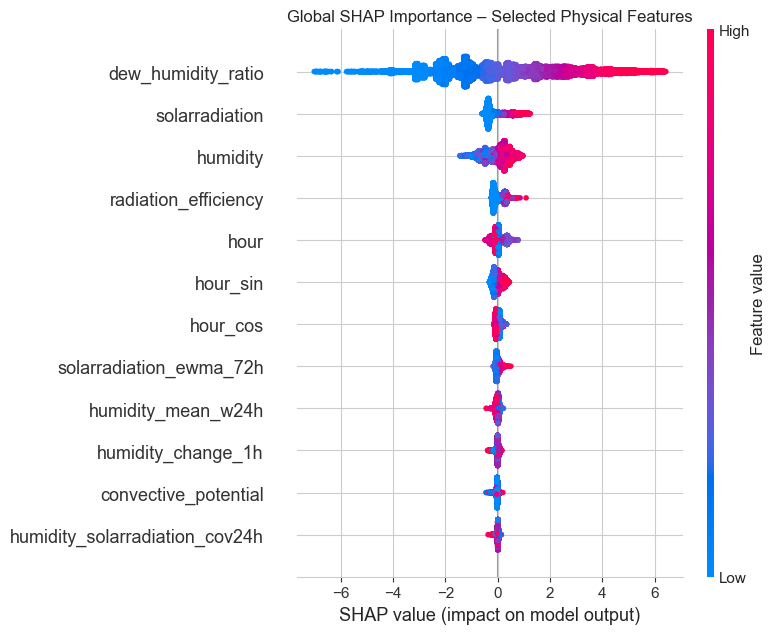

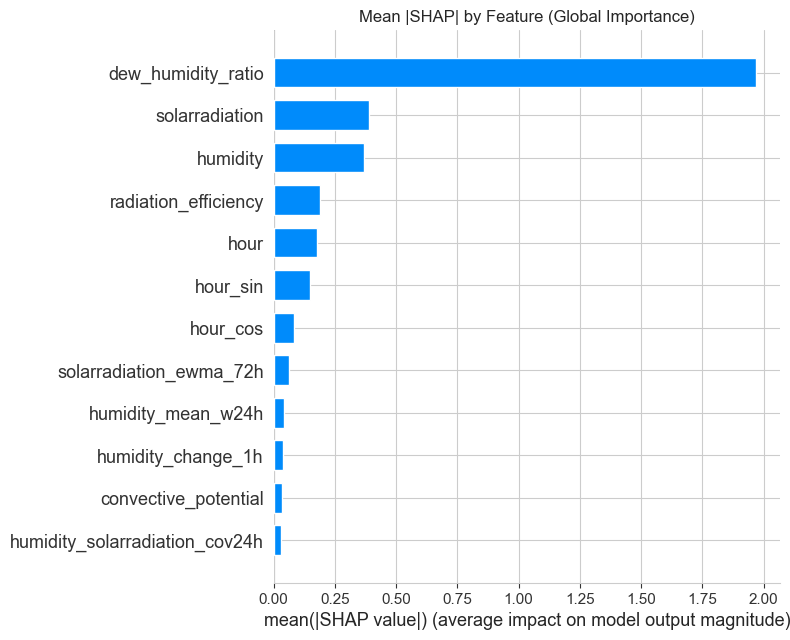


 Top variable families by average |SHAP|:


group
dew               1.968618
solarradiation    0.224004
radiation         0.187437
hour              0.135251
humidity          0.120321
convective        0.033881
Name: mean_abs_shap, dtype: float32


 Top features by mean |SHAP|:


,feature,mean_abs_shap,group
0,dew_humidity_ratio,1.968618,dew
5,solarradiation,0.387476,solarradiation
7,humidity,0.369570,humidity
4,radiation_efficiency,0.187437,radiation
1,hour,0.176386,hour
2,hour_sin,0.148524,hour
3,hour_cos,0.080844,hour
6,solarradiation_ewma_72h,0.060532,solarradiation
8,humidity_mean_w24h,0.043821,humidity
10,humidity_change_1h,0.039628,humidity


In [99]:
# =========================================================
#   SHAP Analysis – Explain & Validate Variables
# =========================================================

print("\n Computing SHAP values... (TreeExplainer)")
explainer = shap.TreeExplainer(xgb_temp)
shap_values = explainer(X_test_sel)

# --- Global feature importance ---
shap.summary_plot(shap_values, X_test_sel, show=False)
plt.title("Global SHAP Importance – Selected Physical Features")
plt.show()

# --- Mean |SHAP| Bar Chart ---
shap.summary_plot(shap_values, X_test_sel, plot_type="bar", show=False)
plt.title("Mean |SHAP| by Feature (Global Importance)")
plt.show()

# =========================================================
#   Group & Evaluate Feature Families
# =========================================================

fi = pd.DataFrame({
    "feature": X_test_sel.columns,
    "mean_abs_shap": np.abs(shap_values.values).mean(axis=0)
})
fi["group"] = fi["feature"].map(base)

group_shap = fi.groupby("group")["mean_abs_shap"].mean().sort_values(ascending=False)
print("\n Top variable families by average |SHAP|:")
display(group_shap.head(30))

# =========================================================
#   Targeted Dependence Plots (diagnostics)
# =========================================================

key_physics = [
    "wind_v_mean_w7", "wind_monsoon_index",
    "is_rain_sum_w7", "severerisk_mean_w7",
    "humidity_mean_w7", "solarradiation_mean_w3"
]

for feat in [f for f in key_physics if f in X_test_sel.columns]:
    shap.dependence_plot(feat, shap_values.values, X_test_sel,
                         interaction_index=None, show=False)
    plt.title(f"SHAP Dependence – {feat}")
    plt.show()

# =========================================================
#  Top Contributors Summary
# =========================================================

top = fi.sort_values("mean_abs_shap", ascending=False).head(20)

print("\n Top features by mean |SHAP|:")
display(top)

### **8.5. Hyperparameter Tuning for SGD Regressor**

This part of the notebook focuses on finding the best hyperparameters for a Stochastic Gradient Descent (SGD) Regressor model using the Optuna optimization library.

*   **Data Scaling (Cell 100)**:
    *   **Action**: A `MinMaxScaler` is fitted on the **training data only** (`X_train_sel`) and then used to transform both the training and test sets.
    *   **Reasoning**: SGD is a linear model that is sensitive to the scale of the input features. Scaling all features to a common range (typically 0 to 1) ensures that the model's optimization process converges smoothly and that no single feature dominates just because its numerical values are larger. Fitting only on the training data prevents data leakage.

*   **Defining the Optimization Objective (Cell 103)**:
    *   **Action**: A function `objective_sgd(trial)` is defined. This function encapsulates the entire process of training and evaluating one version of the SGD model.
    *   **Optuna `trial` Object**: The `trial` object is the core of Optuna. Inside the function, `trial.suggest_*` methods are used to define a search space for each hyperparameter (e.g., `alpha`, `penalty`, `learning_rate`).
    *   **Model Training and Cross-Validation**: For each set of suggested hyperparameters, an `SGDRegressor` model is created and evaluated using `cross_val_score`. A `TimeSeriesSplit` cross-validation strategy is used to ensure the temporal order of the data is respected. The goal is to maximize the negative Root Mean Squared Error (since Optuna minimizes by default, and a higher negative score is better).
    *   **Return Value**: The function returns the mean cross-validation score, which Optuna will use to guide its search for better hyperparameters.

*   **Running the Optimization Study (Cell with `study_sgd.optimize`)**:
    *   **Action**: An Optuna `study` is created with the direction set to `'maximize'`. The `study.optimize()` function is then called, instructing Optuna to run the `objective_sgd` function for a total of 100 `n_trials`.
    *   **Process**: Optuna intelligently explores the hyperparameter search space. It starts with some random trials and then uses the results to focus on more promising regions, efficiently converging on a high-performing set of parameters. The progress bar shows the results of each trial.

*   **Final Output**:
    *   The `print("Best SGD params:", ...)` line at the end displays the set of hyperparameters that resulted in the best cross-validation score found during the 100 trials. This is the "optimized" configuration for the SGD model.

In [100]:
minmax = MinMaxScaler().fit(X_train_sel)
X_train_minmax = minmax.transform(X_train_sel)
X_test_minmax  = minmax.transform(X_test_sel)

In [103]:
# Define scorer
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

scorer = make_scorer(rmse, greater_is_better=False)
tscv = TimeSeriesSplit(n_splits=5)

def objective_sgd(trial):
    alpha = trial.suggest_loguniform('alpha', 1e-6, 1e-2)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    max_iter = trial.suggest_categorical('max_iter', [500, 1000, 2000])
    learning_rate = trial.suggest_categorical('learning_rate', ['optimal', 'invscaling', 'adaptive'])
    eta0 = trial.suggest_loguniform('eta0', 1e-4, 1e-1)

    model = SGDRegressor(
        alpha=alpha,
        penalty=penalty,
        max_iter=max_iter,
        learning_rate=learning_rate,
        eta0=eta0,
        random_state=42
    )

    scores = cross_val_score(model, X_train_minmax, y_train, cv=tscv, scoring=scorer, n_jobs=-1)
    return np.mean(scores)

study_sgd = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_sgd.optimize(objective_sgd, n_trials=100, show_progress_bar=True)
print("Best SGD params:", study_sgd.best_params)


[I 2025-11-15 18:12:03,016] A new study created in memory with name: no-name-d886ae73-3e32-49a6-8105-1b00e6473889
Best trial: 0. Best value: -1.09267:   1%|          | 1/100 [00:01<02:53,  1.76s/it]

[I 2025-11-15 18:12:04,771] Trial 0 finished with value: -1.0926746139411296 and parameters: {'alpha': 3.1489116479568635e-05, 'penalty': 'l1', 'max_iter': 500, 'learning_rate': 'invscaling', 'eta0': 0.013311216080736894}. Best is trial 0 with value: -1.0926746139411296.


Best trial: 0. Best value: -1.09267:   2%|▏         | 2/100 [00:03<03:12,  1.96s/it]

[I 2025-11-15 18:12:06,882] Trial 1 finished with value: -1.3585431191676245 and parameters: {'alpha': 1.2087541473056965e-06, 'penalty': 'l1', 'max_iter': 500, 'learning_rate': 'invscaling', 'eta0': 0.0007476312062252305}. Best is trial 0 with value: -1.0926746139411296.


Best trial: 0. Best value: -1.09267:   3%|▎         | 3/100 [00:05<02:52,  1.77s/it]

[I 2025-11-15 18:12:08,431] Trial 2 finished with value: -1.1360535991529572 and parameters: {'alpha': 0.0002801635158716264, 'penalty': 'l2', 'max_iter': 2000, 'learning_rate': 'adaptive', 'eta0': 0.000137832374550072}. Best is trial 0 with value: -1.0926746139411296.


Best trial: 3. Best value: -1.07644:   4%|▍         | 4/100 [00:06<02:28,  1.55s/it]

[I 2025-11-15 18:12:09,628] Trial 3 finished with value: -1.0764440374733966 and parameters: {'alpha': 0.000269264691008618, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.0020914981329035616}. Best is trial 3 with value: -1.0764440374733966.


Best trial: 3. Best value: -1.07644:   5%|▌         | 5/100 [00:07<01:48,  1.14s/it]

[I 2025-11-15 18:12:10,042] Trial 4 finished with value: -1.0930420432281036 and parameters: {'alpha': 3.0771802712506896e-06, 'penalty': 'l1', 'max_iter': 500, 'learning_rate': 'adaptive', 'eta0': 0.00035856126103454}. Best is trial 3 with value: -1.0764440374733966.


Best trial: 3. Best value: -1.07644:   7%|▋         | 7/100 [00:07<01:03,  1.46it/s]

[I 2025-11-15 18:12:10,569] Trial 5 finished with value: -1.4023867885203054 and parameters: {'alpha': 0.00755681014127443, 'penalty': 'l2', 'max_iter': 2000, 'learning_rate': 'invscaling', 'eta0': 0.0009462175356461491}. Best is trial 3 with value: -1.0764440374733966.
[I 2025-11-15 18:12:10,747] Trial 6 finished with value: -1.0785776138719165 and parameters: {'alpha': 3.58681649862755e-05, 'penalty': 'l2', 'max_iter': 2000, 'learning_rate': 'invscaling', 'eta0': 0.09133995846860977}. Best is trial 3 with value: -1.0764440374733966.


Best trial: 3. Best value: -1.07644:   8%|▊         | 8/100 [00:10<01:52,  1.23s/it]

[I 2025-11-15 18:12:13,139] Trial 7 finished with value: -236580351.87806025 and parameters: {'alpha': 0.001227380098785297, 'penalty': 'l1', 'max_iter': 500, 'learning_rate': 'optimal', 'eta0': 0.00022264204303769702}. Best is trial 3 with value: -1.0764440374733966.


Best trial: 3. Best value: -1.07644:   9%|▉         | 9/100 [00:10<01:26,  1.05it/s]

[I 2025-11-15 18:12:13,493] Trial 8 finished with value: -1.095026602625572 and parameters: {'alpha': 0.0028340904295147754, 'penalty': 'l1', 'max_iter': 2000, 'learning_rate': 'adaptive', 'eta0': 0.0026100256506134765}. Best is trial 3 with value: -1.0764440374733966.


Best trial: 3. Best value: -1.07644:  10%|█         | 10/100 [00:10<01:12,  1.25it/s]

[I 2025-11-15 18:12:13,948] Trial 9 finished with value: -1.2117754065234503 and parameters: {'alpha': 3.0086868214458464e-06, 'penalty': 'l2', 'max_iter': 1000, 'learning_rate': 'optimal', 'eta0': 0.00021070472806578247}. Best is trial 3 with value: -1.0764440374733966.


Best trial: 10. Best value: -1.07586:  11%|█         | 11/100 [00:11<00:58,  1.52it/s]

[I 2025-11-15 18:12:14,276] Trial 10 finished with value: -1.0758558300845213 and parameters: {'alpha': 0.00022093378180472193, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.01209242688122208}. Best is trial 10 with value: -1.0758558300845213.


Best trial: 10. Best value: -1.07586:  12%|█▏        | 12/100 [00:11<00:48,  1.80it/s]

[I 2025-11-15 18:12:14,601] Trial 11 finished with value: -1.0759275295869561 and parameters: {'alpha': 0.0002486622815002146, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.010460548340296744}. Best is trial 10 with value: -1.0758558300845213.


Best trial: 10. Best value: -1.07586:  13%|█▎        | 13/100 [00:11<00:42,  2.05it/s]

[I 2025-11-15 18:12:14,936] Trial 12 finished with value: -1.0758753792919438 and parameters: {'alpha': 0.00012337323407596922, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.013823018936159406}. Best is trial 10 with value: -1.0758558300845213.


Best trial: 10. Best value: -1.07586:  14%|█▍        | 14/100 [00:12<00:40,  2.14it/s]

[I 2025-11-15 18:12:15,351] Trial 13 finished with value: -1.0760261805558848 and parameters: {'alpha': 2.7104914577276234e-05, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.014115193235771484}. Best is trial 10 with value: -1.0758558300845213.


Best trial: 10. Best value: -1.07586:  15%|█▌        | 15/100 [00:12<00:36,  2.31it/s]

[I 2025-11-15 18:12:15,707] Trial 14 finished with value: -1.0758623871661617 and parameters: {'alpha': 8.36064503134345e-05, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.06245334701279449}. Best is trial 10 with value: -1.0758558300845213.


Best trial: 10. Best value: -1.07586:  16%|█▌        | 16/100 [00:13<00:34,  2.42it/s]

[I 2025-11-15 18:12:16,073] Trial 15 finished with value: -1.0776424819733785 and parameters: {'alpha': 0.0010301431431083527, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.09007356611550381}. Best is trial 10 with value: -1.0758558300845213.


Best trial: 10. Best value: -1.07586:  17%|█▋        | 17/100 [00:13<00:31,  2.68it/s]

[I 2025-11-15 18:12:16,356] Trial 16 finished with value: -1.091598331565423 and parameters: {'alpha': 5.656146765126758e-05, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'optimal', 'eta0': 0.038273846053689574}. Best is trial 10 with value: -1.0758558300845213.


Best trial: 10. Best value: -1.07586:  18%|█▊        | 18/100 [00:13<00:30,  2.72it/s]

[I 2025-11-15 18:12:16,711] Trial 17 finished with value: -1.0760466963577495 and parameters: {'alpha': 7.86855352882485e-06, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.03589115483678071}. Best is trial 10 with value: -1.0758558300845213.


Best trial: 10. Best value: -1.07586:  19%|█▉        | 19/100 [00:13<00:27,  2.97it/s]

[I 2025-11-15 18:12:16,974] Trial 18 finished with value: -1.1174426947937175 and parameters: {'alpha': 0.0007410154567172249, 'penalty': 'l2', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.005925490161036235}. Best is trial 10 with value: -1.0758558300845213.


Best trial: 10. Best value: -1.07586:  20%|██        | 20/100 [00:14<00:43,  1.83it/s]

[I 2025-11-15 18:12:18,006] Trial 19 finished with value: -146.5035463459987 and parameters: {'alpha': 0.00014760021812896515, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'optimal', 'eta0': 0.03443444273031636}. Best is trial 10 with value: -1.0758558300845213.


Best trial: 10. Best value: -1.07586:  21%|██        | 21/100 [00:15<00:38,  2.07it/s]

[I 2025-11-15 18:12:18,340] Trial 20 finished with value: -1.0760938492605292 and parameters: {'alpha': 1.1684631170929292e-05, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.007377623749593294}. Best is trial 10 with value: -1.0758558300845213.


Best trial: 10. Best value: -1.07586:  22%|██▏       | 22/100 [00:15<00:34,  2.27it/s]

[I 2025-11-15 18:12:18,686] Trial 21 finished with value: -1.0759735525490024 and parameters: {'alpha': 8.006671360174874e-05, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.017905716664152964}. Best is trial 10 with value: -1.0758558300845213.


Best trial: 22. Best value: -1.07568:  23%|██▎       | 23/100 [00:15<00:31,  2.46it/s]

[I 2025-11-15 18:12:19,009] Trial 22 finished with value: -1.0756846765291594 and parameters: {'alpha': 0.00011691814463592396, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.004414749631294187}. Best is trial 22 with value: -1.0756846765291594.


Best trial: 22. Best value: -1.07568:  24%|██▍       | 24/100 [00:16<00:29,  2.58it/s]

[I 2025-11-15 18:12:19,355] Trial 23 finished with value: -1.0758797370739237 and parameters: {'alpha': 0.0004916772982264532, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.004453195435082877}. Best is trial 22 with value: -1.0756846765291594.


Best trial: 22. Best value: -1.07568:  25%|██▌       | 25/100 [00:16<00:28,  2.67it/s]

[I 2025-11-15 18:12:19,699] Trial 24 finished with value: -1.0774296755336656 and parameters: {'alpha': 1.967959061148821e-05, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.0013566022269085477}. Best is trial 22 with value: -1.0756846765291594.


Best trial: 25. Best value: -1.07562:  26%|██▌       | 26/100 [00:17<00:27,  2.73it/s]

[I 2025-11-15 18:12:20,046] Trial 25 finished with value: -1.0756235067769784 and parameters: {'alpha': 6.91743099465869e-05, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.003780234820708378}. Best is trial 25 with value: -1.0756235067769784.


Best trial: 25. Best value: -1.07562:  27%|██▋       | 27/100 [00:17<00:23,  3.06it/s]

[I 2025-11-15 18:12:20,279] Trial 26 finished with value: -1.2147484057130633 and parameters: {'alpha': 0.0024541885189856526, 'penalty': 'l2', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.004010610712953922}. Best is trial 25 with value: -1.0756235067769784.


Best trial: 25. Best value: -1.07562:  28%|██▊       | 28/100 [00:17<00:23,  3.07it/s]

[I 2025-11-15 18:12:20,604] Trial 27 finished with value: -1.0760840506478744 and parameters: {'alpha': 0.00016432406170317494, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.002628275774156073}. Best is trial 25 with value: -1.0756235067769784.


Best trial: 25. Best value: -1.07562:  29%|██▉       | 29/100 [00:18<00:25,  2.83it/s]

[I 2025-11-15 18:12:21,020] Trial 28 finished with value: -1.111767857777325 and parameters: {'alpha': 0.00045892705193062303, 'penalty': 'l1', 'max_iter': 2000, 'learning_rate': 'invscaling', 'eta0': 0.008166801439509375}. Best is trial 25 with value: -1.0756235067769784.


Best trial: 25. Best value: -1.07562:  30%|███       | 30/100 [00:18<00:22,  3.07it/s]

[I 2025-11-15 18:12:21,284] Trial 29 finished with value: -1.0915253420849456 and parameters: {'alpha': 4.817694323110181e-05, 'penalty': 'l1', 'max_iter': 500, 'learning_rate': 'optimal', 'eta0': 0.021168244226565564}. Best is trial 25 with value: -1.0756235067769784.


Best trial: 25. Best value: -1.07562:  31%|███       | 31/100 [00:18<00:27,  2.55it/s]

[I 2025-11-15 18:12:21,832] Trial 30 finished with value: -1.1366710422572004 and parameters: {'alpha': 1.65510121515912e-05, 'penalty': 'l1', 'max_iter': 500, 'learning_rate': 'invscaling', 'eta0': 0.004776400924040534}. Best is trial 25 with value: -1.0756235067769784.


Best trial: 25. Best value: -1.07562:  32%|███▏      | 32/100 [00:19<00:25,  2.64it/s]

[I 2025-11-15 18:12:22,175] Trial 31 finished with value: -1.0758602442746892 and parameters: {'alpha': 7.909518016021493e-05, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.06411766561255106}. Best is trial 25 with value: -1.0756235067769784.


Best trial: 25. Best value: -1.07562:  33%|███▎      | 33/100 [00:19<00:24,  2.71it/s]

[I 2025-11-15 18:12:22,522] Trial 32 finished with value: -1.0769916903570207 and parameters: {'alpha': 7.964052945884744e-05, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.0015495051381173102}. Best is trial 25 with value: -1.0756235067769784.


Best trial: 25. Best value: -1.07562:  34%|███▍      | 34/100 [00:19<00:23,  2.86it/s]

[I 2025-11-15 18:12:22,828] Trial 33 finished with value: -1.0759132234087159 and parameters: {'alpha': 0.0001792292206559543, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.022479461209376682}. Best is trial 25 with value: -1.0756235067769784.


Best trial: 25. Best value: -1.07562:  35%|███▌      | 35/100 [00:20<00:22,  2.84it/s]

[I 2025-11-15 18:12:23,184] Trial 34 finished with value: -1.0764025640277786 and parameters: {'alpha': 0.0004137462261227984, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.0032305269217490365}. Best is trial 25 with value: -1.0756235067769784.


Best trial: 25. Best value: -1.07562:  36%|███▌      | 36/100 [00:20<00:21,  2.91it/s]

[I 2025-11-15 18:12:23,509] Trial 35 finished with value: -1.0764641419132872 and parameters: {'alpha': 4.800473585630665e-05, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.0016077912604698554}. Best is trial 25 with value: -1.0756235067769784.


Best trial: 25. Best value: -1.07562:  37%|███▋      | 37/100 [00:20<00:20,  3.04it/s]

[I 2025-11-15 18:12:23,803] Trial 36 finished with value: -1.0918534227722325 and parameters: {'alpha': 0.0002637534723845193, 'penalty': 'l2', 'max_iter': 500, 'learning_rate': 'adaptive', 'eta0': 0.0007977778250607433}. Best is trial 25 with value: -1.0756235067769784.


Best trial: 25. Best value: -1.07562:  38%|███▊      | 38/100 [00:21<00:21,  2.88it/s]

[I 2025-11-15 18:12:24,192] Trial 37 finished with value: -1.1041862112604766 and parameters: {'alpha': 8.613011787744636e-06, 'penalty': 'l1', 'max_iter': 2000, 'learning_rate': 'invscaling', 'eta0': 0.009359373310921699}. Best is trial 25 with value: -1.0756235067769784.


Best trial: 25. Best value: -1.07562:  39%|███▉      | 39/100 [00:21<00:21,  2.78it/s]

[I 2025-11-15 18:12:24,580] Trial 38 finished with value: -1.0845720645201324 and parameters: {'alpha': 2.9414337182154112e-05, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.0005537991775542675}. Best is trial 25 with value: -1.0756235067769784.


Best trial: 25. Best value: -1.07562:  40%|████      | 40/100 [00:21<00:19,  3.03it/s]

[I 2025-11-15 18:12:24,844] Trial 39 finished with value: -1.0759618674017393 and parameters: {'alpha': 1.0024170599330033e-06, 'penalty': 'l2', 'max_iter': 2000, 'learning_rate': 'adaptive', 'eta0': 0.05504748029306035}. Best is trial 25 with value: -1.0756235067769784.


Best trial: 25. Best value: -1.07562:  41%|████      | 41/100 [00:22<00:26,  2.19it/s]

[I 2025-11-15 18:12:25,597] Trial 40 finished with value: -1.2081763866644035 and parameters: {'alpha': 9.388017967503195e-05, 'penalty': 'l1', 'max_iter': 500, 'learning_rate': 'invscaling', 'eta0': 0.0021324656676465006}. Best is trial 25 with value: -1.0756235067769784.


Best trial: 25. Best value: -1.07562:  42%|████▏     | 42/100 [00:22<00:23,  2.43it/s]

[I 2025-11-15 18:12:25,902] Trial 41 finished with value: -1.075847783056338 and parameters: {'alpha': 6.84574891846736e-05, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.07396697615975376}. Best is trial 25 with value: -1.0756235067769784.


Best trial: 25. Best value: -1.07562:  43%|████▎     | 43/100 [00:23<00:21,  2.59it/s]

[I 2025-11-15 18:12:26,227] Trial 42 finished with value: -1.075884222230637 and parameters: {'alpha': 5.3919195626897836e-05, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.06091009450178358}. Best is trial 25 with value: -1.0756235067769784.


Best trial: 25. Best value: -1.07562:  44%|████▍     | 44/100 [00:23<00:20,  2.72it/s]

[I 2025-11-15 18:12:26,552] Trial 43 finished with value: -1.0758517476301395 and parameters: {'alpha': 0.0002448184369591101, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.0280507693613726}. Best is trial 25 with value: -1.0756235067769784.


Best trial: 25. Best value: -1.07562:  45%|████▌     | 45/100 [00:23<00:19,  2.82it/s]

[I 2025-11-15 18:12:26,877] Trial 44 finished with value: -1.075873917426172 and parameters: {'alpha': 0.0001792963229373066, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.025797373848155277}. Best is trial 25 with value: -1.0756235067769784.


Best trial: 25. Best value: -1.07562:  46%|████▌     | 46/100 [00:24<00:18,  2.92it/s]

[I 2025-11-15 18:12:27,191] Trial 45 finished with value: -1.0759903425224913 and parameters: {'alpha': 0.0003534692275842608, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.010621518260668764}. Best is trial 25 with value: -1.0756235067769784.


Best trial: 25. Best value: -1.07562:  47%|████▋     | 47/100 [00:28<01:21,  1.53s/it]

[I 2025-11-15 18:12:31,487] Trial 46 finished with value: -50787.800984130365 and parameters: {'alpha': 0.0002392245341467841, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'optimal', 'eta0': 0.01579516038907512}. Best is trial 25 with value: -1.0756235067769784.


Best trial: 25. Best value: -1.07562:  48%|████▊     | 48/100 [00:28<00:59,  1.15s/it]

[I 2025-11-15 18:12:31,739] Trial 47 finished with value: -1.1120054363548555 and parameters: {'alpha': 0.0006617054387875918, 'penalty': 'l2', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.029432248842380496}. Best is trial 25 with value: -1.0756235067769784.


Best trial: 25. Best value: -1.07562:  49%|████▉     | 49/100 [00:29<00:46,  1.09it/s]

[I 2025-11-15 18:12:32,112] Trial 48 finished with value: -1.0859730111042096 and parameters: {'alpha': 0.0024333479112227693, 'penalty': 'l1', 'max_iter': 2000, 'learning_rate': 'adaptive', 'eta0': 0.09882134453902412}. Best is trial 25 with value: -1.0756235067769784.


Best trial: 25. Best value: -1.07562:  50%|█████     | 50/100 [00:29<00:37,  1.34it/s]

[I 2025-11-15 18:12:32,469] Trial 49 finished with value: -1.122027015364437 and parameters: {'alpha': 0.008222187650249404, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.04615426657220879}. Best is trial 25 with value: -1.0756235067769784.


Best trial: 25. Best value: -1.07562:  51%|█████     | 51/100 [00:29<00:30,  1.62it/s]

[I 2025-11-15 18:12:32,782] Trial 50 finished with value: -1.0758666109798452 and parameters: {'alpha': 0.00011616883352088465, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.005968482978978561}. Best is trial 25 with value: -1.0756235067769784.


Best trial: 25. Best value: -1.07562:  52%|█████▏    | 52/100 [00:30<00:24,  1.98it/s]

[I 2025-11-15 18:12:33,028] Trial 51 finished with value: -1.07588124617251 and parameters: {'alpha': 3.6222672550732675e-05, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.06753433333647389}. Best is trial 25 with value: -1.0756235067769784.


Best trial: 25. Best value: -1.07562:  53%|█████▎    | 53/100 [00:30<00:21,  2.20it/s]

[I 2025-11-15 18:12:33,362] Trial 52 finished with value: -1.0758204257806832 and parameters: {'alpha': 0.00011428200621639909, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.07788007833366269}. Best is trial 25 with value: -1.0756235067769784.


Best trial: 25. Best value: -1.07562:  54%|█████▍    | 54/100 [00:30<00:19,  2.39it/s]

[I 2025-11-15 18:12:33,696] Trial 53 finished with value: -1.075927901010342 and parameters: {'alpha': 0.0001242158661617936, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.04423898565390748}. Best is trial 25 with value: -1.0756235067769784.


Best trial: 25. Best value: -1.07562:  55%|█████▌    | 55/100 [00:31<00:17,  2.56it/s]

[I 2025-11-15 18:12:34,021] Trial 54 finished with value: -1.0758260692513597 and parameters: {'alpha': 0.0002091247604599463, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.011686205821933115}. Best is trial 25 with value: -1.0756235067769784.


Best trial: 25. Best value: -1.07562:  56%|█████▌    | 56/100 [00:31<00:15,  2.79it/s]

[I 2025-11-15 18:12:34,307] Trial 55 finished with value: -1.0908997569141259 and parameters: {'alpha': 6.64723833889774e-05, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'optimal', 'eta0': 0.00010186004972082128}. Best is trial 25 with value: -1.0756235067769784.


Best trial: 25. Best value: -1.07562:  57%|█████▋    | 57/100 [00:31<00:14,  2.87it/s]

[I 2025-11-15 18:12:34,632] Trial 56 finished with value: -1.0758724740999446 and parameters: {'alpha': 0.0003241605246225561, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.07543740013417556}. Best is trial 25 with value: -1.0756235067769784.


Best trial: 25. Best value: -1.07562:  58%|█████▊    | 58/100 [00:31<00:14,  2.87it/s]

[I 2025-11-15 18:12:34,979] Trial 57 finished with value: -1.0801262463382968 and parameters: {'alpha': 0.0015349451741424093, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.031153708726976228}. Best is trial 25 with value: -1.0756235067769784.


Best trial: 25. Best value: -1.07562:  59%|█████▉    | 59/100 [00:32<00:13,  3.07it/s]

[I 2025-11-15 18:12:35,252] Trial 58 finished with value: -1.1130053273901155 and parameters: {'alpha': 0.0006776046507801899, 'penalty': 'l2', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.006158003244678813}. Best is trial 25 with value: -1.0756235067769784.


Best trial: 25. Best value: -1.07562:  60%|██████    | 60/100 [00:32<00:11,  3.43it/s]

[I 2025-11-15 18:12:35,464] Trial 59 finished with value: -1.0809271602199602 and parameters: {'alpha': 3.6203304971058434e-06, 'penalty': 'l1', 'max_iter': 500, 'learning_rate': 'invscaling', 'eta0': 0.046794540778911854}. Best is trial 25 with value: -1.0756235067769784.


Best trial: 25. Best value: -1.07562:  61%|██████    | 61/100 [00:32<00:12,  3.21it/s]

[I 2025-11-15 18:12:35,822] Trial 60 finished with value: -1.0760158153131658 and parameters: {'alpha': 1.9607438235017462e-05, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.017588419848878573}. Best is trial 25 with value: -1.0756235067769784.


Best trial: 25. Best value: -1.07562:  62%|██████▏   | 62/100 [00:33<00:12,  3.13it/s]

[I 2025-11-15 18:12:36,159] Trial 61 finished with value: -1.0758293238287748 and parameters: {'alpha': 0.00018351401003853193, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.013335442376681573}. Best is trial 25 with value: -1.0756235067769784.


Best trial: 25. Best value: -1.07562:  63%|██████▎   | 63/100 [00:33<00:12,  3.08it/s]

[I 2025-11-15 18:12:36,496] Trial 62 finished with value: -1.0759617113819462 and parameters: {'alpha': 0.00013271530191886428, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.011413009146316287}. Best is trial 25 with value: -1.0756235067769784.


Best trial: 25. Best value: -1.07562:  64%|██████▍   | 64/100 [00:33<00:11,  3.08it/s]

[I 2025-11-15 18:12:36,820] Trial 63 finished with value: -1.0756430672153552 and parameters: {'alpha': 0.00018705704422053424, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.0077746717038104495}. Best is trial 25 with value: -1.0756235067769784.


Best trial: 25. Best value: -1.07562:  65%|██████▌   | 65/100 [00:34<00:11,  2.94it/s]

[I 2025-11-15 18:12:37,195] Trial 64 finished with value: -1.0756380900601372 and parameters: {'alpha': 0.00010662766521308952, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.003818191475954234}. Best is trial 25 with value: -1.0756235067769784.


Best trial: 25. Best value: -1.07562:  66%|██████▌   | 66/100 [00:34<00:11,  2.98it/s]

[I 2025-11-15 18:12:37,521] Trial 65 finished with value: -1.0757541487464226 and parameters: {'alpha': 0.0001913218836491867, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.003572310356612357}. Best is trial 25 with value: -1.0756235067769784.


Best trial: 25. Best value: -1.07562:  67%|██████▋   | 67/100 [00:34<00:11,  2.98it/s]

[I 2025-11-15 18:12:37,855] Trial 66 finished with value: -1.0757088495532658 and parameters: {'alpha': 9.610217369227542e-05, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.0034447375713967214}. Best is trial 25 with value: -1.0756235067769784.


Best trial: 25. Best value: -1.07562:  68%|██████▊   | 68/100 [00:35<00:15,  2.03it/s]

[I 2025-11-15 18:12:38,718] Trial 67 finished with value: -1.1222463374125042 and parameters: {'alpha': 0.00011125748540983117, 'penalty': 'l1', 'max_iter': 2000, 'learning_rate': 'optimal', 'eta0': 0.003273631335428136}. Best is trial 25 with value: -1.0756235067769784.


Best trial: 25. Best value: -1.07562:  69%|██████▉   | 69/100 [00:36<00:14,  2.21it/s]

[I 2025-11-15 18:12:39,075] Trial 68 finished with value: -1.0777135824609219 and parameters: {'alpha': 4.196374381805803e-05, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.001161824663174075}. Best is trial 25 with value: -1.0756235067769784.


Best trial: 25. Best value: -1.07562:  70%|███████   | 70/100 [00:36<00:12,  2.42it/s]

[I 2025-11-15 18:12:39,399] Trial 69 finished with value: -1.0760096735479738 and parameters: {'alpha': 9.847221705071075e-05, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.0020837098362945605}. Best is trial 25 with value: -1.0756235067769784.


Best trial: 25. Best value: -1.07562:  71%|███████   | 71/100 [00:36<00:10,  2.69it/s]

[I 2025-11-15 18:12:39,672] Trial 70 finished with value: -1.0762121850198212 and parameters: {'alpha': 2.6123612224371938e-05, 'penalty': 'l2', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.004687743305169369}. Best is trial 25 with value: -1.0756235067769784.


Best trial: 25. Best value: -1.07562:  72%|███████▏  | 72/100 [00:36<00:10,  2.80it/s]

[I 2025-11-15 18:12:39,997] Trial 71 finished with value: -1.0757248110833768 and parameters: {'alpha': 0.00014994448878094985, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.0034689063851373503}. Best is trial 25 with value: -1.0756235067769784.


Best trial: 25. Best value: -1.07562:  73%|███████▎  | 73/100 [00:37<00:09,  2.88it/s]

[I 2025-11-15 18:12:40,322] Trial 72 finished with value: -1.076160675063068 and parameters: {'alpha': 0.00015471252041726784, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.0025039599294083992}. Best is trial 25 with value: -1.0756235067769784.


Best trial: 73. Best value: -1.07561:  74%|███████▍  | 74/100 [00:37<00:08,  2.94it/s]

[I 2025-11-15 18:12:40,645] Trial 73 finished with value: -1.0756133345127847 and parameters: {'alpha': 5.906741005471052e-05, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.003706616069634026}. Best is trial 73 with value: -1.0756133345127847.


Best trial: 73. Best value: -1.07561:  75%|███████▌  | 75/100 [00:37<00:08,  2.98it/s]

[I 2025-11-15 18:12:40,969] Trial 74 finished with value: -1.075613350689254 and parameters: {'alpha': 6.313609294342623e-05, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.004142760217681049}. Best is trial 73 with value: -1.0756133345127847.


Best trial: 75. Best value: -1.07552:  76%|███████▌  | 76/100 [00:38<00:07,  3.00it/s]

[I 2025-11-15 18:12:41,296] Trial 75 finished with value: -1.0755171765774048 and parameters: {'alpha': 6.378407874374312e-05, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.006803705281538432}. Best is trial 75 with value: -1.0755171765774048.


Best trial: 75. Best value: -1.07552:  77%|███████▋  | 77/100 [00:38<00:09,  2.55it/s]

[I 2025-11-15 18:12:41,827] Trial 76 finished with value: -1.1322897807477437 and parameters: {'alpha': 6.296710894784174e-05, 'penalty': 'l1', 'max_iter': 500, 'learning_rate': 'invscaling', 'eta0': 0.0052525738617888}. Best is trial 75 with value: -1.0755171765774048.


Best trial: 75. Best value: -1.07552:  78%|███████▊  | 78/100 [00:39<00:08,  2.71it/s]

[I 2025-11-15 18:12:42,142] Trial 77 finished with value: -1.0760843536837044 and parameters: {'alpha': 3.9046707822201735e-05, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.0074387581292592745}. Best is trial 75 with value: -1.0755171765774048.


Best trial: 75. Best value: -1.07552:  79%|███████▉  | 79/100 [00:39<00:07,  2.79it/s]

[I 2025-11-15 18:12:42,477] Trial 78 finished with value: -1.0756024118550205 and parameters: {'alpha': 2.889037153254139e-05, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.004095398946382188}. Best is trial 75 with value: -1.0755171765774048.


Best trial: 75. Best value: -1.07552:  80%|████████  | 80/100 [00:39<00:07,  2.84it/s]

[I 2025-11-15 18:12:42,812] Trial 79 finished with value: -1.0758801672090252 and parameters: {'alpha': 2.5804728299234985e-05, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.00916492073600258}. Best is trial 75 with value: -1.0755171765774048.


Best trial: 75. Best value: -1.07552:  81%|████████  | 81/100 [00:40<00:07,  2.67it/s]

[I 2025-11-15 18:12:43,239] Trial 80 finished with value: -1.121685100885517 and parameters: {'alpha': 1.2212064349568418e-05, 'penalty': 'l1', 'max_iter': 2000, 'learning_rate': 'optimal', 'eta0': 0.0026802961395862523}. Best is trial 75 with value: -1.0755171765774048.


Best trial: 75. Best value: -1.07552:  82%|████████▏ | 82/100 [00:40<00:06,  2.73it/s]

[I 2025-11-15 18:12:43,584] Trial 81 finished with value: -1.0756220935710255 and parameters: {'alpha': 4.693336104046639e-05, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.004203630630401075}. Best is trial 75 with value: -1.0755171765774048.


Best trial: 75. Best value: -1.07552:  83%|████████▎ | 83/100 [00:40<00:06,  2.80it/s]

[I 2025-11-15 18:12:43,920] Trial 82 finished with value: -1.0756105134884926 and parameters: {'alpha': 5.175488473431288e-05, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.00413128103943807}. Best is trial 75 with value: -1.0755171765774048.


Best trial: 75. Best value: -1.07552:  84%|████████▍ | 84/100 [00:41<00:05,  2.85it/s]

[I 2025-11-15 18:12:44,257] Trial 83 finished with value: -1.0759062838340763 and parameters: {'alpha': 5.111804469749532e-05, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.006299295812801754}. Best is trial 75 with value: -1.0755171765774048.


Best trial: 75. Best value: -1.07552:  85%|████████▌ | 85/100 [00:41<00:05,  2.91it/s]

[I 2025-11-15 18:12:44,583] Trial 84 finished with value: -1.0757715888221808 and parameters: {'alpha': 3.2148836526999124e-05, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.004023296159454504}. Best is trial 75 with value: -1.0755171765774048.


Best trial: 75. Best value: -1.07552:  86%|████████▌ | 86/100 [00:41<00:04,  2.96it/s]

[I 2025-11-15 18:12:44,907] Trial 85 finished with value: -1.0759098849880957 and parameters: {'alpha': 7.348043524625133e-05, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.0021230299560813484}. Best is trial 75 with value: -1.0755171765774048.


Best trial: 75. Best value: -1.07552:  87%|████████▋ | 87/100 [00:42<00:04,  3.00it/s]

[I 2025-11-15 18:12:45,233] Trial 86 finished with value: -1.076042595962384 and parameters: {'alpha': 1.5091461647290668e-05, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.007038269154290459}. Best is trial 75 with value: -1.0755171765774048.


Best trial: 87. Best value: -1.07543:  88%|████████▊ | 88/100 [00:42<00:03,  3.07it/s]

[I 2025-11-15 18:12:45,538] Trial 87 finished with value: -1.075431493474177 and parameters: {'alpha': 2.3131410884875815e-05, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.0027852235875286003}. Best is trial 87 with value: -1.075431493474177.


Best trial: 87. Best value: -1.07543:  89%|████████▉ | 89/100 [00:42<00:03,  3.26it/s]

[I 2025-11-15 18:12:45,802] Trial 88 finished with value: -1.076095187254046 and parameters: {'alpha': 2.3749465928166836e-05, 'penalty': 'l2', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.005429008235073941}. Best is trial 87 with value: -1.075431493474177.


Best trial: 87. Best value: -1.07543:  90%|█████████ | 90/100 [00:43<00:03,  3.20it/s]

[I 2025-11-15 18:12:46,127] Trial 89 finished with value: -1.0754593402191823 and parameters: {'alpha': 4.319806960291086e-05, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.002818912939684838}. Best is trial 87 with value: -1.075431493474177.


Best trial: 87. Best value: -1.07543:  91%|█████████ | 91/100 [00:43<00:02,  3.13it/s]

[I 2025-11-15 18:12:46,462] Trial 90 finished with value: -1.0761412130649552 and parameters: {'alpha': 4.3477326692051704e-05, 'penalty': 'l1', 'max_iter': 500, 'learning_rate': 'adaptive', 'eta0': 0.0017556343033878206}. Best is trial 87 with value: -1.075431493474177.


Best trial: 87. Best value: -1.07543:  92%|█████████▏| 92/100 [00:43<00:02,  3.12it/s]

[I 2025-11-15 18:12:46,788] Trial 91 finished with value: -1.0758648944882834 and parameters: {'alpha': 5.307288093891653e-05, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.0025673546312517687}. Best is trial 87 with value: -1.075431493474177.


Best trial: 87. Best value: -1.07543:  93%|█████████▎| 93/100 [00:44<00:02,  3.10it/s]

[I 2025-11-15 18:12:47,113] Trial 92 finished with value: -1.075549872009796 and parameters: {'alpha': 3.293407416433447e-05, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.0029004318482278094}. Best is trial 87 with value: -1.075431493474177.


Best trial: 87. Best value: -1.07543:  94%|█████████▍| 94/100 [00:44<00:01,  3.12it/s]

[I 2025-11-15 18:12:47,429] Trial 93 finished with value: -1.0755393088581031 and parameters: {'alpha': 2.0729783121294464e-05, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.0028601131392703596}. Best is trial 87 with value: -1.075431493474177.


Best trial: 87. Best value: -1.07543:  95%|█████████▌| 95/100 [00:44<00:01,  3.14it/s]

[I 2025-11-15 18:12:47,743] Trial 94 finished with value: -1.0755421776631866 and parameters: {'alpha': 9.303134749928037e-06, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.0030832366131366795}. Best is trial 87 with value: -1.075431493474177.


Best trial: 87. Best value: -1.07543:  96%|█████████▌| 96/100 [00:45<00:01,  3.04it/s]

[I 2025-11-15 18:12:48,098] Trial 95 finished with value: -1.0758081690546548 and parameters: {'alpha': 5.890975054985573e-06, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.0019363371888441118}. Best is trial 87 with value: -1.075431493474177.


Best trial: 87. Best value: -1.07543:  97%|█████████▋| 97/100 [00:45<00:01,  2.31it/s]

[I 2025-11-15 18:12:48,776] Trial 96 finished with value: -1.17531857195713 and parameters: {'alpha': 2.001178390057203e-05, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'invscaling', 'eta0': 0.002918641873125456}. Best is trial 87 with value: -1.075431493474177.


Best trial: 87. Best value: -1.07543:  98%|█████████▊| 98/100 [00:46<00:00,  2.40it/s]

[I 2025-11-15 18:12:49,152] Trial 97 finished with value: -1.0775523017622628 and parameters: {'alpha': 8.461162070377414e-06, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.0012594467213426009}. Best is trial 87 with value: -1.075431493474177.


Best trial: 87. Best value: -1.07543:  99%|█████████▉| 99/100 [00:46<00:00,  2.59it/s]

[I 2025-11-15 18:12:49,467] Trial 98 finished with value: -1.0755085607693664 and parameters: {'alpha': 1.4536725899687952e-05, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.0029983608251688615}. Best is trial 87 with value: -1.075431493474177.


Best trial: 87. Best value: -1.07543: 100%|██████████| 100/100 [00:46<00:00,  2.14it/s]

[I 2025-11-15 18:12:49,791] Trial 99 finished with value: -1.0755404885138382 and parameters: {'alpha': 1.102332890418515e-05, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.003049573904746254}. Best is trial 87 with value: -1.075431493474177.
Best SGD params: {'alpha': 2.3131410884875815e-05, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive', 'eta0': 0.0027852235875286003}


### **8.6. Hyperparameter Tuning for Random Forest Regressor**

This section follows the exact same pattern as the SGD tuning but is now applied to a Random Forest Regressor.

*   **Defining the Optimization Objective (Cell 104)**:
    *   A new function `objective_rf(trial)` is defined.
    *   It specifies the search space for key Random Forest hyperparameters: `n_estimators` (number of trees), `max_depth` (tree depth), `min_samples_split`, `min_samples_leaf`, and `max_features`.
    *   Just like before, a `RandomForestRegressor` is instantiated with the suggested parameters and evaluated using time-series cross-validation.

*   **Running the Optimization Study and Final Output**:
    *   A new Optuna study (`study_rf`) is created and run for 100 trials.
    *   The process logs the outcome of each trial, showing how Optuna gradually finds better parameter combinations.
    *   The `Best RF params` output shows the final, optimized set of hyperparameters for the Random Forest model.

In [104]:
def objective_rf(trial):
    # More conservative ranges for regularization
    n_estimators = trial.suggest_int('n_estimators', 100, 400, step=50)
    max_depth = trial.suggest_int('max_depth', 4, 6)  
    min_samples_split = trial.suggest_int('min_samples_split', 5, 20)  
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 10)    
    max_features = trial.suggest_categorical('max_features', ['sqrt', 0.3, 0.5])

    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )

    scores = cross_val_score(rf, X_train_sel, y_train, cv=tscv, scoring=scorer, n_jobs=-1)
    return np.mean(scores)

study_rf = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_rf.optimize(objective_rf, n_trials=100, show_progress_bar=True)
print("Best RF params:", study_rf.best_params)


[I 2025-11-15 18:12:49,801] A new study created in memory with name: no-name-8b5b325a-d849-47b6-aa49-e3d1280d3c48
Best trial: 0. Best value: -1.09459:   1%|          | 1/100 [00:01<03:16,  1.98s/it]

[I 2025-11-15 18:12:51,784] Trial 0 finished with value: -1.09458741841276 and parameters: {'n_estimators': 200, 'max_depth': 6, 'min_samples_split': 16, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 0 with value: -1.09458741841276.


Best trial: 0. Best value: -1.09459:   2%|▏         | 2/100 [00:05<04:22,  2.68s/it]

[I 2025-11-15 18:12:54,947] Trial 1 finished with value: -1.1569364487694302 and parameters: {'n_estimators': 400, 'max_depth': 5, 'min_samples_split': 16, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: -1.09458741841276.


Best trial: 0. Best value: -1.09459:   3%|▎         | 3/100 [00:07<03:46,  2.33s/it]

[I 2025-11-15 18:12:56,873] Trial 2 finished with value: -1.1141628687569518 and parameters: {'n_estimators': 150, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 0 with value: -1.09458741841276.


Best trial: 0. Best value: -1.09459:   4%|▍         | 4/100 [00:07<02:47,  1.74s/it]

[I 2025-11-15 18:12:57,701] Trial 3 finished with value: -1.25309909584575 and parameters: {'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 0 with value: -1.09458741841276.


Best trial: 0. Best value: -1.09459:   5%|▌         | 5/100 [00:11<03:46,  2.39s/it]

[I 2025-11-15 18:13:01,239] Trial 4 finished with value: -1.1173169739825288 and parameters: {'n_estimators': 300, 'max_depth': 4, 'min_samples_split': 14, 'min_samples_leaf': 4, 'max_features': 0.5}. Best is trial 0 with value: -1.09458741841276.


Best trial: 0. Best value: -1.09459:   6%|▌         | 6/100 [00:15<04:35,  2.93s/it]

[I 2025-11-15 18:13:05,208] Trial 5 finished with value: -1.1148663961804006 and parameters: {'n_estimators': 350, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': 0.5}. Best is trial 0 with value: -1.09458741841276.


Best trial: 6. Best value: -0.991957:   7%|▋         | 7/100 [00:17<03:55,  2.54s/it]

[I 2025-11-15 18:13:06,946] Trial 6 finished with value: -0.9919566328398421 and parameters: {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 8, 'max_features': 0.5}. Best is trial 6 with value: -0.9919566328398421.


Best trial: 7. Best value: -0.991131:   8%|▊         | 8/100 [00:19<03:52,  2.52s/it]

[I 2025-11-15 18:13:09,436] Trial 7 finished with value: -0.9911313687905514 and parameters: {'n_estimators': 150, 'max_depth': 6, 'min_samples_split': 17, 'min_samples_leaf': 10, 'max_features': 0.5}. Best is trial 7 with value: -0.9911313687905514.


Best trial: 7. Best value: -0.991131:   9%|▉         | 9/100 [00:20<03:14,  2.13s/it]

[I 2025-11-15 18:13:10,719] Trial 8 finished with value: -1.1161120507451123 and parameters: {'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 0.5}. Best is trial 7 with value: -0.9911313687905514.


Best trial: 7. Best value: -0.991131:  10%|█         | 10/100 [00:23<03:19,  2.22s/it]

[I 2025-11-15 18:13:13,116] Trial 9 finished with value: -1.1176203882726528 and parameters: {'n_estimators': 200, 'max_depth': 4, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': 0.5}. Best is trial 7 with value: -0.9911313687905514.


Best trial: 7. Best value: -0.991131:  11%|█         | 11/100 [00:25<03:10,  2.14s/it]

[I 2025-11-15 18:13:15,086] Trial 10 finished with value: -1.1588509017969364 and parameters: {'n_estimators': 250, 'max_depth': 5, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 0.3}. Best is trial 7 with value: -0.9911313687905514.


Best trial: 7. Best value: -0.991131:  12%|█▏        | 12/100 [00:26<02:50,  1.94s/it]

[I 2025-11-15 18:13:16,572] Trial 11 finished with value: -1.0933510425949222 and parameters: {'n_estimators': 150, 'max_depth': 6, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 0.3}. Best is trial 7 with value: -0.9911313687905514.


Best trial: 7. Best value: -0.991131:  13%|█▎        | 13/100 [00:28<02:43,  1.88s/it]

[I 2025-11-15 18:13:18,295] Trial 12 finished with value: -0.9922599577305624 and parameters: {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': 0.5}. Best is trial 7 with value: -0.9911313687905514.


Best trial: 7. Best value: -0.991131:  14%|█▍        | 14/100 [00:30<02:57,  2.06s/it]

[I 2025-11-15 18:13:20,780] Trial 13 finished with value: -0.9912359437989743 and parameters: {'n_estimators': 150, 'max_depth': 6, 'min_samples_split': 17, 'min_samples_leaf': 9, 'max_features': 0.5}. Best is trial 7 with value: -0.9911313687905514.


Best trial: 7. Best value: -0.991131:  15%|█▌        | 15/100 [00:33<03:15,  2.30s/it]

[I 2025-11-15 18:13:23,640] Trial 14 finished with value: -1.039882338156687 and parameters: {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 17, 'min_samples_leaf': 9, 'max_features': 0.5}. Best is trial 7 with value: -0.9911313687905514.


Best trial: 7. Best value: -0.991131:  16%|█▌        | 16/100 [00:36<03:15,  2.32s/it]

[I 2025-11-15 18:13:26,018] Trial 15 finished with value: -1.0937522117400802 and parameters: {'n_estimators': 250, 'max_depth': 6, 'min_samples_split': 18, 'min_samples_leaf': 10, 'max_features': 0.3}. Best is trial 7 with value: -0.9911313687905514.


Best trial: 7. Best value: -0.991131:  17%|█▋        | 17/100 [00:38<03:09,  2.29s/it]

[I 2025-11-15 18:13:28,226] Trial 16 finished with value: -1.0386379552166223 and parameters: {'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 14, 'min_samples_leaf': 9, 'max_features': 0.5}. Best is trial 7 with value: -0.9911313687905514.


Best trial: 17. Best value: -0.991085:  18%|█▊        | 18/100 [00:43<04:09,  3.05s/it]

[I 2025-11-15 18:13:33,032] Trial 17 finished with value: -0.9910850986565712 and parameters: {'n_estimators': 300, 'max_depth': 6, 'min_samples_split': 18, 'min_samples_leaf': 8, 'max_features': 0.5}. Best is trial 17 with value: -0.9910850986565712.


Best trial: 17. Best value: -0.991085:  19%|█▉        | 19/100 [00:45<03:58,  2.94s/it]

[I 2025-11-15 18:13:35,741] Trial 18 finished with value: -1.0926814072354643 and parameters: {'n_estimators': 300, 'max_depth': 6, 'min_samples_split': 19, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 17 with value: -0.9910850986565712.


Best trial: 17. Best value: -0.991085:  20%|██        | 20/100 [00:48<03:41,  2.77s/it]

[I 2025-11-15 18:13:38,120] Trial 19 finished with value: -1.1605075284832411 and parameters: {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 0.3}. Best is trial 17 with value: -0.9910850986565712.


Best trial: 20. Best value: -0.990947:  21%|██        | 21/100 [00:54<05:01,  3.82s/it]

[I 2025-11-15 18:13:44,385] Trial 20 finished with value: -0.9909469496053059 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 18, 'min_samples_leaf': 8, 'max_features': 0.5}. Best is trial 20 with value: -0.9909469496053059.


Best trial: 20. Best value: -0.990947:  22%|██▏       | 22/100 [01:00<05:40,  4.36s/it]

[I 2025-11-15 18:13:50,002] Trial 21 finished with value: -0.9912813110699885 and parameters: {'n_estimators': 350, 'max_depth': 6, 'min_samples_split': 18, 'min_samples_leaf': 8, 'max_features': 0.5}. Best is trial 20 with value: -0.9909469496053059.


Best trial: 22. Best value: -0.990866:  23%|██▎       | 23/100 [01:06<06:20,  4.95s/it]

[I 2025-11-15 18:13:56,317] Trial 22 finished with value: -0.9908656295930639 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 18, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 22 with value: -0.9908656295930639.


Best trial: 23. Best value: -0.990731:  24%|██▍       | 24/100 [01:12<06:50,  5.40s/it]

[I 2025-11-15 18:14:02,785] Trial 23 finished with value: -0.9907307111264112 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 11, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  25%|██▌       | 25/100 [01:18<06:45,  5.41s/it]

[I 2025-11-15 18:14:08,203] Trial 24 finished with value: -1.037868807304162 and parameters: {'n_estimators': 400, 'max_depth': 5, 'min_samples_split': 12, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  26%|██▌       | 26/100 [01:24<07:04,  5.74s/it]

[I 2025-11-15 18:14:14,717] Trial 25 finished with value: -0.9908145573061675 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 11, 'min_samples_leaf': 6, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  27%|██▋       | 27/100 [01:30<07:05,  5.83s/it]

[I 2025-11-15 18:14:20,744] Trial 26 finished with value: -0.9911200078162785 and parameters: {'n_estimators': 350, 'max_depth': 6, 'min_samples_split': 11, 'min_samples_leaf': 6, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  28%|██▊       | 28/100 [01:37<07:20,  6.12s/it]

[I 2025-11-15 18:14:27,542] Trial 27 finished with value: -0.9909486345413718 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  29%|██▉       | 29/100 [01:40<06:06,  5.16s/it]

[I 2025-11-15 18:14:30,470] Trial 28 finished with value: -1.1593242451729926 and parameters: {'n_estimators': 350, 'max_depth': 5, 'min_samples_split': 11, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  30%|███       | 30/100 [01:44<05:33,  4.76s/it]

[I 2025-11-15 18:14:34,293] Trial 29 finished with value: -1.09212618094846 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 12, 'min_samples_leaf': 7, 'max_features': 0.3}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  31%|███       | 31/100 [01:47<04:45,  4.14s/it]

[I 2025-11-15 18:14:37,003] Trial 30 finished with value: -1.1594431144000328 and parameters: {'n_estimators': 350, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  32%|███▏      | 32/100 [01:53<05:26,  4.80s/it]

[I 2025-11-15 18:14:43,331] Trial 31 finished with value: -0.9907307111264112 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 13, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  33%|███▎      | 33/100 [01:59<05:53,  5.27s/it]

[I 2025-11-15 18:14:49,710] Trial 32 finished with value: -0.9907307111264114 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 13, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  34%|███▍      | 34/100 [02:06<06:11,  5.63s/it]

[I 2025-11-15 18:14:56,160] Trial 33 finished with value: -0.9907307111264114 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 13, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  35%|███▌      | 35/100 [02:12<06:08,  5.67s/it]

[I 2025-11-15 18:15:01,945] Trial 34 finished with value: -0.9911130301020388 and parameters: {'n_estimators': 350, 'max_depth': 6, 'min_samples_split': 13, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  36%|███▌      | 36/100 [02:15<05:22,  5.04s/it]

[I 2025-11-15 18:15:05,509] Trial 35 finished with value: -1.0925887720036485 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 15, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  37%|███▋      | 37/100 [02:21<05:27,  5.20s/it]

[I 2025-11-15 18:15:11,089] Trial 36 finished with value: -0.9911130301020388 and parameters: {'n_estimators': 350, 'max_depth': 6, 'min_samples_split': 14, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  38%|███▊      | 38/100 [02:27<05:46,  5.59s/it]

[I 2025-11-15 18:15:17,575] Trial 37 finished with value: -0.9908145573061674 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  39%|███▉      | 39/100 [02:33<05:41,  5.60s/it]

[I 2025-11-15 18:15:23,208] Trial 38 finished with value: -0.991228289528 and parameters: {'n_estimators': 350, 'max_depth': 6, 'min_samples_split': 15, 'min_samples_leaf': 5, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  40%|████      | 40/100 [02:39<05:51,  5.85s/it]

[I 2025-11-15 18:15:29,640] Trial 39 finished with value: -0.9908303094423132 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 12, 'min_samples_leaf': 8, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  41%|████      | 41/100 [02:44<05:28,  5.57s/it]

[I 2025-11-15 18:15:34,569] Trial 40 finished with value: -1.0385442702017582 and parameters: {'n_estimators': 350, 'max_depth': 5, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  42%|████▏     | 42/100 [02:51<05:39,  5.85s/it]

[I 2025-11-15 18:15:41,076] Trial 41 finished with value: -0.9908145573061675 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  43%|████▎     | 43/100 [02:57<05:42,  6.00s/it]

[I 2025-11-15 18:15:47,421] Trial 42 finished with value: -0.9907307111264112 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  44%|████▍     | 44/100 [03:04<05:44,  6.15s/it]

[I 2025-11-15 18:15:53,922] Trial 43 finished with value: -0.9907307111264114 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 14, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  45%|████▌     | 45/100 [03:09<05:32,  6.04s/it]

[I 2025-11-15 18:15:59,718] Trial 44 finished with value: -0.9911130301020388 and parameters: {'n_estimators': 350, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  46%|████▌     | 46/100 [03:16<05:33,  6.18s/it]

[I 2025-11-15 18:16:06,219] Trial 45 finished with value: -0.9907307111264114 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 11, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  47%|████▋     | 47/100 [03:22<05:32,  6.26s/it]

[I 2025-11-15 18:16:12,676] Trial 46 finished with value: -0.9908303094423132 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 12, 'min_samples_leaf': 8, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  48%|████▊     | 48/100 [03:26<04:38,  5.35s/it]

[I 2025-11-15 18:16:15,905] Trial 47 finished with value: -1.0934021347698257 and parameters: {'n_estimators': 350, 'max_depth': 6, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 0.3}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  49%|████▉     | 49/100 [03:28<03:51,  4.54s/it]

[I 2025-11-15 18:16:18,540] Trial 48 finished with value: -1.2310018845156088 and parameters: {'n_estimators': 400, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  50%|█████     | 50/100 [03:33<03:52,  4.64s/it]

[I 2025-11-15 18:16:23,426] Trial 49 finished with value: -0.9909836954294325 and parameters: {'n_estimators': 300, 'max_depth': 6, 'min_samples_split': 16, 'min_samples_leaf': 8, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  51%|█████     | 51/100 [03:39<04:04,  5.00s/it]

[I 2025-11-15 18:16:29,258] Trial 50 finished with value: -0.9911478211458513 and parameters: {'n_estimators': 350, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  52%|█████▏    | 52/100 [03:45<04:18,  5.38s/it]

[I 2025-11-15 18:16:35,529] Trial 51 finished with value: -0.9907307111264114 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 14, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  53%|█████▎    | 53/100 [03:52<04:28,  5.71s/it]

[I 2025-11-15 18:16:42,009] Trial 52 finished with value: -0.9907307111264115 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 13, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  54%|█████▍    | 54/100 [03:58<04:34,  5.98s/it]

[I 2025-11-15 18:16:48,604] Trial 53 finished with value: -0.9907307111264114 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 14, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  55%|█████▌    | 55/100 [04:02<03:53,  5.19s/it]

[I 2025-11-15 18:16:51,950] Trial 54 finished with value: -0.9918009738173481 and parameters: {'n_estimators': 200, 'max_depth': 6, 'min_samples_split': 16, 'min_samples_leaf': 9, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  56%|█████▌    | 56/100 [04:08<04:06,  5.60s/it]

[I 2025-11-15 18:16:58,505] Trial 55 finished with value: -0.9908078927645952 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 15, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  57%|█████▋    | 57/100 [04:15<04:17,  5.99s/it]

[I 2025-11-15 18:17:05,406] Trial 56 finished with value: -0.9908145573061675 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 12, 'min_samples_leaf': 6, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  58%|█████▊    | 58/100 [04:18<03:29,  4.98s/it]

[I 2025-11-15 18:17:08,031] Trial 57 finished with value: -1.2310060897155388 and parameters: {'n_estimators': 400, 'max_depth': 4, 'min_samples_split': 11, 'min_samples_leaf': 8, 'max_features': 0.3}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  59%|█████▉    | 59/100 [04:22<03:14,  4.75s/it]

[I 2025-11-15 18:17:12,255] Trial 58 finished with value: -0.9909580030854628 and parameters: {'n_estimators': 250, 'max_depth': 6, 'min_samples_split': 14, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  60%|██████    | 60/100 [04:27<03:14,  4.85s/it]

[I 2025-11-15 18:17:17,340] Trial 59 finished with value: -1.0385487471277965 and parameters: {'n_estimators': 350, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  61%|██████    | 61/100 [04:33<03:16,  5.04s/it]

[I 2025-11-15 18:17:22,824] Trial 60 finished with value: -0.9908960611410549 and parameters: {'n_estimators': 300, 'max_depth': 6, 'min_samples_split': 13, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  62%|██████▏   | 62/100 [04:39<03:31,  5.57s/it]

[I 2025-11-15 18:17:29,632] Trial 61 finished with value: -0.9907307111264114 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 11, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  63%|██████▎   | 63/100 [04:46<03:36,  5.86s/it]

[I 2025-11-15 18:17:36,165] Trial 62 finished with value: -0.9908303094423132 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 11, 'min_samples_leaf': 8, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  64%|██████▍   | 64/100 [04:52<03:38,  6.07s/it]

[I 2025-11-15 18:17:42,720] Trial 63 finished with value: -0.9907307111264112 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 12, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  65%|██████▌   | 65/100 [04:59<03:37,  6.21s/it]

[I 2025-11-15 18:17:49,257] Trial 64 finished with value: -0.9907307111264114 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 12, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  66%|██████▌   | 66/100 [05:05<03:26,  6.07s/it]

[I 2025-11-15 18:17:55,000] Trial 65 finished with value: -0.9912292994079894 and parameters: {'n_estimators': 350, 'max_depth': 6, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  67%|██████▋   | 67/100 [05:08<02:56,  5.35s/it]

[I 2025-11-15 18:17:58,661] Trial 66 finished with value: -1.0922298487552964 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 13, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  68%|██████▊   | 68/100 [05:15<03:02,  5.71s/it]

[I 2025-11-15 18:18:05,212] Trial 67 finished with value: -0.9907307111264114 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 12, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  69%|██████▉   | 69/100 [05:18<02:34,  4.97s/it]

[I 2025-11-15 18:18:08,455] Trial 68 finished with value: -1.0939620645164894 and parameters: {'n_estimators': 350, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 0.3}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  70%|███████   | 70/100 [05:25<02:43,  5.45s/it]

[I 2025-11-15 18:18:15,037] Trial 69 finished with value: -0.9907307111264114 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 14, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  71%|███████   | 71/100 [05:30<02:40,  5.54s/it]

[I 2025-11-15 18:18:20,782] Trial 70 finished with value: -0.9911478211458515 and parameters: {'n_estimators': 350, 'max_depth': 6, 'min_samples_split': 13, 'min_samples_leaf': 8, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  72%|███████▏  | 72/100 [05:37<02:43,  5.84s/it]

[I 2025-11-15 18:18:27,315] Trial 71 finished with value: -0.9907307111264114 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 11, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  73%|███████▎  | 73/100 [05:43<02:42,  6.00s/it]

[I 2025-11-15 18:18:33,700] Trial 72 finished with value: -0.9907307111264114 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 12, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  74%|███████▍  | 74/100 [05:50<02:41,  6.21s/it]

[I 2025-11-15 18:18:40,392] Trial 73 finished with value: -0.9907307111264114 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 11, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  75%|███████▌  | 75/100 [05:57<02:37,  6.31s/it]

[I 2025-11-15 18:18:46,933] Trial 74 finished with value: -0.9907307111264112 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  76%|███████▌  | 76/100 [06:04<02:35,  6.49s/it]

[I 2025-11-15 18:18:53,834] Trial 75 finished with value: -0.9908145573061675 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  77%|███████▋  | 77/100 [06:10<02:30,  6.56s/it]

[I 2025-11-15 18:19:00,564] Trial 76 finished with value: -0.9907307111264114 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 13, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  78%|███████▊  | 78/100 [06:16<02:20,  6.39s/it]

[I 2025-11-15 18:19:06,552] Trial 77 finished with value: -0.9911478211458515 and parameters: {'n_estimators': 350, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  79%|███████▉  | 79/100 [06:18<01:46,  5.06s/it]

[I 2025-11-15 18:19:08,511] Trial 78 finished with value: -1.0931626063023319 and parameters: {'n_estimators': 200, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  80%|████████  | 80/100 [06:24<01:45,  5.28s/it]

[I 2025-11-15 18:19:14,304] Trial 79 finished with value: -1.037868807304162 and parameters: {'n_estimators': 400, 'max_depth': 5, 'min_samples_split': 12, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  81%|████████  | 81/100 [06:30<01:43,  5.45s/it]

[I 2025-11-15 18:19:20,155] Trial 80 finished with value: -0.9911478211458513 and parameters: {'n_estimators': 350, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  82%|████████▏ | 82/100 [06:36<01:44,  5.79s/it]

[I 2025-11-15 18:19:26,720] Trial 81 finished with value: -0.9907307111264114 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 11, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  83%|████████▎ | 83/100 [06:43<01:43,  6.11s/it]

[I 2025-11-15 18:19:33,581] Trial 82 finished with value: -0.9907307111264112 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  84%|████████▍ | 84/100 [06:50<01:41,  6.37s/it]

[I 2025-11-15 18:19:40,578] Trial 83 finished with value: -0.9907307111264114 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  85%|████████▌ | 85/100 [06:57<01:38,  6.54s/it]

[I 2025-11-15 18:19:47,499] Trial 84 finished with value: -0.9907307111264112 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  86%|████████▌ | 86/100 [07:04<01:31,  6.53s/it]

[I 2025-11-15 18:19:54,017] Trial 85 finished with value: -0.9907307111264112 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  87%|████████▋ | 87/100 [07:10<01:25,  6.55s/it]

[I 2025-11-15 18:20:00,598] Trial 86 finished with value: -0.9908303094423132 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  88%|████████▊ | 88/100 [07:14<01:08,  5.70s/it]

[I 2025-11-15 18:20:04,311] Trial 87 finished with value: -1.0917703799499856 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_features': 0.3}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  89%|████████▉ | 89/100 [07:18<00:57,  5.26s/it]

[I 2025-11-15 18:20:08,550] Trial 88 finished with value: -0.9909580030854628 and parameters: {'n_estimators': 250, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  90%|█████████ | 90/100 [07:25<00:56,  5.63s/it]

[I 2025-11-15 18:20:15,042] Trial 89 finished with value: -0.9907307111264114 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  91%|█████████ | 91/100 [07:27<00:40,  4.48s/it]

[I 2025-11-15 18:20:16,833] Trial 90 finished with value: -0.9919566328398423 and parameters: {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 8, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  92%|█████████▏| 92/100 [07:33<00:40,  5.09s/it]

[I 2025-11-15 18:20:23,363] Trial 91 finished with value: -0.9907307111264114 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  93%|█████████▎| 93/100 [07:39<00:38,  5.49s/it]

[I 2025-11-15 18:20:29,784] Trial 92 finished with value: -0.9907307111264114 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  94%|█████████▍| 94/100 [07:46<00:34,  5.83s/it]

[I 2025-11-15 18:20:36,414] Trial 93 finished with value: -0.9907307111264114 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  95%|█████████▌| 95/100 [07:53<00:30,  6.02s/it]

[I 2025-11-15 18:20:42,870] Trial 94 finished with value: -0.9907307111264112 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  96%|█████████▌| 96/100 [07:59<00:24,  6.14s/it]

[I 2025-11-15 18:20:49,295] Trial 95 finished with value: -0.9908145573061674 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  97%|█████████▋| 97/100 [08:05<00:17,  6.00s/it]

[I 2025-11-15 18:20:54,957] Trial 96 finished with value: -0.9911130301020388 and parameters: {'n_estimators': 350, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  98%|█████████▊| 98/100 [08:08<00:10,  5.26s/it]

[I 2025-11-15 18:20:58,501] Trial 97 finished with value: -1.0921261809484597 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731:  99%|█████████▉| 99/100 [08:15<00:05,  5.63s/it]

[I 2025-11-15 18:21:05,005] Trial 98 finished with value: -0.9908145573061674 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.


Best trial: 23. Best value: -0.990731: 100%|██████████| 100/100 [08:20<00:00,  5.01s/it]

[I 2025-11-15 18:21:10,578] Trial 99 finished with value: -1.037868807304162 and parameters: {'n_estimators': 400, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 23 with value: -0.9907307111264112.
Best RF params: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 11, 'min_samples_leaf': 7, 'max_features': 0.5}


### **8.7. Hyperparameter Tuning for LightGBM Regressor**

This section repeats the hyperparameter tuning process for a LightGBM Regressor, which is a powerful gradient boosting model.

*   **Defining the Optimization Objective (Cell 105)**:
    *   The `objective_lgbm(trial)` function defines the search space for a wide range of LightGBM hyperparameters, including `n_estimators`, `learning_rate`, `num_leaves`, `max_depth`, and various regularization parameters (`reg_lambda`, `reg_alpha`).
    *   An `LGBMRegressor` is trained and evaluated using time-series cross-validation for each set of parameters.

*   **Running the Optimization Study and Final Output**:
    *   The `study_lgbm` is run for 100 trials.
    *   The `Best LGBM params` output provides the optimal hyperparameter configuration found by Optuna for the LightGBM model.

In [105]:
def objective_lgbm(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 700, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 80),
        'max_depth': trial.suggest_int('max_depth', -1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 5.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 2.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 40),
        'random_state': 42,
        'n_jobs': -1,
    }

    lgbm = LGBMRegressor(**params)
    scores = cross_val_score(lgbm, X_train_sel, y_train, cv=tscv, scoring=scorer, n_jobs=-1)
    return np.mean(scores)

study_lgbm = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_lgbm.optimize(objective_lgbm, n_trials=100, show_progress_bar=True)

print("Best LGBM params:", study_lgbm.best_params)


[I 2025-11-15 18:21:10,588] A new study created in memory with name: no-name-c293399f-b924-4a3c-b36f-1125f13280fb
Best trial: 0. Best value: -0.907363:   1%|          | 1/100 [00:01<02:45,  1.67s/it]

[I 2025-11-15 18:21:12,261] Trial 0 finished with value: -0.9073632293207288 and parameters: {'n_estimators': 400, 'learning_rate': 0.08927180304353628, 'num_leaves': 64, 'max_depth': 6, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'reg_lambda': 0.2904180608409973, 'reg_alpha': 1.7323522915498704, 'min_child_samples': 26}. Best is trial 0 with value: -0.9073632293207288.


Best trial: 1. Best value: -0.895848:   2%|▏         | 2/100 [00:06<05:17,  3.24s/it]

[I 2025-11-15 18:21:16,597] Trial 1 finished with value: -0.8958475185395388 and parameters: {'n_estimators': 600, 'learning_rate': 0.010485387725194618, 'num_leaves': 79, 'max_depth': 8, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402, 'reg_lambda': 0.9170225492671691, 'reg_alpha': 0.6084844859190754, 'min_child_samples': 23}. Best is trial 1 with value: -0.8958475185395388.


Best trial: 2. Best value: -0.89519:   3%|▎         | 3/100 [00:09<05:03,  3.13s/it] 

[I 2025-11-15 18:21:19,594] Trial 2 finished with value: -0.8951896131221215 and parameters: {'n_estimators': 500, 'learning_rate': 0.019553708662745254, 'num_leaves': 57, 'max_depth': 0, 'subsample': 0.7168578594140873, 'colsample_bytree': 0.7465447373174767, 'reg_lambda': 2.28034992108518, 'reg_alpha': 1.5703519227860272, 'min_child_samples': 12}. Best is trial 2 with value: -0.8951896131221215.


Best trial: 3. Best value: -0.89269:   4%|▍         | 4/100 [00:10<03:57,  2.47s/it]

[I 2025-11-15 18:21:21,061] Trial 3 finished with value: -0.8926901373265338 and parameters: {'n_estimators': 500, 'learning_rate': 0.03912141628549695, 'num_leaves': 22, 'max_depth': 6, 'subsample': 0.6682096494749166, 'colsample_bytree': 0.6260206371941118, 'reg_lambda': 4.7444276862666666, 'reg_alpha': 1.9312640661491187, 'min_child_samples': 34}. Best is trial 3 with value: -0.8926901373265338.


Best trial: 3. Best value: -0.89269:   5%|▌         | 5/100 [00:11<03:05,  1.96s/it]

[I 2025-11-15 18:21:22,102] Trial 4 finished with value: -0.9132928277846176 and parameters: {'n_estimators': 400, 'learning_rate': 0.012521954287060391, 'num_leaves': 61, 'max_depth': 4, 'subsample': 0.6488152939379115, 'colsample_bytree': 0.798070764044508, 'reg_lambda': 0.17194260557609198, 'reg_alpha': 1.8186408041575641, 'min_child_samples': 14}. Best is trial 3 with value: -0.8926901373265338.


Best trial: 5. Best value: -0.890797:   6%|▌         | 6/100 [00:13<03:03,  1.95s/it]

[I 2025-11-15 18:21:24,049] Trial 5 finished with value: -0.890797464094209 and parameters: {'n_estimators': 600, 'learning_rate': 0.020497980520950188, 'num_leaves': 51, 'max_depth': 5, 'subsample': 0.6739417822102108, 'colsample_bytree': 0.9878338511058234, 'reg_lambda': 3.8756641168055728, 'reg_alpha': 1.8789978831283782, 'min_child_samples': 37}. Best is trial 5 with value: -0.890797464094209.


Best trial: 5. Best value: -0.890797:   7%|▋         | 7/100 [00:13<02:17,  1.47s/it]

[I 2025-11-15 18:21:24,536] Trial 6 finished with value: -0.9752329593079454 and parameters: {'n_estimators': 500, 'learning_rate': 0.0835361075531176, 'num_leaves': 25, 'max_depth': 1, 'subsample': 0.6180909155642152, 'colsample_bytree': 0.7301321323053057, 'reg_lambda': 1.9433864484474102, 'reg_alpha': 0.5426980635477918, 'min_child_samples': 34}. Best is trial 5 with value: -0.890797464094209.


Best trial: 5. Best value: -0.890797:   8%|▊         | 8/100 [00:16<02:38,  1.72s/it]

[I 2025-11-15 18:21:26,783] Trial 7 finished with value: -0.895861082488441 and parameters: {'n_estimators': 400, 'learning_rate': 0.01909565280104538, 'num_leaves': 53, 'max_depth': 0, 'subsample': 0.9208787923016158, 'colsample_bytree': 0.6298202574719083, 'reg_lambda': 4.9344346830025865, 'reg_alpha': 1.5444895385933148, 'min_child_samples': 12}. Best is trial 5 with value: -0.890797464094209.


Best trial: 5. Best value: -0.890797:   9%|▉         | 9/100 [00:17<02:28,  1.63s/it]

[I 2025-11-15 18:21:28,216] Trial 8 finished with value: -0.899749346017856 and parameters: {'n_estimators': 300, 'learning_rate': 0.06538248584518043, 'num_leaves': 63, 'max_depth': 7, 'subsample': 0.9085081386743783, 'colsample_bytree': 0.6296178606936361, 'reg_lambda': 1.7923286427213632, 'reg_alpha': 0.23173811905025943, 'min_child_samples': 36}. Best is trial 5 with value: -0.890797464094209.


Best trial: 5. Best value: -0.890797:  10%|█         | 10/100 [00:18<02:02,  1.37s/it]

[I 2025-11-15 18:21:28,991] Trial 9 finished with value: -0.9315869881202905 and parameters: {'n_estimators': 600, 'learning_rate': 0.02142387495644906, 'num_leaves': 23, 'max_depth': 2, 'subsample': 0.7300733288106989, 'colsample_bytree': 0.8918424713352255, 'reg_lambda': 3.1877873567760657, 'reg_alpha': 1.774425485152653, 'min_child_samples': 21}. Best is trial 5 with value: -0.890797464094209.


Best trial: 5. Best value: -0.890797:  11%|█         | 11/100 [00:21<02:46,  1.87s/it]

[I 2025-11-15 18:21:31,989] Trial 10 finished with value: -0.9024847261610317 and parameters: {'n_estimators': 700, 'learning_rate': 0.03784297148250889, 'num_leaves': 39, 'max_depth': 10, 'subsample': 0.8112687136962431, 'colsample_bytree': 0.9630659181130071, 'reg_lambda': 3.651834476035047, 'reg_alpha': 1.2125780566031357, 'min_child_samples': 39}. Best is trial 5 with value: -0.890797464094209.


Best trial: 5. Best value: -0.890797:  12%|█▏        | 12/100 [00:22<02:29,  1.70s/it]

[I 2025-11-15 18:21:33,319] Trial 11 finished with value: -0.8911220779888434 and parameters: {'n_estimators': 600, 'learning_rate': 0.0362460274230308, 'num_leaves': 39, 'max_depth': 4, 'subsample': 0.8014510787472005, 'colsample_bytree': 0.9831904699630576, 'reg_lambda': 4.815472890090304, 'reg_alpha': 1.9818684269908782, 'min_child_samples': 29}. Best is trial 5 with value: -0.890797464094209.


Best trial: 5. Best value: -0.890797:  13%|█▎        | 13/100 [00:23<02:15,  1.56s/it]

[I 2025-11-15 18:21:34,553] Trial 12 finished with value: -0.8943608924359665 and parameters: {'n_estimators': 700, 'learning_rate': 0.030992848116836714, 'num_leaves': 41, 'max_depth': 3, 'subsample': 0.8273164440181244, 'colsample_bytree': 0.9795081755652144, 'reg_lambda': 3.8596200619003547, 'reg_alpha': 1.2306121323219181, 'min_child_samples': 29}. Best is trial 5 with value: -0.890797464094209.


Best trial: 5. Best value: -0.890797:  14%|█▍        | 14/100 [00:25<02:11,  1.53s/it]

[I 2025-11-15 18:21:36,010] Trial 13 finished with value: -0.8909787668576152 and parameters: {'n_estimators': 600, 'learning_rate': 0.05307754563840008, 'num_leaves': 40, 'max_depth': 4, 'subsample': 0.76496126810241, 'colsample_bytree': 0.9014564766396872, 'reg_lambda': 4.225326700524615, 'reg_alpha': 1.9949414870336537, 'min_child_samples': 29}. Best is trial 5 with value: -0.890797464094209.


Best trial: 5. Best value: -0.890797:  15%|█▌        | 15/100 [00:27<02:15,  1.59s/it]

[I 2025-11-15 18:21:37,755] Trial 14 finished with value: -0.8980112932992071 and parameters: {'n_estimators': 600, 'learning_rate': 0.0577243738263282, 'num_leaves': 47, 'max_depth': 5, 'subsample': 0.7513719021960052, 'colsample_bytree': 0.9006453699263156, 'reg_lambda': 4.090700631521746, 'reg_alpha': 1.3593999648927555, 'min_child_samples': 19}. Best is trial 5 with value: -0.890797464094209.


Best trial: 5. Best value: -0.890797:  16%|█▌        | 16/100 [00:29<02:39,  1.90s/it]

[I 2025-11-15 18:21:40,354] Trial 15 finished with value: -0.8935396934856454 and parameters: {'n_estimators': 700, 'learning_rate': 0.025465139615281737, 'num_leaves': 31, 'max_depth': 9, 'subsample': 0.8561711433906496, 'colsample_bytree': 0.8988247730399551, 'reg_lambda': 3.1510791814955783, 'reg_alpha': 1.5221218379954733, 'min_child_samples': 40}. Best is trial 5 with value: -0.890797464094209.


Best trial: 5. Best value: -0.890797:  17%|█▋        | 17/100 [00:30<02:15,  1.64s/it]

[I 2025-11-15 18:21:41,391] Trial 16 finished with value: -0.8916462696169157 and parameters: {'n_estimators': 600, 'learning_rate': 0.04914583942547099, 'num_leaves': 71, 'max_depth': 3, 'subsample': 0.7531445741357466, 'colsample_bytree': 0.8469375088733606, 'reg_lambda': 2.917047513304036, 'reg_alpha': 0.7775383895727724, 'min_child_samples': 5}. Best is trial 5 with value: -0.890797464094209.


Best trial: 17. Best value: -0.890657:  18%|█▊        | 18/100 [00:33<02:44,  2.01s/it]

[I 2025-11-15 18:21:44,268] Trial 17 finished with value: -0.8906567939226679 and parameters: {'n_estimators': 700, 'learning_rate': 0.01570584212127158, 'num_leaves': 47, 'max_depth': 5, 'subsample': 0.6147762028857693, 'colsample_bytree': 0.9280513106411831, 'reg_lambda': 4.2325181034508335, 'reg_alpha': 0.07260962646423674, 'min_child_samples': 30}. Best is trial 17 with value: -0.8906567939226679.


Best trial: 17. Best value: -0.890657:  19%|█▉        | 19/100 [00:37<03:26,  2.55s/it]

[I 2025-11-15 18:21:48,077] Trial 18 finished with value: -0.8913441800381315 and parameters: {'n_estimators': 700, 'learning_rate': 0.01500018088144815, 'num_leaves': 49, 'max_depth': 6, 'subsample': 0.6027068777137295, 'colsample_bytree': 0.9412228573010252, 'reg_lambda': 4.353215554408531, 'reg_alpha': 0.14144775359301562, 'min_child_samples': 32}. Best is trial 17 with value: -0.8906567939226679.


Best trial: 17. Best value: -0.890657:  20%|██        | 20/100 [00:40<03:41,  2.77s/it]

[I 2025-11-15 18:21:51,343] Trial 19 finished with value: -0.8915385779188298 and parameters: {'n_estimators': 700, 'learning_rate': 0.015308941866100281, 'num_leaves': 32, 'max_depth': 8, 'subsample': 0.6296618535752112, 'colsample_bytree': 0.9993866264586436, 'reg_lambda': 3.6347374368645062, 'reg_alpha': 0.9073210715005743, 'min_child_samples': 37}. Best is trial 17 with value: -0.8906567939226679.


Best trial: 17. Best value: -0.890657:  21%|██        | 21/100 [00:44<04:00,  3.04s/it]

[I 2025-11-15 18:21:55,022] Trial 20 finished with value: -0.8990517786304272 and parameters: {'n_estimators': 700, 'learning_rate': 0.02674368500282734, 'num_leaves': 45, 'max_depth': -1, 'subsample': 0.9712411472931488, 'colsample_bytree': 0.8415335239489552, 'reg_lambda': 2.6347586794772027, 'reg_alpha': 0.023241923255106545, 'min_child_samples': 26}. Best is trial 17 with value: -0.8906567939226679.


Best trial: 21. Best value: -0.890593:  22%|██▏       | 22/100 [00:46<03:42,  2.86s/it]

[I 2025-11-15 18:21:57,453] Trial 21 finished with value: -0.8905930165662381 and parameters: {'n_estimators': 600, 'learning_rate': 0.015876758062036405, 'num_leaves': 53, 'max_depth': 5, 'subsample': 0.7111204941825231, 'colsample_bytree': 0.9287523541362182, 'reg_lambda': 4.4259394304171025, 'reg_alpha': 1.0397598258105232, 'min_child_samples': 30}. Best is trial 21 with value: -0.8905930165662381.


Best trial: 21. Best value: -0.890593:  23%|██▎       | 23/100 [00:49<03:33,  2.77s/it]

[I 2025-11-15 18:22:00,015] Trial 22 finished with value: -0.8907523469929789 and parameters: {'n_estimators': 600, 'learning_rate': 0.015870910403172754, 'num_leaves': 54, 'max_depth': 5, 'subsample': 0.7001486679716208, 'colsample_bytree': 0.9404052868155783, 'reg_lambda': 4.480138959721639, 'reg_alpha': 0.33603183995391933, 'min_child_samples': 32}. Best is trial 21 with value: -0.8905930165662381.


Best trial: 21. Best value: -0.890593:  24%|██▍       | 24/100 [00:52<03:47,  2.99s/it]

[I 2025-11-15 18:22:03,526] Trial 23 finished with value: -0.8922857556573748 and parameters: {'n_estimators': 500, 'learning_rate': 0.014996807206043773, 'num_leaves': 57, 'max_depth': 7, 'subsample': 0.7050813866173012, 'colsample_bytree': 0.924063468446462, 'reg_lambda': 4.425534460533083, 'reg_alpha': 0.32751373662435185, 'min_child_samples': 31}. Best is trial 21 with value: -0.8905930165662381.


Best trial: 21. Best value: -0.890593:  25%|██▌       | 25/100 [00:54<03:09,  2.52s/it]

[I 2025-11-15 18:22:04,959] Trial 24 finished with value: -0.9289604344313943 and parameters: {'n_estimators': 700, 'learning_rate': 0.0100609688951185, 'num_leaves': 70, 'max_depth': 3, 'subsample': 0.698672494072944, 'colsample_bytree': 0.8569070493304349, 'reg_lambda': 3.404959640555098, 'reg_alpha': 0.4249989247633259, 'min_child_samples': 26}. Best is trial 21 with value: -0.8905930165662381.


Best trial: 21. Best value: -0.890593:  26%|██▌       | 26/100 [00:57<03:11,  2.59s/it]

[I 2025-11-15 18:22:07,690] Trial 25 finished with value: -0.8921935432751494 and parameters: {'n_estimators': 600, 'learning_rate': 0.013052430740073628, 'num_leaves': 55, 'max_depth': 5, 'subsample': 0.634294718165525, 'colsample_bytree': 0.9494288122235162, 'reg_lambda': 4.521421565117539, 'reg_alpha': 0.7593460562656813, 'min_child_samples': 32}. Best is trial 21 with value: -0.8905930165662381.


Best trial: 21. Best value: -0.890593:  27%|██▋       | 27/100 [00:59<03:13,  2.65s/it]

[I 2025-11-15 18:22:10,495] Trial 26 finished with value: -0.8918531144206231 and parameters: {'n_estimators': 500, 'learning_rate': 0.016900477211289813, 'num_leaves': 45, 'max_depth': 7, 'subsample': 0.7738480973856364, 'colsample_bytree': 0.8005534398406551, 'reg_lambda': 4.912085373424484, 'reg_alpha': 1.0308522933685398, 'min_child_samples': 24}. Best is trial 21 with value: -0.8905930165662381.


Best trial: 21. Best value: -0.890593:  28%|██▊       | 28/100 [01:00<02:35,  2.16s/it]

[I 2025-11-15 18:22:11,501] Trial 27 finished with value: -0.9714319419140862 and parameters: {'n_estimators': 600, 'learning_rate': 0.012647612674379602, 'num_leaves': 67, 'max_depth': 2, 'subsample': 0.6004793930818144, 'colsample_bytree': 0.8759866108797907, 'reg_lambda': 4.048886870252448, 'reg_alpha': 0.03980562523715053, 'min_child_samples': 18}. Best is trial 21 with value: -0.8905930165662381.


Best trial: 21. Best value: -0.890593:  29%|██▉       | 29/100 [01:03<02:44,  2.31s/it]

[I 2025-11-15 18:22:14,181] Trial 28 finished with value: -0.8933363764851638 and parameters: {'n_estimators': 700, 'learning_rate': 0.02433603510517985, 'num_leaves': 33, 'max_depth': 6, 'subsample': 0.7285316438961214, 'colsample_bytree': 0.9315422882604504, 'reg_lambda': 4.526390510702351, 'reg_alpha': 0.44212955688304983, 'min_child_samples': 29}. Best is trial 21 with value: -0.8905930165662381.


Best trial: 21. Best value: -0.890593:  30%|███       | 30/100 [01:06<02:57,  2.54s/it]

[I 2025-11-15 18:22:17,235] Trial 29 finished with value: -0.8911937436918513 and parameters: {'n_estimators': 600, 'learning_rate': 0.017449484019830756, 'num_leaves': 60, 'max_depth': 6, 'subsample': 0.655936638496528, 'colsample_bytree': 0.813268308935431, 'reg_lambda': 3.6421229958485717, 'reg_alpha': 1.0509426056091864, 'min_child_samples': 34}. Best is trial 21 with value: -0.8905930165662381.


Best trial: 21. Best value: -0.890593:  31%|███       | 31/100 [01:09<02:56,  2.56s/it]

[I 2025-11-15 18:22:19,838] Trial 30 finished with value: -0.8915680235868215 and parameters: {'n_estimators': 700, 'learning_rate': 0.022785059433087326, 'num_leaves': 51, 'max_depth': 5, 'subsample': 0.6867581276355366, 'colsample_bytree': 0.928105658304223, 'reg_lambda': 0.6155467087603381, 'reg_alpha': 0.17869760735611695, 'min_child_samples': 27}. Best is trial 21 with value: -0.8905930165662381.


Best trial: 21. Best value: -0.890593:  32%|███▏      | 32/100 [01:11<02:43,  2.41s/it]

[I 2025-11-15 18:22:21,893] Trial 31 finished with value: -0.8910637680057135 and parameters: {'n_estimators': 600, 'learning_rate': 0.019375457778986013, 'num_leaves': 51, 'max_depth': 5, 'subsample': 0.6689718860925683, 'colsample_bytree': 0.9661946990955599, 'reg_lambda': 3.9771501220743746, 'reg_alpha': 0.6713312333166713, 'min_child_samples': 36}. Best is trial 21 with value: -0.8905930165662381.


Best trial: 21. Best value: -0.890593:  33%|███▎      | 33/100 [01:13<02:32,  2.28s/it]

[I 2025-11-15 18:22:23,866] Trial 32 finished with value: -0.9023572577830368 and parameters: {'n_estimators': 600, 'learning_rate': 0.011999677730303268, 'num_leaves': 55, 'max_depth': 4, 'subsample': 0.6747102101227372, 'colsample_bytree': 0.9990241501184242, 'reg_lambda': 4.587294417246435, 'reg_alpha': 0.2636913401785526, 'min_child_samples': 37}. Best is trial 21 with value: -0.8905930165662381.


Best trial: 21. Best value: -0.890593:  34%|███▍      | 34/100 [01:15<02:30,  2.28s/it]

[I 2025-11-15 18:22:26,169] Trial 33 finished with value: -0.891575411193225 and parameters: {'n_estimators': 500, 'learning_rate': 0.016822704108129714, 'num_leaves': 43, 'max_depth': 6, 'subsample': 0.6418505573560112, 'colsample_bytree': 0.9556536200524188, 'reg_lambda': 1.3729611208932355, 'reg_alpha': 0.3974544433444148, 'min_child_samples': 31}. Best is trial 21 with value: -0.8905930165662381.


Best trial: 21. Best value: -0.890593:  35%|███▌      | 35/100 [01:18<02:42,  2.51s/it]

[I 2025-11-15 18:22:29,194] Trial 34 finished with value: -0.8956984072058678 and parameters: {'n_estimators': 500, 'learning_rate': 0.028287093263771455, 'num_leaves': 59, 'max_depth': 8, 'subsample': 0.7176919065605666, 'colsample_bytree': 0.7493036668825779, 'reg_lambda': 4.144874053942558, 'reg_alpha': 1.6342220187167038, 'min_child_samples': 24}. Best is trial 21 with value: -0.8905930165662381.


Best trial: 21. Best value: -0.890593:  36%|███▌      | 36/100 [01:21<02:40,  2.51s/it]

[I 2025-11-15 18:22:31,706] Trial 35 finished with value: -0.8934505191394984 and parameters: {'n_estimators': 600, 'learning_rate': 0.011423222837234596, 'num_leaves': 49, 'max_depth': 5, 'subsample': 0.6925414692415713, 'colsample_bytree': 0.9196504892079671, 'reg_lambda': 3.7751670202474363, 'reg_alpha': 1.3829238461516735, 'min_child_samples': 34}. Best is trial 21 with value: -0.8905930165662381.


Best trial: 21. Best value: -0.890593:  37%|███▋      | 37/100 [01:22<02:07,  2.03s/it]

[I 2025-11-15 18:22:32,607] Trial 36 finished with value: -0.9604671392375753 and parameters: {'n_estimators': 400, 'learning_rate': 0.013879205377276419, 'num_leaves': 79, 'max_depth': 3, 'subsample': 0.6633389477414035, 'colsample_bytree': 0.6959679325150345, 'reg_lambda': 3.299228552732277, 'reg_alpha': 0.5534701566307774, 'min_child_samples': 38}. Best is trial 21 with value: -0.8905930165662381.


Best trial: 21. Best value: -0.890593:  38%|███▊      | 38/100 [01:25<02:41,  2.61s/it]

[I 2025-11-15 18:22:36,571] Trial 37 finished with value: -0.8928299288952072 and parameters: {'n_estimators': 600, 'learning_rate': 0.020303930284973726, 'num_leaves': 64, 'max_depth': 7, 'subsample': 0.6214119144092435, 'colsample_bytree': 0.8716351011247698, 'reg_lambda': 2.8839588795618125, 'reg_alpha': 0.935970803757853, 'min_child_samples': 32}. Best is trial 21 with value: -0.8905930165662381.


Best trial: 21. Best value: -0.890593:  39%|███▉      | 39/100 [01:27<02:10,  2.14s/it]

[I 2025-11-15 18:22:37,607] Trial 38 finished with value: -0.9111815656347015 and parameters: {'n_estimators': 300, 'learning_rate': 0.017574575114132802, 'num_leaves': 36, 'max_depth': 4, 'subsample': 0.7462080153890739, 'colsample_bytree': 0.9748928359755221, 'reg_lambda': 4.697973424169471, 'reg_alpha': 0.13418839245174657, 'min_child_samples': 35}. Best is trial 21 with value: -0.8905930165662381.


Best trial: 21. Best value: -0.890593:  40%|████      | 40/100 [01:27<01:46,  1.77s/it]

[I 2025-11-15 18:22:38,533] Trial 39 finished with value: -1.0008525881881982 and parameters: {'n_estimators': 500, 'learning_rate': 0.011239667295866111, 'num_leaves': 53, 'max_depth': 2, 'subsample': 0.7798375015916099, 'colsample_bytree': 0.9140412699806972, 'reg_lambda': 4.3657888008972865, 'reg_alpha': 1.8551870464452573, 'min_child_samples': 40}. Best is trial 21 with value: -0.8905930165662381.


Best trial: 21. Best value: -0.890593:  41%|████      | 41/100 [01:31<02:07,  2.17s/it]

[I 2025-11-15 18:22:41,627] Trial 40 finished with value: -0.8923784174118552 and parameters: {'n_estimators': 700, 'learning_rate': 0.021452597431691065, 'num_leaves': 47, 'max_depth': 6, 'subsample': 0.6472458401606359, 'colsample_bytree': 0.8220942816651713, 'reg_lambda': 3.4718372583267874, 'reg_alpha': 1.65651306085895, 'min_child_samples': 27}. Best is trial 21 with value: -0.8905930165662381.


Best trial: 21. Best value: -0.890593:  42%|████▏     | 42/100 [01:32<01:55,  1.99s/it]

[I 2025-11-15 18:22:43,192] Trial 41 finished with value: -0.8986896435798734 and parameters: {'n_estimators': 600, 'learning_rate': 0.09799886329743134, 'num_leaves': 42, 'max_depth': 4, 'subsample': 0.7710577326469937, 'colsample_bytree': 0.9433403514127203, 'reg_lambda': 4.983089594724179, 'reg_alpha': 1.8612915780322479, 'min_child_samples': 30}. Best is trial 21 with value: -0.8905930165662381.


Best trial: 21. Best value: -0.890593:  43%|████▎     | 43/100 [01:33<01:41,  1.78s/it]

[I 2025-11-15 18:22:44,502] Trial 42 finished with value: -0.8943016059579868 and parameters: {'n_estimators': 600, 'learning_rate': 0.07670949018347448, 'num_leaves': 28, 'max_depth': 4, 'subsample': 0.7149779973514881, 'colsample_bytree': 0.8939485911210041, 'reg_lambda': 4.2265635747671775, 'reg_alpha': 1.9648627679330102, 'min_child_samples': 33}. Best is trial 21 with value: -0.8905930165662381.


Best trial: 21. Best value: -0.890593:  44%|████▍     | 44/100 [01:35<01:42,  1.84s/it]

[I 2025-11-15 18:22:46,456] Trial 43 finished with value: -0.8913994042957597 and parameters: {'n_estimators': 500, 'learning_rate': 0.041418696018537045, 'num_leaves': 37, 'max_depth': 5, 'subsample': 0.7359353774778893, 'colsample_bytree': 0.8756917995514749, 'reg_lambda': 4.2459066325323676, 'reg_alpha': 1.7644708281135264, 'min_child_samples': 28}. Best is trial 21 with value: -0.8905930165662381.


Best trial: 21. Best value: -0.890593:  45%|████▌     | 45/100 [01:38<01:52,  2.05s/it]

[I 2025-11-15 18:22:49,013] Trial 44 finished with value: -0.8933964194235109 and parameters: {'n_estimators': 600, 'learning_rate': 0.03263151108201299, 'num_leaves': 54, 'max_depth': 5, 'subsample': 0.8403833910595468, 'colsample_bytree': 0.9621452333361893, 'reg_lambda': 2.349025941875548, 'reg_alpha': 1.4725012085796854, 'min_child_samples': 22}. Best is trial 21 with value: -0.8905930165662381.


Best trial: 21. Best value: -0.890593:  46%|████▌     | 46/100 [01:39<01:36,  1.79s/it]

[I 2025-11-15 18:22:50,206] Trial 45 finished with value: -0.8923709226834902 and parameters: {'n_estimators': 600, 'learning_rate': 0.0439142184753648, 'num_leaves': 58, 'max_depth': 3, 'subsample': 0.7844453512894768, 'colsample_bytree': 0.9116084415078828, 'reg_lambda': 3.9482527910680933, 'reg_alpha': 1.2039052046974654, 'min_child_samples': 30}. Best is trial 21 with value: -0.8905930165662381.


Best trial: 21. Best value: -0.890593:  47%|████▋     | 47/100 [01:40<01:27,  1.65s/it]

[I 2025-11-15 18:22:51,536] Trial 46 finished with value: -0.8984360488746705 and parameters: {'n_estimators': 700, 'learning_rate': 0.053291813107025986, 'num_leaves': 46, 'max_depth': 2, 'subsample': 0.6760965846896663, 'colsample_bytree': 0.7758245778362596, 'reg_lambda': 4.819944700897191, 'reg_alpha': 1.7189391741401692, 'min_child_samples': 35}. Best is trial 21 with value: -0.8905930165662381.


Best trial: 21. Best value: -0.890593:  48%|████▊     | 48/100 [01:43<01:42,  1.98s/it]

[I 2025-11-15 18:22:54,267] Trial 47 finished with value: -0.8943034124422746 and parameters: {'n_estimators': 400, 'learning_rate': 0.013744917929484532, 'num_leaves': 51, 'max_depth': 6, 'subsample': 0.8706398586658824, 'colsample_bytree': 0.9859407413364571, 'reg_lambda': 3.885896961206513, 'reg_alpha': 1.9117817417604575, 'min_child_samples': 38}. Best is trial 21 with value: -0.8905930165662381.


Best trial: 21. Best value: -0.890593:  49%|████▉     | 49/100 [01:45<01:40,  1.97s/it]

[I 2025-11-15 18:22:56,225] Trial 48 finished with value: -0.8930343335526159 and parameters: {'n_estimators': 600, 'learning_rate': 0.06347718247881465, 'num_leaves': 39, 'max_depth': 4, 'subsample': 0.7127464428926927, 'colsample_bytree': 0.9426600775500843, 'reg_lambda': 4.670671656717541, 'reg_alpha': 1.1553112724245356, 'min_child_samples': 24}. Best is trial 21 with value: -0.8905930165662381.


Best trial: 21. Best value: -0.890593:  50%|█████     | 50/100 [01:50<02:18,  2.77s/it]

[I 2025-11-15 18:23:00,853] Trial 49 finished with value: -0.8922302464102977 and parameters: {'n_estimators': 700, 'learning_rate': 0.015837541910287974, 'num_leaves': 48, 'max_depth': 7, 'subsample': 0.759131673091154, 'colsample_bytree': 0.8863207286133996, 'reg_lambda': 4.212269140107246, 'reg_alpha': 0.3024404126838304, 'min_child_samples': 28}. Best is trial 21 with value: -0.8905930165662381.


Best trial: 21. Best value: -0.890593:  51%|█████     | 51/100 [01:50<01:44,  2.14s/it]

[I 2025-11-15 18:23:01,528] Trial 50 finished with value: -1.0797384874790177 and parameters: {'n_estimators': 600, 'learning_rate': 0.018568716026100003, 'num_leaves': 44, 'max_depth': 1, 'subsample': 0.6184911652272251, 'colsample_bytree': 0.982859149460589, 'reg_lambda': 2.067338032556613, 'reg_alpha': 1.3897129870050724, 'min_child_samples': 8}. Best is trial 21 with value: -0.8905930165662381.


Best trial: 21. Best value: -0.890593:  52%|█████▏    | 52/100 [01:52<01:40,  2.09s/it]

[I 2025-11-15 18:23:03,512] Trial 51 finished with value: -0.8912017048358176 and parameters: {'n_estimators': 600, 'learning_rate': 0.018999584206575867, 'num_leaves': 62, 'max_depth': 5, 'subsample': 0.6659363789690059, 'colsample_bytree': 0.9679419048390925, 'reg_lambda': 3.754975221657455, 'reg_alpha': 0.6686896844031783, 'min_child_samples': 36}. Best is trial 21 with value: -0.8905930165662381.


Best trial: 21. Best value: -0.890593:  53%|█████▎    | 53/100 [01:54<01:37,  2.07s/it]

[I 2025-11-15 18:23:05,513] Trial 52 finished with value: -0.8913855635718093 and parameters: {'n_estimators': 600, 'learning_rate': 0.02229622564499602, 'num_leaves': 51, 'max_depth': 5, 'subsample': 0.6823494899765061, 'colsample_bytree': 0.9597038776619762, 'reg_lambda': 3.962673078413749, 'reg_alpha': 0.6972680137709517, 'min_child_samples': 33}. Best is trial 21 with value: -0.8905930165662381.


Best trial: 21. Best value: -0.890593:  54%|█████▍    | 54/100 [01:57<01:44,  2.27s/it]

[I 2025-11-15 18:23:08,267] Trial 53 finished with value: -0.8916141058336022 and parameters: {'n_estimators': 600, 'learning_rate': 0.0200171561018659, 'num_leaves': 55, 'max_depth': 6, 'subsample': 0.7006384743876622, 'colsample_bytree': 0.9325524681563736, 'reg_lambda': 3.529791365238137, 'reg_alpha': 0.5518107856677041, 'min_child_samples': 36}. Best is trial 21 with value: -0.8905930165662381.


Best trial: 21. Best value: -0.890593:  55%|█████▌    | 55/100 [01:58<01:27,  1.93s/it]

[I 2025-11-15 18:23:09,413] Trial 54 finished with value: -0.9241351344486375 and parameters: {'n_estimators': 500, 'learning_rate': 0.014277929275108623, 'num_leaves': 57, 'max_depth': 3, 'subsample': 0.6539792652995687, 'colsample_bytree': 0.9048679736842785, 'reg_lambda': 3.062878848526256, 'reg_alpha': 0.8871538462628228, 'min_child_samples': 31}. Best is trial 21 with value: -0.8905930165662381.


Best trial: 21. Best value: -0.890593:  56%|█████▌    | 56/100 [02:00<01:26,  1.97s/it]

[I 2025-11-15 18:23:11,467] Trial 55 finished with value: -0.8911595189145419 and parameters: {'n_estimators': 700, 'learning_rate': 0.023993500517410893, 'num_leaves': 41, 'max_depth': 4, 'subsample': 0.7319732026878227, 'colsample_bytree': 0.9974253214312021, 'reg_lambda': 4.420040262940699, 'reg_alpha': 0.07968451175190769, 'min_child_samples': 33}. Best is trial 21 with value: -0.8905930165662381.


Best trial: 56. Best value: -0.890146:  57%|█████▋    | 57/100 [02:02<01:26,  2.01s/it]

[I 2025-11-15 18:23:13,583] Trial 56 finished with value: -0.8901464142385868 and parameters: {'n_estimators': 600, 'learning_rate': 0.02846131039448353, 'num_leaves': 50, 'max_depth': 5, 'subsample': 0.8011264578065999, 'colsample_bytree': 0.9499805648812689, 'reg_lambda': 4.098879045376864, 'reg_alpha': 0.4968127779999081, 'min_child_samples': 39}. Best is trial 56 with value: -0.8901464142385868.


Best trial: 56. Best value: -0.890146:  58%|█████▊    | 58/100 [02:04<01:21,  1.94s/it]

[I 2025-11-15 18:23:15,346] Trial 57 finished with value: -0.8957511859187953 and parameters: {'n_estimators': 600, 'learning_rate': 0.03259258732307184, 'num_leaves': 53, 'max_depth': 4, 'subsample': 0.794618519402212, 'colsample_bytree': 0.6056470054581535, 'reg_lambda': 4.6996703763422225, 'reg_alpha': 0.35871003016060976, 'min_child_samples': 39}. Best is trial 56 with value: -0.8901464142385868.


Best trial: 56. Best value: -0.890146:  59%|█████▉    | 59/100 [02:06<01:21,  1.98s/it]

[I 2025-11-15 18:23:17,411] Trial 58 finished with value: -0.8907775515037326 and parameters: {'n_estimators': 700, 'learning_rate': 0.027725231439959263, 'num_leaves': 67, 'max_depth': 5, 'subsample': 0.8172949668019961, 'colsample_bytree': 0.948623276217468, 'reg_lambda': 4.275818438535159, 'reg_alpha': 0.1957171980652357, 'min_child_samples': 38}. Best is trial 56 with value: -0.8901464142385868.


Best trial: 56. Best value: -0.890146:  60%|██████    | 60/100 [02:10<01:36,  2.41s/it]

[I 2025-11-15 18:23:20,828] Trial 59 finished with value: -0.8974401671267674 and parameters: {'n_estimators': 700, 'learning_rate': 0.029254046606486502, 'num_leaves': 65, 'max_depth': 7, 'subsample': 0.8110035128551066, 'colsample_bytree': 0.9438195388634192, 'reg_lambda': 4.481966421157999, 'reg_alpha': 0.2183555643240293, 'min_child_samples': 38}. Best is trial 56 with value: -0.8901464142385868.


Best trial: 56. Best value: -0.890146:  61%|██████    | 61/100 [02:12<01:34,  2.43s/it]

[I 2025-11-15 18:23:23,321] Trial 60 finished with value: -0.8933605892796667 and parameters: {'n_estimators': 700, 'learning_rate': 0.034852836786637816, 'num_leaves': 71, 'max_depth': 5, 'subsample': 0.8293079869040065, 'colsample_bytree': 0.9852043092335149, 'reg_lambda': 4.097126968061371, 'reg_alpha': 0.5009941151758435, 'min_child_samples': 40}. Best is trial 56 with value: -0.8901464142385868.


Best trial: 56. Best value: -0.890146:  62%|██████▏   | 62/100 [02:15<01:33,  2.45s/it]

[I 2025-11-15 18:23:25,819] Trial 61 finished with value: -0.8908482876622916 and parameters: {'n_estimators': 700, 'learning_rate': 0.025622362433097148, 'num_leaves': 74, 'max_depth': 5, 'subsample': 0.8860772145065646, 'colsample_bytree': 0.9271987615163978, 'reg_lambda': 4.279063021776862, 'reg_alpha': 0.006086149219617892, 'min_child_samples': 35}. Best is trial 56 with value: -0.8901464142385868.


Best trial: 56. Best value: -0.890146:  63%|██████▎   | 63/100 [02:17<01:34,  2.55s/it]

[I 2025-11-15 18:23:28,585] Trial 62 finished with value: -0.8944257943437772 and parameters: {'n_estimators': 700, 'learning_rate': 0.026529836229569965, 'num_leaves': 74, 'max_depth': 6, 'subsample': 0.8960684359517663, 'colsample_bytree': 0.9313756078942371, 'reg_lambda': 4.304712152966425, 'reg_alpha': 0.10814106323263212, 'min_child_samples': 37}. Best is trial 56 with value: -0.8901464142385868.


Best trial: 56. Best value: -0.890146:  64%|██████▍   | 64/100 [02:20<01:25,  2.39s/it]

[I 2025-11-15 18:23:30,596] Trial 63 finished with value: -0.8912638929207904 and parameters: {'n_estimators': 700, 'learning_rate': 0.028619218706498844, 'num_leaves': 76, 'max_depth': 5, 'subsample': 0.9497238138646255, 'colsample_bytree': 0.9521809426962954, 'reg_lambda': 3.757785618442684, 'reg_alpha': 0.21997756680371777, 'min_child_samples': 35}. Best is trial 56 with value: -0.8901464142385868.


Best trial: 56. Best value: -0.890146:  65%|██████▌   | 65/100 [02:22<01:28,  2.53s/it]

[I 2025-11-15 18:23:33,454] Trial 64 finished with value: -0.8926494813329994 and parameters: {'n_estimators': 700, 'learning_rate': 0.023575094585536804, 'num_leaves': 75, 'max_depth': 6, 'subsample': 0.8777838042966384, 'colsample_bytree': 0.9175144508548156, 'reg_lambda': 4.508662782073031, 'reg_alpha': 0.03102042069619812, 'min_child_samples': 39}. Best is trial 56 with value: -0.8901464142385868.


Best trial: 56. Best value: -0.890146:  66%|██████▌   | 66/100 [02:25<01:22,  2.42s/it]

[I 2025-11-15 18:23:35,610] Trial 65 finished with value: -0.891234865185168 and parameters: {'n_estimators': 700, 'learning_rate': 0.025114941674211706, 'num_leaves': 67, 'max_depth': 5, 'subsample': 0.8461372304994786, 'colsample_bytree': 0.8651687472252851, 'reg_lambda': 1.3638653565668897, 'reg_alpha': 0.303269871792619, 'min_child_samples': 37}. Best is trial 56 with value: -0.8901464142385868.


Best trial: 56. Best value: -0.890146:  67%|██████▋   | 67/100 [02:28<01:27,  2.66s/it]

[I 2025-11-15 18:23:38,842] Trial 66 finished with value: -0.8907935484684186 and parameters: {'n_estimators': 700, 'learning_rate': 0.01586386801603244, 'num_leaves': 69, 'max_depth': 6, 'subsample': 0.9335934849040911, 'colsample_bytree': 0.8855705378921678, 'reg_lambda': 4.815056995295422, 'reg_alpha': 0.17233252762648918, 'min_child_samples': 39}. Best is trial 56 with value: -0.8901464142385868.


Best trial: 56. Best value: -0.890146:  68%|██████▊   | 68/100 [02:31<01:32,  2.88s/it]

[I 2025-11-15 18:23:42,235] Trial 67 finished with value: -0.8905024846900507 and parameters: {'n_estimators': 700, 'learning_rate': 0.015551544085658578, 'num_leaves': 60, 'max_depth': 6, 'subsample': 0.958288658016406, 'colsample_bytree': 0.8847733429771424, 'reg_lambda': 4.806232737186448, 'reg_alpha': 0.48116508652124124, 'min_child_samples': 39}. Best is trial 56 with value: -0.8901464142385868.


Best trial: 56. Best value: -0.890146:  69%|██████▉   | 69/100 [02:35<01:41,  3.27s/it]

[I 2025-11-15 18:23:46,421] Trial 68 finished with value: -0.8927373403836221 and parameters: {'n_estimators': 700, 'learning_rate': 0.015703679497363586, 'num_leaves': 68, 'max_depth': 7, 'subsample': 0.9313003387284353, 'colsample_bytree': 0.8824178494541562, 'reg_lambda': 4.821082714022345, 'reg_alpha': 0.4898594217649189, 'min_child_samples': 39}. Best is trial 56 with value: -0.8901464142385868.


Best trial: 56. Best value: -0.890146:  70%|███████   | 70/100 [02:40<01:47,  3.59s/it]

[I 2025-11-15 18:23:50,737] Trial 69 finished with value: -0.8937571602123858 and parameters: {'n_estimators': 700, 'learning_rate': 0.013021946621190031, 'num_leaves': 61, 'max_depth': 8, 'subsample': 0.9990045558287186, 'colsample_bytree': 0.8985789495460406, 'reg_lambda': 4.983423945254118, 'reg_alpha': 0.1746469620848703, 'min_child_samples': 19}. Best is trial 56 with value: -0.8901464142385868.


Best trial: 56. Best value: -0.890146:  71%|███████   | 71/100 [02:43<01:39,  3.43s/it]

[I 2025-11-15 18:23:53,812] Trial 70 finished with value: -0.8905114730531627 and parameters: {'n_estimators': 700, 'learning_rate': 0.01645125860781348, 'num_leaves': 57, 'max_depth': 6, 'subsample': 0.9729951300820213, 'colsample_bytree': 0.8539480872407736, 'reg_lambda': 4.795763805611668, 'reg_alpha': 0.3936095980792055, 'min_child_samples': 40}. Best is trial 56 with value: -0.8901464142385868.


Best trial: 56. Best value: -0.890146:  72%|███████▏  | 72/100 [02:46<01:32,  3.31s/it]

[I 2025-11-15 18:23:56,847] Trial 71 finished with value: -0.8907405845272759 and parameters: {'n_estimators': 700, 'learning_rate': 0.016012815138984643, 'num_leaves': 57, 'max_depth': 6, 'subsample': 0.9736799774994406, 'colsample_bytree': 0.8277202620579612, 'reg_lambda': 4.639903388177366, 'reg_alpha': 0.38634300552722217, 'min_child_samples': 40}. Best is trial 56 with value: -0.8901464142385868.


Best trial: 56. Best value: -0.890146:  73%|███████▎  | 73/100 [02:49<01:27,  3.24s/it]

[I 2025-11-15 18:23:59,917] Trial 72 finished with value: -0.8910338236829786 and parameters: {'n_estimators': 700, 'learning_rate': 0.014562457253803245, 'num_leaves': 60, 'max_depth': 6, 'subsample': 0.9760475773154247, 'colsample_bytree': 0.8380815854175699, 'reg_lambda': 4.644525822234805, 'reg_alpha': 0.371942423806228, 'min_child_samples': 40}. Best is trial 56 with value: -0.8901464142385868.


Best trial: 56. Best value: -0.890146:  74%|███████▍  | 74/100 [02:52<01:20,  3.11s/it]

[I 2025-11-15 18:24:02,727] Trial 73 finished with value: -0.8908645991531909 and parameters: {'n_estimators': 700, 'learning_rate': 0.01780975202966456, 'num_leaves': 56, 'max_depth': 6, 'subsample': 0.9663136610953206, 'colsample_bytree': 0.8251121355966143, 'reg_lambda': 4.621177023876875, 'reg_alpha': 0.444662743171804, 'min_child_samples': 38}. Best is trial 56 with value: -0.8901464142385868.


Best trial: 56. Best value: -0.890146:  75%|███████▌  | 75/100 [02:55<01:21,  3.28s/it]

[I 2025-11-15 18:24:06,386] Trial 74 finished with value: -0.8918707300783785 and parameters: {'n_estimators': 700, 'learning_rate': 0.01645670913438166, 'num_leaves': 62, 'max_depth': 7, 'subsample': 0.9999712507303536, 'colsample_bytree': 0.8072072712412148, 'reg_lambda': 4.386730251443531, 'reg_alpha': 0.5971437743501671, 'min_child_samples': 40}. Best is trial 56 with value: -0.8901464142385868.


Best trial: 56. Best value: -0.890146:  76%|███████▌  | 76/100 [03:00<01:28,  3.70s/it]

[I 2025-11-15 18:24:11,067] Trial 75 finished with value: -0.8939004237547387 and parameters: {'n_estimators': 700, 'learning_rate': 0.011537136568702132, 'num_leaves': 58, 'max_depth': 9, 'subsample': 0.9616076329078472, 'colsample_bytree': 0.7914184237195452, 'reg_lambda': 4.857573787111818, 'reg_alpha': 0.28687753501578317, 'min_child_samples': 15}. Best is trial 56 with value: -0.8901464142385868.


Best trial: 56. Best value: -0.890146:  77%|███████▋  | 77/100 [03:03<01:21,  3.55s/it]

[I 2025-11-15 18:24:14,272] Trial 76 finished with value: -0.8910054074880145 and parameters: {'n_estimators': 700, 'learning_rate': 0.012722733855078413, 'num_leaves': 64, 'max_depth': 6, 'subsample': 0.9491968423504649, 'colsample_bytree': 0.855868573651598, 'reg_lambda': 4.126785287878758, 'reg_alpha': 0.8235187783512998, 'min_child_samples': 38}. Best is trial 56 with value: -0.8901464142385868.


Best trial: 56. Best value: -0.890146:  78%|███████▊  | 78/100 [03:06<01:09,  3.18s/it]

[I 2025-11-15 18:24:16,589] Trial 77 finished with value: -0.8910103817903895 and parameters: {'n_estimators': 700, 'learning_rate': 0.013699785802810822, 'num_leaves': 49, 'max_depth': 5, 'subsample': 0.9137783268963482, 'colsample_bytree': 0.8482178567324121, 'reg_lambda': 4.570030755161351, 'reg_alpha': 0.486991872438038, 'min_child_samples': 36}. Best is trial 56 with value: -0.8901464142385868.


Best trial: 56. Best value: -0.890146:  79%|███████▉  | 79/100 [03:08<01:01,  2.93s/it]

[I 2025-11-15 18:24:18,941] Trial 78 finished with value: -0.8928890552276745 and parameters: {'n_estimators': 700, 'learning_rate': 0.010631534533306937, 'num_leaves': 54, 'max_depth': 5, 'subsample': 0.979515571901768, 'colsample_bytree': 0.8594119483046858, 'reg_lambda': 4.998018208002041, 'reg_alpha': 0.24168041044187516, 'min_child_samples': 39}. Best is trial 56 with value: -0.8901464142385868.


Best trial: 56. Best value: -0.890146:  80%|████████  | 80/100 [03:10<00:51,  2.57s/it]

[I 2025-11-15 18:24:20,683] Trial 79 finished with value: -0.8930227144952246 and parameters: {'n_estimators': 300, 'learning_rate': 0.021343275966437612, 'num_leaves': 53, 'max_depth': 7, 'subsample': 0.9875675633491653, 'colsample_bytree': 0.8366340745502725, 'reg_lambda': 4.745460744040652, 'reg_alpha': 1.1000412779514432, 'min_child_samples': 25}. Best is trial 56 with value: -0.8901464142385868.


Best trial: 56. Best value: -0.890146:  81%|████████  | 81/100 [03:11<00:44,  2.33s/it]

[I 2025-11-15 18:24:22,449] Trial 80 finished with value: -0.8925882620243911 and parameters: {'n_estimators': 700, 'learning_rate': 0.017017258257435844, 'num_leaves': 66, 'max_depth': 4, 'subsample': 0.8006123848024802, 'colsample_bytree': 0.904735445611984, 'reg_lambda': 4.467939525693094, 'reg_alpha': 0.4089239755572818, 'min_child_samples': 37}. Best is trial 56 with value: -0.8901464142385868.


Best trial: 56. Best value: -0.890146:  82%|████████▏ | 82/100 [03:15<00:46,  2.58s/it]

[I 2025-11-15 18:24:25,598] Trial 81 finished with value: -0.891373005929992 and parameters: {'n_estimators': 700, 'learning_rate': 0.015500870914038968, 'num_leaves': 69, 'max_depth': 6, 'subsample': 0.9300890009733385, 'colsample_bytree': 0.887275958400818, 'reg_lambda': 4.793140913312089, 'reg_alpha': 0.16950867444228246, 'min_child_samples': 40}. Best is trial 56 with value: -0.8901464142385868.


Best trial: 56. Best value: -0.890146:  83%|████████▎ | 83/100 [03:17<00:45,  2.69s/it]

[I 2025-11-15 18:24:28,536] Trial 82 finished with value: -0.8919579533675319 and parameters: {'n_estimators': 700, 'learning_rate': 0.01849153390376749, 'num_leaves': 57, 'max_depth': 6, 'subsample': 0.9560641563925927, 'colsample_bytree': 0.9732839935395664, 'reg_lambda': 4.345699075833175, 'reg_alpha': 0.32739839956474914, 'min_child_samples': 39}. Best is trial 56 with value: -0.8901464142385868.


Best trial: 56. Best value: -0.890146:  84%|████████▍ | 84/100 [03:21<00:45,  2.81s/it]

[I 2025-11-15 18:24:31,645] Trial 83 finished with value: -0.8913711234415448 and parameters: {'n_estimators': 700, 'learning_rate': 0.01631649419858919, 'num_leaves': 59, 'max_depth': 6, 'subsample': 0.8188696149595603, 'colsample_bytree': 0.9140366755499496, 'reg_lambda': 4.8608564234641545, 'reg_alpha': 0.08069608565539119, 'min_child_samples': 38}. Best is trial 56 with value: -0.8901464142385868.


Best trial: 56. Best value: -0.890146:  85%|████████▌ | 85/100 [03:24<00:45,  3.02s/it]

[I 2025-11-15 18:24:35,138] Trial 84 finished with value: -0.8914751096698691 and parameters: {'n_estimators': 700, 'learning_rate': 0.015063373083540854, 'num_leaves': 52, 'max_depth': 7, 'subsample': 0.9358336726862627, 'colsample_bytree': 0.8700786004446239, 'reg_lambda': 4.063388334631907, 'reg_alpha': 0.2508334687931994, 'min_child_samples': 34}. Best is trial 56 with value: -0.8901464142385868.


Best trial: 56. Best value: -0.890146:  86%|████████▌ | 86/100 [03:26<00:38,  2.73s/it]

[I 2025-11-15 18:24:37,196] Trial 85 finished with value: -0.8906192385536403 and parameters: {'n_estimators': 600, 'learning_rate': 0.017858014958659442, 'num_leaves': 50, 'max_depth': 5, 'subsample': 0.9382239728941898, 'colsample_bytree': 0.935666987865219, 'reg_lambda': 4.608560553075868, 'reg_alpha': 0.6275848995250467, 'min_child_samples': 36}. Best is trial 56 with value: -0.8901464142385868.


Best trial: 56. Best value: -0.890146:  87%|████████▋ | 87/100 [03:28<00:32,  2.53s/it]

[I 2025-11-15 18:24:39,269] Trial 86 finished with value: -0.8905254599681633 and parameters: {'n_estimators': 600, 'learning_rate': 0.017901344336731424, 'num_leaves': 45, 'max_depth': 5, 'subsample': 0.9452486936140372, 'colsample_bytree': 0.9379659106004558, 'reg_lambda': 0.004429124534459206, 'reg_alpha': 0.6406051331878678, 'min_child_samples': 32}. Best is trial 56 with value: -0.8901464142385868.


Best trial: 56. Best value: -0.890146:  88%|████████▊ | 88/100 [03:30<00:27,  2.28s/it]

[I 2025-11-15 18:24:40,975] Trial 87 finished with value: -0.8932413515360897 and parameters: {'n_estimators': 600, 'learning_rate': 0.018109601561685347, 'num_leaves': 48, 'max_depth': 4, 'subsample': 0.9451401132691898, 'colsample_bytree': 0.9331317709129948, 'reg_lambda': 0.09182011930847073, 'reg_alpha': 0.5998105411657818, 'min_child_samples': 31}. Best is trial 56 with value: -0.8901464142385868.


Best trial: 56. Best value: -0.890146:  89%|████████▉ | 89/100 [03:32<00:24,  2.22s/it]

[I 2025-11-15 18:24:43,054] Trial 88 finished with value: -0.8918721084029217 and parameters: {'n_estimators': 600, 'learning_rate': 0.013506003243589672, 'num_leaves': 46, 'max_depth': 5, 'subsample': 0.9862885183535285, 'colsample_bytree': 0.9394455029604096, 'reg_lambda': 0.41862864408610534, 'reg_alpha': 0.6460957237391114, 'min_child_samples': 30}. Best is trial 56 with value: -0.8901464142385868.


Best trial: 56. Best value: -0.890146:  90%|█████████ | 90/100 [03:33<00:19,  1.99s/it]

[I 2025-11-15 18:24:44,516] Trial 89 finished with value: -0.8927223202418697 and parameters: {'n_estimators': 600, 'learning_rate': 0.019863127817147785, 'num_leaves': 50, 'max_depth': 4, 'subsample': 0.9179521874573895, 'colsample_bytree': 0.9240344479104168, 'reg_lambda': 4.585090235710054, 'reg_alpha': 0.7586855467923691, 'min_child_samples': 32}. Best is trial 56 with value: -0.8901464142385868.


Best trial: 56. Best value: -0.890146:  91%|█████████ | 91/100 [03:35<00:17,  1.93s/it]

[I 2025-11-15 18:24:46,310] Trial 90 finished with value: -0.89480442043145 and parameters: {'n_estimators': 500, 'learning_rate': 0.012290251712102847, 'num_leaves': 44, 'max_depth': 5, 'subsample': 0.965028898947025, 'colsample_bytree': 0.9556963379323961, 'reg_lambda': 2.51532542845447, 'reg_alpha': 0.9871194185873924, 'min_child_samples': 28}. Best is trial 56 with value: -0.8901464142385868.


Best trial: 56. Best value: -0.890146:  92%|█████████▏| 92/100 [03:37<00:15,  1.96s/it]

[I 2025-11-15 18:24:48,321] Trial 91 finished with value: -0.8912979407961231 and parameters: {'n_estimators': 600, 'learning_rate': 0.01451767777992122, 'num_leaves': 55, 'max_depth': 5, 'subsample': 0.9872572019925158, 'colsample_bytree': 0.9529423865530419, 'reg_lambda': 1.1582098667960394, 'reg_alpha': 0.463089169842663, 'min_child_samples': 36}. Best is trial 56 with value: -0.8901464142385868.


Best trial: 56. Best value: -0.890146:  93%|█████████▎| 93/100 [03:40<00:15,  2.20s/it]

[I 2025-11-15 18:24:51,077] Trial 92 finished with value: -0.8917239246751741 and parameters: {'n_estimators': 600, 'learning_rate': 0.01719781438427645, 'num_leaves': 50, 'max_depth': 6, 'subsample': 0.9447269348785433, 'colsample_bytree': 0.971084483880409, 'reg_lambda': 4.183061477619961, 'reg_alpha': 0.3703339352831434, 'min_child_samples': 34}. Best is trial 56 with value: -0.8901464142385868.


Best trial: 56. Best value: -0.890146:  94%|█████████▍| 94/100 [03:42<00:12,  2.12s/it]

[I 2025-11-15 18:24:53,028] Trial 93 finished with value: -0.8906630500661545 and parameters: {'n_estimators': 600, 'learning_rate': 0.020698797194551012, 'num_leaves': 52, 'max_depth': 5, 'subsample': 0.9557810717911606, 'colsample_bytree': 0.9100716362083301, 'reg_lambda': 0.8572597621319328, 'reg_alpha': 0.5700011049652217, 'min_child_samples': 33}. Best is trial 56 with value: -0.8901464142385868.


Best trial: 94. Best value: -0.890081:  95%|█████████▌| 95/100 [03:44<00:10,  2.11s/it]

[I 2025-11-15 18:24:55,100] Trial 94 finished with value: -0.8900805960708533 and parameters: {'n_estimators': 600, 'learning_rate': 0.019019494778092838, 'num_leaves': 48, 'max_depth': 5, 'subsample': 0.608848843669117, 'colsample_bytree': 0.9071368833942804, 'reg_lambda': 0.571451956425735, 'reg_alpha': 0.7182128964062329, 'min_child_samples': 33}. Best is trial 94 with value: -0.8900805960708533.


Best trial: 94. Best value: -0.890081:  96%|█████████▌| 96/100 [03:46<00:07,  1.93s/it]

[I 2025-11-15 18:24:56,610] Trial 95 finished with value: -0.8921457964689672 and parameters: {'n_estimators': 600, 'learning_rate': 0.021022636293200586, 'num_leaves': 47, 'max_depth': 4, 'subsample': 0.6129134340946311, 'colsample_bytree': 0.9084719775693617, 'reg_lambda': 0.6162395805842561, 'reg_alpha': 0.7195633831034745, 'min_child_samples': 32}. Best is trial 94 with value: -0.8900805960708533.


Best trial: 94. Best value: -0.890081:  97%|█████████▋| 97/100 [03:47<00:05,  1.93s/it]

[I 2025-11-15 18:24:58,547] Trial 96 finished with value: -0.8906745675567912 and parameters: {'n_estimators': 600, 'learning_rate': 0.01921408364458433, 'num_leaves': 45, 'max_depth': 5, 'subsample': 0.6294953317437353, 'colsample_bytree': 0.8977660060484391, 'reg_lambda': 0.2817625090870375, 'reg_alpha': 0.5528029833160822, 'min_child_samples': 33}. Best is trial 94 with value: -0.8900805960708533.


Best trial: 94. Best value: -0.890081:  98%|█████████▊| 98/100 [03:49<00:03,  1.92s/it]

[I 2025-11-15 18:25:00,435] Trial 97 finished with value: -0.890676443614967 and parameters: {'n_estimators': 600, 'learning_rate': 0.0223965874007623, 'num_leaves': 43, 'max_depth': 5, 'subsample': 0.6406285980705855, 'colsample_bytree': 0.8968394266333403, 'reg_lambda': 0.3097002557281261, 'reg_alpha': 0.5289833454441113, 'min_child_samples': 33}. Best is trial 94 with value: -0.8900805960708533.


Best trial: 94. Best value: -0.890081:  99%|█████████▉| 99/100 [03:51<00:01,  1.83s/it]

[I 2025-11-15 18:25:02,063] Trial 98 finished with value: -0.8925189358387688 and parameters: {'n_estimators': 600, 'learning_rate': 0.019909306518494804, 'num_leaves': 46, 'max_depth': 4, 'subsample': 0.6292674935905798, 'colsample_bytree': 0.878811564652673, 'reg_lambda': 0.6843232566724352, 'reg_alpha': 0.8041569828602841, 'min_child_samples': 30}. Best is trial 94 with value: -0.8900805960708533.


Best trial: 94. Best value: -0.890081: 100%|██████████| 100/100 [03:53<00:00,  2.33s/it]

[I 2025-11-15 18:25:03,958] Trial 99 finished with value: -0.8902208906246241 and parameters: {'n_estimators': 600, 'learning_rate': 0.017342179733439066, 'num_leaves': 48, 'max_depth': 5, 'subsample': 0.6080907062003268, 'colsample_bytree': 0.9222968768933267, 'reg_lambda': 0.17709612985280776, 'reg_alpha': 0.6284854235003546, 'min_child_samples': 35}. Best is trial 94 with value: -0.8900805960708533.
Best LGBM params: {'n_estimators': 600, 'learning_rate': 0.019019494778092838, 'num_leaves': 48, 'max_depth': 5, 'subsample': 0.608848843669117, 'colsample_bytree': 0.9071368833942804, 'reg_lambda': 0.571451956425735, 'reg_alpha': 0.7182128964062329, 'min_child_samples': 33}


### **8.8. Hyperparameter Tuning for XGBoost Regressor**

This is the final hyperparameter tuning step, focused on optimizing the XGBoost Regressor.

*   **Defining the Optimization Objective (Cell 106)**:
    *   The `objective_xgb(trial)` function is defined, specifying the search space for key XGBoost parameters like `n_estimators`, `learning_rate`, `max_depth`, `subsample`, and regularization terms.
    *   An `XGBRegressor` is trained and evaluated with time-series cross-validation.

*   **Running the Optimization Study and Final Output**:
    *   The `study_xgb` is run for 100 trials.
    *   The `Best XGB params` output reveals the final optimized hyperparameters that will be used for the main XGBoost model.

In [106]:
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 600, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 10.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 2.0),
        'random_state': 42,
        'n_jobs': -1,
        'objective': 'reg:squarederror'
    }

    model = XGBRegressor(**params)
    scores = cross_val_score(model, X_train_sel, y_train, cv=tscv, scoring=scorer, n_jobs=-1)
    return np.mean(scores)

study_xgb = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_xgb.optimize(objective_xgb, n_trials=100, show_progress_bar=True)
print("Best XGB params:", study_xgb.best_params)


[I 2025-11-15 18:25:03,969] A new study created in memory with name: no-name-e67107d0-869f-4597-8f3c-68a2929f408f
Best trial: 0. Best value: -0.915495:   1%|          | 1/100 [00:02<03:45,  2.28s/it]

[I 2025-11-15 18:25:06,248] Trial 0 finished with value: -0.915495454427362 and parameters: {'n_estimators': 300, 'learning_rate': 0.08927180304353628, 'max_depth': 7, 'min_child_weight': 5, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'reg_lambda': 1.5227525095137953, 'reg_alpha': 1.7323522915498704}. Best is trial 0 with value: -0.915495454427362.


Best trial: 1. Best value: -0.894231:   2%|▏         | 2/100 [00:04<03:34,  2.19s/it]

[I 2025-11-15 18:25:08,378] Trial 1 finished with value: -0.8942310902941417 and parameters: {'n_estimators': 500, 'learning_rate': 0.051059032093947576, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'reg_lambda': 2.636424704863906, 'reg_alpha': 0.36680901970686763}. Best is trial 1 with value: -0.8942310902941417.


Best trial: 1. Best value: -0.894231:   3%|▎         | 3/100 [00:06<03:17,  2.03s/it]

[I 2025-11-15 18:25:10,219] Trial 2 finished with value: -0.8968372025828877 and parameters: {'n_estimators': 300, 'learning_rate': 0.03347776308515933, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.8447411578889518, 'colsample_bytree': 0.6557975442608167, 'reg_lambda': 3.629301836816963, 'reg_alpha': 0.7327236865873834}. Best is trial 1 with value: -0.8942310902941417.


Best trial: 3. Best value: -0.894144:   4%|▍         | 4/100 [00:08<03:10,  1.98s/it]

[I 2025-11-15 18:25:12,123] Trial 3 finished with value: -0.8941440680945565 and parameters: {'n_estimators': 400, 'learning_rate': 0.06097839109531514, 'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.836965827544817, 'colsample_bytree': 0.6185801650879991, 'reg_lambda': 6.467903667112945, 'reg_alpha': 0.34104824737458306}. Best is trial 3 with value: -0.8941440680945565.


Best trial: 3. Best value: -0.894144:   5%|▌         | 5/100 [00:09<03:02,  1.92s/it]

[I 2025-11-15 18:25:13,933] Trial 4 finished with value: -0.9106922672827309 and parameters: {'n_estimators': 200, 'learning_rate': 0.08889667907018929, 'max_depth': 8, 'min_child_weight': 6, 'subsample': 0.7218455076693483, 'colsample_bytree': 0.6390688456025535, 'reg_lambda': 7.158097238609412, 'reg_alpha': 0.8803049874792026}. Best is trial 3 with value: -0.8941440680945565.


Best trial: 3. Best value: -0.894144:   6%|▌         | 6/100 [00:10<02:31,  1.61s/it]

[I 2025-11-15 18:25:14,945] Trial 5 finished with value: -0.9360278489348575 and parameters: {'n_estimators': 200, 'learning_rate': 0.03127353036780371, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.7035119926400067, 'colsample_bytree': 0.8650089137415928, 'reg_lambda': 3.8053996848046987, 'reg_alpha': 1.0401360423556216}. Best is trial 3 with value: -0.8941440680945565.


Best trial: 3. Best value: -0.894144:   7%|▋         | 7/100 [00:15<03:55,  2.53s/it]

[I 2025-11-15 18:25:19,374] Trial 6 finished with value: -0.8994498069711512 and parameters: {'n_estimators': 400, 'learning_rate': 0.015305744365500184, 'max_depth': 8, 'min_child_weight': 6, 'subsample': 0.9757995766256756, 'colsample_bytree': 0.9579309401710595, 'reg_lambda': 6.381099809299767, 'reg_alpha': 1.8437484700462337}. Best is trial 3 with value: -0.8941440680945565.


Best trial: 3. Best value: -0.894144:   8%|▊         | 8/100 [00:16<03:09,  2.06s/it]

[I 2025-11-15 18:25:20,420] Trial 7 finished with value: -1.0232888976460681 and parameters: {'n_estimators': 200, 'learning_rate': 0.015703008378806716, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.7554709158757928, 'colsample_bytree': 0.7085396127095583, 'reg_lambda': 8.458637582367365, 'reg_alpha': 0.7135066533871786}. Best is trial 3 with value: -0.8941440680945565.


Best trial: 3. Best value: -0.894144:   9%|▉         | 9/100 [00:17<02:49,  1.86s/it]

[I 2025-11-15 18:25:21,854] Trial 8 finished with value: -0.9101804109999074 and parameters: {'n_estimators': 300, 'learning_rate': 0.03488960745139221, 'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.6298202574719083, 'colsample_bytree': 0.9947547746402069, 'reg_lambda': 7.9502029236699165, 'reg_alpha': 0.3974313630683448}. Best is trial 3 with value: -0.8941440680945565.


Best trial: 3. Best value: -0.894144:  10%|█         | 10/100 [00:19<02:38,  1.76s/it]

[I 2025-11-15 18:25:23,380] Trial 9 finished with value: -0.9012635153564423 and parameters: {'n_estimators': 200, 'learning_rate': 0.06538248584518043, 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.9085081386743783, 'colsample_bytree': 0.6296178606936361, 'reg_lambda': 4.226191556898454, 'reg_alpha': 0.23173811905025943}. Best is trial 3 with value: -0.8941440680945565.


Best trial: 3. Best value: -0.894144:  11%|█         | 11/100 [00:22<03:23,  2.28s/it]

[I 2025-11-15 18:25:26,848] Trial 10 finished with value: -0.9006786490139975 and parameters: {'n_estimators': 600, 'learning_rate': 0.010139048090380883, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.8262452362725613, 'colsample_bytree': 0.7707251581533257, 'reg_lambda': 9.637936713508779, 'reg_alpha': 0.023705191223290734}. Best is trial 3 with value: -0.8941440680945565.


Best trial: 11. Best value: -0.893164:  12%|█▏        | 12/100 [00:25<03:29,  2.38s/it]

[I 2025-11-15 18:25:29,436] Trial 11 finished with value: -0.8931637921928447 and parameters: {'n_estimators': 600, 'learning_rate': 0.052061660762580085, 'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.9193086824158573, 'colsample_bytree': 0.7435145190038787, 'reg_lambda': 1.6103824098635888, 'reg_alpha': 1.2710342953845846}. Best is trial 11 with value: -0.8931637921928447.


Best trial: 12. Best value: -0.892854:  13%|█▎        | 13/100 [00:28<03:34,  2.46s/it]

[I 2025-11-15 18:25:32,091] Trial 12 finished with value: -0.8928541069799902 and parameters: {'n_estimators': 600, 'learning_rate': 0.05155426043437665, 'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.8786566744908333, 'colsample_bytree': 0.8111115572120128, 'reg_lambda': 5.21834696999058, 'reg_alpha': 1.3536361161912298}. Best is trial 12 with value: -0.8928541069799902.


Best trial: 13. Best value: -0.892315:  14%|█▍        | 14/100 [00:30<03:36,  2.52s/it]

[I 2025-11-15 18:25:34,733] Trial 13 finished with value: -0.892314643186473 and parameters: {'n_estimators': 600, 'learning_rate': 0.04156182802498118, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.8912012303436024, 'colsample_bytree': 0.8069324722186606, 'reg_lambda': 1.0800727802954206, 'reg_alpha': 1.4009728134628692}. Best is trial 13 with value: -0.892314643186473.


Best trial: 13. Best value: -0.892315:  15%|█▌        | 15/100 [00:33<03:28,  2.45s/it]

[I 2025-11-15 18:25:37,029] Trial 14 finished with value: -0.894373874120261 and parameters: {'n_estimators': 500, 'learning_rate': 0.023536460061482453, 'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.8714302708046614, 'colsample_bytree': 0.8397710459633729, 'reg_lambda': 5.159032825610152, 'reg_alpha': 1.4585599657953927}. Best is trial 13 with value: -0.892314643186473.


Best trial: 13. Best value: -0.892315:  16%|█▌        | 16/100 [00:36<03:55,  2.81s/it]

[I 2025-11-15 18:25:40,671] Trial 15 finished with value: -0.9014130714307902 and parameters: {'n_estimators': 600, 'learning_rate': 0.04200984682492378, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.7809305251510433, 'colsample_bytree': 0.881286032815285, 'reg_lambda': 2.7389721299067284, 'reg_alpha': 1.4527711789588011}. Best is trial 13 with value: -0.892314643186473.


Best trial: 13. Best value: -0.892315:  17%|█▋        | 17/100 [00:39<03:47,  2.75s/it]

[I 2025-11-15 18:25:43,272] Trial 16 finished with value: -0.8923833181084543 and parameters: {'n_estimators': 500, 'learning_rate': 0.023546380096457476, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.9989969068114635, 'colsample_bytree': 0.8103353168529218, 'reg_lambda': 5.327986574605033, 'reg_alpha': 1.2097293252797126}. Best is trial 13 with value: -0.892314643186473.


Best trial: 13. Best value: -0.892315:  18%|█▊        | 18/100 [00:42<03:55,  2.87s/it]

[I 2025-11-15 18:25:46,420] Trial 17 finished with value: -0.8959200272806587 and parameters: {'n_estimators': 500, 'learning_rate': 0.02333920060024456, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.9979395612119644, 'colsample_bytree': 0.9094554647230042, 'reg_lambda': 1.1186129294283118, 'reg_alpha': 1.1589182181135105}. Best is trial 13 with value: -0.892314643186473.


Best trial: 18. Best value: -0.892075:  19%|█▉        | 19/100 [00:45<03:47,  2.81s/it]

[I 2025-11-15 18:25:49,110] Trial 18 finished with value: -0.8920748709727524 and parameters: {'n_estimators': 500, 'learning_rate': 0.0231739371992267, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.9582935175639908, 'colsample_bytree': 0.7908482230248237, 'reg_lambda': 9.948314203203148, 'reg_alpha': 1.6209088101042044}. Best is trial 18 with value: -0.8920748709727524.


Best trial: 18. Best value: -0.892075:  20%|██        | 20/100 [00:48<03:48,  2.86s/it]

[I 2025-11-15 18:25:52,076] Trial 19 finished with value: -0.8954008557363883 and parameters: {'n_estimators': 500, 'learning_rate': 0.01675540614714005, 'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.9531532288755348, 'colsample_bytree': 0.7409132810593856, 'reg_lambda': 9.474077926126906, 'reg_alpha': 1.6594880031423795}. Best is trial 18 with value: -0.8920748709727524.


Best trial: 18. Best value: -0.892075:  21%|██        | 21/100 [00:51<03:47,  2.88s/it]

[I 2025-11-15 18:25:55,009] Trial 20 finished with value: -0.8921898795912041 and parameters: {'n_estimators': 600, 'learning_rate': 0.02877293332840457, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.8963287432064064, 'colsample_bytree': 0.7640881690357239, 'reg_lambda': 7.806393419764573, 'reg_alpha': 1.924235949993904}. Best is trial 18 with value: -0.8920748709727524.


Best trial: 21. Best value: -0.891754:  22%|██▏       | 22/100 [00:54<03:46,  2.91s/it]

[I 2025-11-15 18:25:57,973] Trial 21 finished with value: -0.8917544401223859 and parameters: {'n_estimators': 600, 'learning_rate': 0.026926795128526238, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.893787169067533, 'colsample_bytree': 0.7751424329735895, 'reg_lambda': 8.843444787545812, 'reg_alpha': 1.9574192880259482}. Best is trial 21 with value: -0.8917544401223859.


Best trial: 21. Best value: -0.891754:  23%|██▎       | 23/100 [00:57<03:46,  2.94s/it]

[I 2025-11-15 18:26:00,985] Trial 22 finished with value: -0.8921492289474955 and parameters: {'n_estimators': 600, 'learning_rate': 0.020024399277561167, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.9484802567612267, 'colsample_bytree': 0.7593733832533694, 'reg_lambda': 8.664459760145192, 'reg_alpha': 1.9867033771981655}. Best is trial 21 with value: -0.8917544401223859.


Best trial: 21. Best value: -0.891754:  24%|██▍       | 24/100 [00:59<03:33,  2.82s/it]

[I 2025-11-15 18:26:03,515] Trial 23 finished with value: -0.8946460500830318 and parameters: {'n_estimators': 500, 'learning_rate': 0.019266413750602354, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.944992359672228, 'colsample_bytree': 0.7190074701698382, 'reg_lambda': 8.983088444366858, 'reg_alpha': 1.98768888340342}. Best is trial 21 with value: -0.8917544401223859.


Best trial: 21. Best value: -0.891754:  25%|██▌       | 25/100 [01:03<03:48,  3.05s/it]

[I 2025-11-15 18:26:07,113] Trial 24 finished with value: -0.8950546060452773 and parameters: {'n_estimators': 600, 'learning_rate': 0.012832672627450548, 'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.9582860287592881, 'colsample_bytree': 0.7614059863677092, 'reg_lambda': 9.844915997505925, 'reg_alpha': 1.6315707744754635}. Best is trial 21 with value: -0.8917544401223859.


Best trial: 21. Best value: -0.891754:  26%|██▌       | 26/100 [01:06<04:02,  3.28s/it]

[I 2025-11-15 18:26:10,916] Trial 25 finished with value: -0.8970723515299699 and parameters: {'n_estimators': 500, 'learning_rate': 0.019679299030682818, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.8012364486139857, 'colsample_bytree': 0.83727751688304, 'reg_lambda': 8.943405038642236, 'reg_alpha': 1.79865827098164}. Best is trial 21 with value: -0.8917544401223859.


Best trial: 21. Best value: -0.891754:  27%|██▋       | 27/100 [01:09<03:33,  2.93s/it]

[I 2025-11-15 18:26:13,023] Trial 26 finished with value: -0.8932115884439489 and parameters: {'n_estimators': 400, 'learning_rate': 0.024799890555231796, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.9713699963957813, 'colsample_bytree': 0.7787119166393416, 'reg_lambda': 7.535283915699191, 'reg_alpha': 1.9980459300248332}. Best is trial 21 with value: -0.8917544401223859.


Best trial: 21. Best value: -0.891754:  28%|██▊       | 28/100 [01:12<03:50,  3.21s/it]

[I 2025-11-15 18:26:16,880] Trial 27 finished with value: -0.8941179598127447 and parameters: {'n_estimators': 600, 'learning_rate': 0.018628041569447352, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.860872530609369, 'colsample_bytree': 0.7170854336427618, 'reg_lambda': 9.037197657124707, 'reg_alpha': 1.660251993955312}. Best is trial 21 with value: -0.8917544401223859.


Best trial: 28. Best value: -0.891319:  29%|██▉       | 29/100 [01:15<03:37,  3.06s/it]

[I 2025-11-15 18:26:19,609] Trial 28 finished with value: -0.8913188695355441 and parameters: {'n_estimators': 500, 'learning_rate': 0.027053825874065372, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.9213507474351738, 'colsample_bytree': 0.8372692467393936, 'reg_lambda': 8.537164529752252, 'reg_alpha': 1.5653601577708636}. Best is trial 28 with value: -0.8913188695355441.


Best trial: 28. Best value: -0.891319:  30%|███       | 30/100 [01:18<03:32,  3.03s/it]

[I 2025-11-15 18:26:22,577] Trial 29 finished with value: -0.8977511415413197 and parameters: {'n_estimators': 400, 'learning_rate': 0.027992837256768054, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.9116131329133693, 'colsample_bytree': 0.8912101550266425, 'reg_lambda': 9.933578575119583, 'reg_alpha': 1.5491359511046374}. Best is trial 28 with value: -0.8913188695355441.


Best trial: 28. Best value: -0.891319:  31%|███       | 31/100 [01:20<03:12,  2.78s/it]

[I 2025-11-15 18:26:24,777] Trial 30 finished with value: -0.8914964096116051 and parameters: {'n_estimators': 500, 'learning_rate': 0.04069054157763422, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.8088274481357229, 'colsample_bytree': 0.923923258445931, 'reg_lambda': 6.684251322664162, 'reg_alpha': 1.795341520988086}. Best is trial 28 with value: -0.8913188695355441.


Best trial: 28. Best value: -0.891319:  32%|███▏      | 32/100 [01:23<02:58,  2.62s/it]

[I 2025-11-15 18:26:27,012] Trial 31 finished with value: -0.8919247296057795 and parameters: {'n_estimators': 500, 'learning_rate': 0.036866482291333796, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.8102453651106618, 'colsample_bytree': 0.9254953382288774, 'reg_lambda': 6.827642998401671, 'reg_alpha': 1.7766892856141923}. Best is trial 28 with value: -0.8913188695355441.


Best trial: 28. Best value: -0.891319:  33%|███▎      | 33/100 [01:24<02:40,  2.40s/it]

[I 2025-11-15 18:26:28,886] Trial 32 finished with value: -0.8925120567182663 and parameters: {'n_estimators': 400, 'learning_rate': 0.03823830943509249, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.8091713816405702, 'colsample_bytree': 0.9434327798323161, 'reg_lambda': 6.48539055638995, 'reg_alpha': 1.7744113507625747}. Best is trial 28 with value: -0.8913188695355441.


Best trial: 28. Best value: -0.891319:  34%|███▍      | 34/100 [01:27<02:37,  2.38s/it]

[I 2025-11-15 18:26:31,227] Trial 33 finished with value: -0.8916974016511489 and parameters: {'n_estimators': 500, 'learning_rate': 0.04488853229628599, 'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.776703058324421, 'colsample_bytree': 0.9255608588454941, 'reg_lambda': 6.820353424181407, 'reg_alpha': 1.8549243610857014}. Best is trial 28 with value: -0.8913188695355441.


Best trial: 28. Best value: -0.891319:  35%|███▌      | 35/100 [01:29<02:26,  2.25s/it]

[I 2025-11-15 18:26:33,163] Trial 34 finished with value: -0.8941648326756859 and parameters: {'n_estimators': 400, 'learning_rate': 0.06564030329435996, 'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.7623193508835373, 'colsample_bytree': 0.9810841124549149, 'reg_lambda': 6.079073969176497, 'reg_alpha': 1.851940144502507}. Best is trial 28 with value: -0.8913188695355441.


Best trial: 28. Best value: -0.891319:  36%|███▌      | 36/100 [01:31<02:21,  2.21s/it]

[I 2025-11-15 18:26:35,272] Trial 35 finished with value: -0.8946396392571705 and parameters: {'n_estimators': 500, 'learning_rate': 0.04673651186368503, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.731293035564044, 'colsample_bytree': 0.8550598195384598, 'reg_lambda': 8.217869694603818, 'reg_alpha': 1.5584229583484523}. Best is trial 28 with value: -0.8913188695355441.


Best trial: 28. Best value: -0.891319:  37%|███▋      | 37/100 [01:32<02:05,  1.98s/it]

[I 2025-11-15 18:26:36,743] Trial 36 finished with value: -0.8934628752712293 and parameters: {'n_estimators': 300, 'learning_rate': 0.08334416388272531, 'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.8514760168378117, 'colsample_bytree': 0.9043585226277842, 'reg_lambda': 7.4539367736809865, 'reg_alpha': 1.7212151371856814}. Best is trial 28 with value: -0.8913188695355441.


Best trial: 28. Best value: -0.891319:  38%|███▊      | 38/100 [01:35<02:09,  2.09s/it]

[I 2025-11-15 18:26:39,079] Trial 37 finished with value: -0.8985506969161854 and parameters: {'n_estimators': 500, 'learning_rate': 0.03231697492421403, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.6806518077881214, 'colsample_bytree': 0.9620085271342882, 'reg_lambda': 5.791560714963186, 'reg_alpha': 1.8969966405475613}. Best is trial 28 with value: -0.8913188695355441.


Best trial: 28. Best value: -0.891319:  39%|███▉      | 39/100 [01:37<02:09,  2.13s/it]

[I 2025-11-15 18:26:41,291] Trial 38 finished with value: -0.8961988019684073 and parameters: {'n_estimators': 400, 'learning_rate': 0.027620838727949747, 'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.8325194444110066, 'colsample_bytree': 0.6010671845109126, 'reg_lambda': 6.886950419686312, 'reg_alpha': 0.9251431717767584}. Best is trial 28 with value: -0.8913188695355441.


Best trial: 28. Best value: -0.891319:  40%|████      | 40/100 [01:39<02:11,  2.19s/it]

[I 2025-11-15 18:26:43,628] Trial 39 finished with value: -0.8948034249955965 and parameters: {'n_estimators': 500, 'learning_rate': 0.06047445537906004, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.7742869158657634, 'colsample_bytree': 0.9289432744501114, 'reg_lambda': 4.59832162849885, 'reg_alpha': 0.6934105405426105}. Best is trial 28 with value: -0.8913188695355441.


Best trial: 28. Best value: -0.891319:  41%|████      | 41/100 [01:41<02:08,  2.17s/it]

[I 2025-11-15 18:26:45,768] Trial 40 finished with value: -0.8954485066448716 and parameters: {'n_estimators': 500, 'learning_rate': 0.041921266988944404, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.7086102441794312, 'colsample_bytree': 0.8294423169391538, 'reg_lambda': 7.275436376305489, 'reg_alpha': 1.8482362276066473}. Best is trial 28 with value: -0.8913188695355441.


Best trial: 28. Best value: -0.891319:  42%|████▏     | 42/100 [01:44<02:09,  2.24s/it]

[I 2025-11-15 18:26:48,152] Trial 41 finished with value: -0.8917357534129305 and parameters: {'n_estimators': 500, 'learning_rate': 0.037838559433739684, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.8234778462015621, 'colsample_bytree': 0.9322295564844767, 'reg_lambda': 6.819055644281166, 'reg_alpha': 1.7557684954604844}. Best is trial 28 with value: -0.8913188695355441.


Best trial: 28. Best value: -0.891319:  43%|████▎     | 43/100 [01:46<02:09,  2.28s/it]

[I 2025-11-15 18:26:50,525] Trial 42 finished with value: -0.8922123556010446 and parameters: {'n_estimators': 500, 'learning_rate': 0.03221800745012298, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.7823105968972224, 'colsample_bytree': 0.87270342322746, 'reg_lambda': 8.046864830534389, 'reg_alpha': 1.5292669729580994}. Best is trial 28 with value: -0.8913188695355441.


Best trial: 28. Best value: -0.891319:  44%|████▍     | 44/100 [01:48<02:05,  2.25s/it]

[I 2025-11-15 18:26:52,705] Trial 43 finished with value: -0.8933553919792336 and parameters: {'n_estimators': 400, 'learning_rate': 0.04645944066952929, 'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.7420637544005245, 'colsample_bytree': 0.6710559300757173, 'reg_lambda': 6.867236410088288, 'reg_alpha': 1.7202087815998568}. Best is trial 28 with value: -0.8913188695355441.


Best trial: 28. Best value: -0.891319:  45%|████▌     | 45/100 [01:50<01:49,  1.99s/it]

[I 2025-11-15 18:26:54,092] Trial 44 finished with value: -0.9082862077099729 and parameters: {'n_estimators': 300, 'learning_rate': 0.037047374807877856, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.8234690788714256, 'colsample_bytree': 0.969663401696191, 'reg_lambda': 6.036072259661554, 'reg_alpha': 1.8931450297465486}. Best is trial 28 with value: -0.8913188695355441.


Best trial: 28. Best value: -0.891319:  46%|████▌     | 46/100 [01:52<02:00,  2.22s/it]

[I 2025-11-15 18:26:56,863] Trial 45 finished with value: -0.8921782657303783 and parameters: {'n_estimators': 600, 'learning_rate': 0.030527020975996473, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.9229842366849464, 'colsample_bytree': 0.997624765276921, 'reg_lambda': 8.517186558813966, 'reg_alpha': 1.6777960280051716}. Best is trial 28 with value: -0.8913188695355441.


Best trial: 28. Best value: -0.891319:  47%|████▋     | 47/100 [01:55<02:05,  2.37s/it]

[I 2025-11-15 18:26:59,578] Trial 46 finished with value: -0.8992823012169133 and parameters: {'n_estimators': 500, 'learning_rate': 0.056323172890435064, 'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.6112262399602217, 'colsample_bytree': 0.9441743985268001, 'reg_lambda': 6.370257254416589, 'reg_alpha': 1.3148633391586544}. Best is trial 28 with value: -0.8913188695355441.


Best trial: 47. Best value: -0.891189:  48%|████▊     | 48/100 [01:58<02:09,  2.50s/it]

[I 2025-11-15 18:27:02,372] Trial 47 finished with value: -0.8911893501356578 and parameters: {'n_estimators': 600, 'learning_rate': 0.0460973278224296, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.8490821017018777, 'colsample_bytree': 0.8547700115799712, 'reg_lambda': 7.813526702961192, 'reg_alpha': 1.7601462976653994}. Best is trial 47 with value: -0.8911893501356578.


Best trial: 47. Best value: -0.891189:  49%|████▉     | 49/100 [02:00<02:01,  2.38s/it]

[I 2025-11-15 18:27:04,467] Trial 48 finished with value: -0.8931349872916468 and parameters: {'n_estimators': 500, 'learning_rate': 0.07337433854106908, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.8508365894225923, 'colsample_bytree': 0.8539194357109176, 'reg_lambda': 7.789098608083711, 'reg_alpha': 1.4750650816844413}. Best is trial 47 with value: -0.8911893501356578.


Best trial: 47. Best value: -0.891189:  50%|█████     | 50/100 [02:02<01:52,  2.24s/it]

[I 2025-11-15 18:27:06,389] Trial 49 finished with value: -0.8918533537218198 and parameters: {'n_estimators': 400, 'learning_rate': 0.04619612318662432, 'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.7907928699136716, 'colsample_bytree': 0.9000304616249366, 'reg_lambda': 7.2175345958607355, 'reg_alpha': 1.0884376170671537}. Best is trial 47 with value: -0.8911893501356578.


Best trial: 47. Best value: -0.891189:  51%|█████     | 51/100 [02:05<01:56,  2.39s/it]

[I 2025-11-15 18:27:09,116] Trial 50 finished with value: -0.8946801656242697 and parameters: {'n_estimators': 600, 'learning_rate': 0.0544752961907001, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.7535945559403179, 'colsample_bytree': 0.9219636731080484, 'reg_lambda': 5.622692242748941, 'reg_alpha': 0.5908307504438832}. Best is trial 47 with value: -0.8911893501356578.


Best trial: 47. Best value: -0.891189:  52%|█████▏    | 52/100 [02:07<01:59,  2.49s/it]

[I 2025-11-15 18:27:11,858] Trial 51 finished with value: -0.89125703814001 and parameters: {'n_estimators': 600, 'learning_rate': 0.03439967022174044, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.8775521653691082, 'colsample_bytree': 0.8855879878860858, 'reg_lambda': 7.595644862808496, 'reg_alpha': 1.773286429458829}. Best is trial 47 with value: -0.8911893501356578.


Best trial: 52. Best value: -0.891017:  53%|█████▎    | 53/100 [02:10<02:00,  2.57s/it]

[I 2025-11-15 18:27:14,595] Trial 52 finished with value: -0.8910173158938972 and parameters: {'n_estimators': 600, 'learning_rate': 0.034675674382193336, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.8769080182451545, 'colsample_bytree': 0.8827211432502394, 'reg_lambda': 8.266397709773747, 'reg_alpha': 1.8172773915997578}. Best is trial 52 with value: -0.8910173158938972.


Best trial: 52. Best value: -0.891017:  54%|█████▍    | 54/100 [02:13<01:59,  2.60s/it]

[I 2025-11-15 18:27:17,287] Trial 53 finished with value: -0.8914019082129883 and parameters: {'n_estimators': 600, 'learning_rate': 0.042840204496754804, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.8743640632325808, 'colsample_bytree': 0.8816486964611858, 'reg_lambda': 8.280616749111443, 'reg_alpha': 1.8210776151982553}. Best is trial 52 with value: -0.8910173158938972.


Best trial: 52. Best value: -0.891017:  55%|█████▌    | 55/100 [02:15<01:55,  2.57s/it]

[I 2025-11-15 18:27:19,764] Trial 54 finished with value: -0.894456425230783 and parameters: {'n_estimators': 600, 'learning_rate': 0.03984369278394542, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.8720404199212948, 'colsample_bytree': 0.8858383937917513, 'reg_lambda': 8.446693866789508, 'reg_alpha': 1.5860036229068157}. Best is trial 52 with value: -0.8910173158938972.


Best trial: 52. Best value: -0.891017:  56%|█████▌    | 56/100 [02:18<01:54,  2.61s/it]

[I 2025-11-15 18:27:22,465] Trial 55 finished with value: -0.8913305849790673 and parameters: {'n_estimators': 600, 'learning_rate': 0.03439691945852897, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.8835827633749856, 'colsample_bytree': 0.866498140078328, 'reg_lambda': 8.210057931459769, 'reg_alpha': 1.3973038734996504}. Best is trial 52 with value: -0.8910173158938972.


Best trial: 52. Best value: -0.891017:  57%|█████▋    | 57/100 [02:20<01:50,  2.56s/it]

[I 2025-11-15 18:27:24,922] Trial 56 finished with value: -0.896295559700936 and parameters: {'n_estimators': 600, 'learning_rate': 0.03347172730632857, 'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.8850269484114853, 'colsample_bytree': 0.8238262578128628, 'reg_lambda': 8.347259572632453, 'reg_alpha': 1.2422160840564904}. Best is trial 52 with value: -0.8910173158938972.


Best trial: 52. Best value: -0.891017:  58%|█████▊    | 58/100 [02:26<02:21,  3.38s/it]

[I 2025-11-15 18:27:30,205] Trial 57 finished with value: -0.9043354492482774 and parameters: {'n_estimators': 600, 'learning_rate': 0.02969222934094343, 'max_depth': 8, 'min_child_weight': 6, 'subsample': 0.9319990692714063, 'colsample_bytree': 0.8622643874489847, 'reg_lambda': 9.406570296127796, 'reg_alpha': 1.4036785137772543}. Best is trial 52 with value: -0.8910173158938972.


Best trial: 52. Best value: -0.891017:  59%|█████▉    | 59/100 [02:28<02:10,  3.17s/it]

[I 2025-11-15 18:27:32,895] Trial 58 finished with value: -0.8912879674182953 and parameters: {'n_estimators': 600, 'learning_rate': 0.035180061645831054, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.9076339130200712, 'colsample_bytree': 0.8444468557500618, 'reg_lambda': 9.338287283777081, 'reg_alpha': 1.4822279414216846}. Best is trial 52 with value: -0.8910173158938972.


Best trial: 52. Best value: -0.891017:  60%|██████    | 60/100 [02:31<02:01,  3.03s/it]

[I 2025-11-15 18:27:35,592] Trial 59 finished with value: -0.8912124146408233 and parameters: {'n_estimators': 600, 'learning_rate': 0.0342586062854859, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.903913691114021, 'colsample_bytree': 0.8495130070101742, 'reg_lambda': 9.334271911661844, 'reg_alpha': 1.498149623910874}. Best is trial 52 with value: -0.8910173158938972.


Best trial: 52. Best value: -0.891017:  61%|██████    | 61/100 [02:34<01:59,  3.05s/it]

[I 2025-11-15 18:27:38,695] Trial 60 finished with value: -0.8912272664490191 and parameters: {'n_estimators': 600, 'learning_rate': 0.026287982463476137, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.9038782764063003, 'colsample_bytree': 0.7984131066292683, 'reg_lambda': 9.427634728385335, 'reg_alpha': 1.505738010912189}. Best is trial 52 with value: -0.8910173158938972.


Best trial: 52. Best value: -0.891017:  62%|██████▏   | 62/100 [02:37<01:56,  3.07s/it]

[I 2025-11-15 18:27:41,801] Trial 61 finished with value: -0.8912122916239202 and parameters: {'n_estimators': 600, 'learning_rate': 0.025831190351493925, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.9028860226161353, 'colsample_bytree': 0.8187681321548991, 'reg_lambda': 9.316178363768163, 'reg_alpha': 1.4987434203725503}. Best is trial 52 with value: -0.8910173158938972.


Best trial: 52. Best value: -0.891017:  63%|██████▎   | 63/100 [02:41<01:55,  3.12s/it]

[I 2025-11-15 18:27:45,030] Trial 62 finished with value: -0.8914052295828162 and parameters: {'n_estimators': 600, 'learning_rate': 0.021746770074672236, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.9027423485798628, 'colsample_bytree': 0.7935461694946339, 'reg_lambda': 9.28011712230614, 'reg_alpha': 1.3532213218577402}. Best is trial 52 with value: -0.8910173158938972.


Best trial: 52. Best value: -0.891017:  64%|██████▍   | 64/100 [02:44<01:52,  3.11s/it]

[I 2025-11-15 18:27:48,130] Trial 63 finished with value: -0.8914871345490809 and parameters: {'n_estimators': 600, 'learning_rate': 0.025763437134895043, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.9063038726585135, 'colsample_bytree': 0.8203281826866594, 'reg_lambda': 9.175738012173705, 'reg_alpha': 1.479316091601239}. Best is trial 52 with value: -0.8910173158938972.


Best trial: 52. Best value: -0.891017:  65%|██████▌   | 65/100 [02:47<01:53,  3.25s/it]

[I 2025-11-15 18:27:51,700] Trial 64 finished with value: -0.8967810628162358 and parameters: {'n_estimators': 600, 'learning_rate': 0.03487697652860863, 'max_depth': 6, 'min_child_weight': 6, 'subsample': 0.9357191351192294, 'colsample_bytree': 0.8471317786102706, 'reg_lambda': 9.675586894648083, 'reg_alpha': 1.1335392596116738}. Best is trial 52 with value: -0.8910173158938972.


Best trial: 52. Best value: -0.891017:  66%|██████▌   | 66/100 [02:50<01:45,  3.11s/it]

[I 2025-11-15 18:27:54,475] Trial 65 finished with value: -0.8943237133086303 and parameters: {'n_estimators': 600, 'learning_rate': 0.021112788161062348, 'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.8544456723398228, 'colsample_bytree': 0.8110035128551066, 'reg_lambda': 9.62118803684191, 'reg_alpha': 1.2925198044686363}. Best is trial 52 with value: -0.8910173158938972.


Best trial: 52. Best value: -0.891017:  67%|██████▋   | 67/100 [02:53<01:43,  3.13s/it]

[I 2025-11-15 18:27:57,653] Trial 66 finished with value: -0.8910460099742348 and parameters: {'n_estimators': 600, 'learning_rate': 0.024630746897133425, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.8689071011893962, 'colsample_bytree': 0.7978622880350436, 'reg_lambda': 8.78444716966267, 'reg_alpha': 1.6875031250623524}. Best is trial 52 with value: -0.8910173158938972.


Best trial: 52. Best value: -0.891017:  68%|██████▊   | 68/100 [02:56<01:40,  3.15s/it]

[I 2025-11-15 18:28:00,853] Trial 67 finished with value: -0.8920504993100685 and parameters: {'n_estimators': 600, 'learning_rate': 0.01780315846898501, 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.8612620813483216, 'colsample_bytree': 0.7876610115965872, 'reg_lambda': 8.817466353383761, 'reg_alpha': 1.6884742233994332}. Best is trial 52 with value: -0.8910173158938972.


Best trial: 52. Best value: -0.891017:  69%|██████▉   | 69/100 [03:00<01:41,  3.28s/it]

[I 2025-11-15 18:28:04,439] Trial 68 finished with value: -0.894505453457653 and parameters: {'n_estimators': 600, 'learning_rate': 0.025031241173754635, 'max_depth': 6, 'min_child_weight': 5, 'subsample': 0.8934239479789718, 'colsample_bytree': 0.8017278225928193, 'reg_lambda': 7.770243057126809, 'reg_alpha': 1.6418270497184784}. Best is trial 52 with value: -0.8910173158938972.


Best trial: 52. Best value: -0.891017:  70%|███████   | 70/100 [03:03<01:37,  3.24s/it]

[I 2025-11-15 18:28:07,589] Trial 69 finished with value: -0.8911570831746871 and parameters: {'n_estimators': 600, 'learning_rate': 0.021997366955178434, 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.8680930393791557, 'colsample_bytree': 0.7481037953130227, 'reg_lambda': 8.73447593736739, 'reg_alpha': 1.611665743522741}. Best is trial 52 with value: -0.8910173158938972.


Best trial: 52. Best value: -0.891017:  71%|███████   | 71/100 [03:06<01:34,  3.27s/it]

[I 2025-11-15 18:28:10,913] Trial 70 finished with value: -0.8943133233479676 and parameters: {'n_estimators': 600, 'learning_rate': 0.013846949103292372, 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.8337722660714679, 'colsample_bytree': 0.7504558552175827, 'reg_lambda': 8.828620141994435, 'reg_alpha': 1.6062125694228466}. Best is trial 52 with value: -0.8910173158938972.


Best trial: 52. Best value: -0.891017:  72%|███████▏  | 72/100 [03:10<01:30,  3.22s/it]

[I 2025-11-15 18:28:14,031] Trial 71 finished with value: -0.8912160083640611 and parameters: {'n_estimators': 600, 'learning_rate': 0.022106431373500917, 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.8625434944019202, 'colsample_bytree': 0.818831005188614, 'reg_lambda': 9.082953298078193, 'reg_alpha': 1.75132074717426}. Best is trial 52 with value: -0.8910173158938972.


Best trial: 52. Best value: -0.891017:  73%|███████▎  | 73/100 [03:13<01:26,  3.21s/it]

[I 2025-11-15 18:28:17,217] Trial 72 finished with value: -0.8912575824213805 and parameters: {'n_estimators': 600, 'learning_rate': 0.021823714759884563, 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.8656295003443462, 'colsample_bytree': 0.7345865199456194, 'reg_lambda': 9.17464757413848, 'reg_alpha': 1.7170476807335324}. Best is trial 52 with value: -0.8910173158938972.


Best trial: 52. Best value: -0.891017:  74%|███████▍  | 74/100 [03:16<01:22,  3.19s/it]

[I 2025-11-15 18:28:20,358] Trial 73 finished with value: -0.8913645738163751 and parameters: {'n_estimators': 600, 'learning_rate': 0.02369548165530378, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.8442719324172642, 'colsample_bytree': 0.7852133538019832, 'reg_lambda': 8.68532961017693, 'reg_alpha': 1.547353486749144}. Best is trial 52 with value: -0.8910173158938972.


Best trial: 52. Best value: -0.891017:  75%|███████▌  | 75/100 [03:19<01:18,  3.16s/it]

[I 2025-11-15 18:28:23,432] Trial 74 finished with value: -0.8912794638158145 and parameters: {'n_estimators': 600, 'learning_rate': 0.025405417846117176, 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.9188714390193379, 'colsample_bytree': 0.8215335832213033, 'reg_lambda': 9.562837128900346, 'reg_alpha': 1.4173367117483417}. Best is trial 52 with value: -0.8910173158938972.


Best trial: 52. Best value: -0.891017:  76%|███████▌  | 76/100 [03:23<01:19,  3.30s/it]

[I 2025-11-15 18:28:27,074] Trial 75 finished with value: -0.8936939795222425 and parameters: {'n_estimators': 600, 'learning_rate': 0.017040434021054728, 'max_depth': 6, 'min_child_weight': 6, 'subsample': 0.8920109198132384, 'colsample_bytree': 0.7000577760999063, 'reg_lambda': 9.158373979180302, 'reg_alpha': 0.10148281311429375}. Best is trial 52 with value: -0.8910173158938972.


Best trial: 52. Best value: -0.891017:  77%|███████▋  | 77/100 [03:26<01:15,  3.27s/it]

[I 2025-11-15 18:28:30,263] Trial 76 finished with value: -0.891389751635679 and parameters: {'n_estimators': 600, 'learning_rate': 0.020118714643098477, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.845933103361426, 'colsample_bytree': 0.7730011325609882, 'reg_lambda': 9.988795360565943, 'reg_alpha': 1.5178861654278788}. Best is trial 52 with value: -0.8910173158938972.


Best trial: 52. Best value: -0.891017:  78%|███████▊  | 78/100 [03:29<01:10,  3.22s/it]

[I 2025-11-15 18:28:33,368] Trial 77 finished with value: -0.8916295965474618 and parameters: {'n_estimators': 600, 'learning_rate': 0.02917330466663369, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.8653214294355605, 'colsample_bytree': 0.832199840742248, 'reg_lambda': 2.7087624945200486, 'reg_alpha': 1.9402963614300568}. Best is trial 52 with value: -0.8910173158938972.


Best trial: 52. Best value: -0.891017:  79%|███████▉  | 79/100 [03:33<01:10,  3.34s/it]

[I 2025-11-15 18:28:36,984] Trial 78 finished with value: -0.8934191536426438 and parameters: {'n_estimators': 600, 'learning_rate': 0.022870728757728585, 'max_depth': 6, 'min_child_weight': 6, 'subsample': 0.9375725893666308, 'colsample_bytree': 0.8021679303416824, 'reg_lambda': 7.948479099696831, 'reg_alpha': 1.6139869677117331}. Best is trial 52 with value: -0.8910173158938972.


Best trial: 52. Best value: -0.891017:  80%|████████  | 80/100 [03:34<00:54,  2.71s/it]

[I 2025-11-15 18:28:38,241] Trial 79 finished with value: -0.9085817757929247 and parameters: {'n_estimators': 200, 'learning_rate': 0.026203808499276282, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.9752551870528156, 'colsample_bytree': 0.7313175109723717, 'reg_lambda': 2.2037783921859733, 'reg_alpha': 1.8833788036546437}. Best is trial 52 with value: -0.8910173158938972.


Best trial: 52. Best value: -0.891017:  81%|████████  | 81/100 [03:38<00:57,  3.04s/it]

[I 2025-11-15 18:28:42,029] Trial 80 finished with value: -0.8958468036328618 and parameters: {'n_estimators': 600, 'learning_rate': 0.031123299087265365, 'max_depth': 6, 'min_child_weight': 5, 'subsample': 0.8998978003816505, 'colsample_bytree': 0.8139702016859394, 'reg_lambda': 8.994434957378001, 'reg_alpha': 1.696471086091841}. Best is trial 52 with value: -0.8910173158938972.


Best trial: 52. Best value: -0.891017:  82%|████████▏ | 82/100 [03:40<00:52,  2.94s/it]

[I 2025-11-15 18:28:44,742] Trial 81 finished with value: -0.8917395705940301 and parameters: {'n_estimators': 600, 'learning_rate': 0.027981031643296676, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.8808442643421884, 'colsample_bytree': 0.8951293338042304, 'reg_lambda': 8.649937637755263, 'reg_alpha': 1.762011683051038}. Best is trial 52 with value: -0.8910173158938972.


Best trial: 82. Best value: -0.890823:  83%|████████▎ | 83/100 [03:43<00:51,  3.00s/it]

[I 2025-11-15 18:28:47,895] Trial 82 finished with value: -0.8908230428807814 and parameters: {'n_estimators': 600, 'learning_rate': 0.024297216943730136, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.876242228965006, 'colsample_bytree': 0.8730126941687317, 'reg_lambda': 7.656666611155172, 'reg_alpha': 1.803120910036483}. Best is trial 82 with value: -0.8908230428807814.


Best trial: 83. Best value: -0.890485:  84%|████████▍ | 84/100 [03:47<00:49,  3.10s/it]

[I 2025-11-15 18:28:51,211] Trial 83 finished with value: -0.8904847233049376 and parameters: {'n_estimators': 600, 'learning_rate': 0.020930245402727747, 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.8882991851122476, 'colsample_bytree': 0.8733118079711963, 'reg_lambda': 9.778622568175342, 'reg_alpha': 1.926452759235253}. Best is trial 83 with value: -0.8904847233049376.


Best trial: 83. Best value: -0.890485:  85%|████████▌ | 85/100 [03:50<00:46,  3.12s/it]

[I 2025-11-15 18:28:54,385] Trial 84 finished with value: -0.890694887663301 and parameters: {'n_estimators': 600, 'learning_rate': 0.02077452247159252, 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.8572438388159236, 'colsample_bytree': 0.873262880932376, 'reg_lambda': 8.07106839042901, 'reg_alpha': 1.9347535172820323}. Best is trial 83 with value: -0.8904847233049376.


Best trial: 85. Best value: -0.890346:  86%|████████▌ | 86/100 [03:53<00:44,  3.17s/it]

[I 2025-11-15 18:28:57,660] Trial 85 finished with value: -0.8903459020642426 and parameters: {'n_estimators': 600, 'learning_rate': 0.01918481470644594, 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.8404977577058492, 'colsample_bytree': 0.8727182493425731, 'reg_lambda': 8.059729816047787, 'reg_alpha': 1.9838918931318654}. Best is trial 85 with value: -0.8903459020642426.


Best trial: 85. Best value: -0.890346:  87%|████████▋ | 87/100 [03:56<00:41,  3.18s/it]

[I 2025-11-15 18:29:00,880] Trial 86 finished with value: -0.8907137094941417 and parameters: {'n_estimators': 600, 'learning_rate': 0.018854114798984384, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.8417716314693554, 'colsample_bytree': 0.913944169932022, 'reg_lambda': 8.082371307469787, 'reg_alpha': 1.9361547534060624}. Best is trial 85 with value: -0.8903459020642426.


Best trial: 85. Best value: -0.890346:  88%|████████▊ | 88/100 [04:00<00:38,  3.22s/it]

[I 2025-11-15 18:29:04,181] Trial 87 finished with value: -0.8919833803717108 and parameters: {'n_estimators': 600, 'learning_rate': 0.015159855198041017, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.8195748238333612, 'colsample_bytree': 0.8733208035282662, 'reg_lambda': 8.101288587920571, 'reg_alpha': 1.9524018268309358}. Best is trial 85 with value: -0.8903459020642426.


Best trial: 85. Best value: -0.890346:  89%|████████▉ | 89/100 [04:03<00:35,  3.23s/it]

[I 2025-11-15 18:29:07,424] Trial 88 finished with value: -0.8906329300046674 and parameters: {'n_estimators': 600, 'learning_rate': 0.018362374795754637, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.8366921443832017, 'colsample_bytree': 0.9166330206723995, 'reg_lambda': 7.481695433412546, 'reg_alpha': 1.8939269331290365}. Best is trial 85 with value: -0.8903459020642426.


Best trial: 85. Best value: -0.890346:  90%|█████████ | 90/100 [04:07<00:34,  3.41s/it]

[I 2025-11-15 18:29:11,260] Trial 89 finished with value: -0.8917647634894015 and parameters: {'n_estimators': 600, 'learning_rate': 0.015499781511683117, 'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.8352883520736141, 'colsample_bytree': 0.9164054241058119, 'reg_lambda': 7.386921092549121, 'reg_alpha': 1.9931434567692665}. Best is trial 85 with value: -0.8903459020642426.


Best trial: 85. Best value: -0.890346:  91%|█████████ | 91/100 [04:10<00:30,  3.37s/it]

[I 2025-11-15 18:29:14,555] Trial 90 finished with value: -0.8911791105780805 and parameters: {'n_estimators': 600, 'learning_rate': 0.018583476000740246, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.800164993119161, 'colsample_bytree': 0.9422385958854607, 'reg_lambda': 7.559605965738927, 'reg_alpha': 1.910088855381261}. Best is trial 85 with value: -0.8903459020642426.


Best trial: 85. Best value: -0.890346:  92%|█████████▏| 92/100 [04:13<00:26,  3.35s/it]

[I 2025-11-15 18:29:17,864] Trial 91 finished with value: -0.8907390219055639 and parameters: {'n_estimators': 600, 'learning_rate': 0.018263178074118758, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.8172606635561382, 'colsample_bytree': 0.9423960951935103, 'reg_lambda': 7.6622283280097605, 'reg_alpha': 1.9205552034427564}. Best is trial 85 with value: -0.8903459020642426.


Best trial: 85. Best value: -0.890346:  93%|█████████▎| 93/100 [04:17<00:23,  3.35s/it]

[I 2025-11-15 18:29:21,188] Trial 92 finished with value: -0.8913585692342041 and parameters: {'n_estimators': 600, 'learning_rate': 0.016850933172890888, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.8171165424519395, 'colsample_bytree': 0.9001095036866632, 'reg_lambda': 8.014541298673874, 'reg_alpha': 1.833398700639373}. Best is trial 85 with value: -0.8903459020642426.


Best trial: 85. Best value: -0.890346:  94%|█████████▍| 94/100 [04:20<00:19,  3.32s/it]

[I 2025-11-15 18:29:24,460] Trial 93 finished with value: -0.8910653908847752 and parameters: {'n_estimators': 600, 'learning_rate': 0.018743308793100308, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.8363636996030586, 'colsample_bytree': 0.9542678225295324, 'reg_lambda': 7.6761217623903155, 'reg_alpha': 1.9451550983430017}. Best is trial 85 with value: -0.8903459020642426.


Best trial: 85. Best value: -0.890346:  95%|█████████▌| 95/100 [04:23<00:16,  3.31s/it]

[I 2025-11-15 18:29:27,739] Trial 94 finished with value: -0.8909987647536173 and parameters: {'n_estimators': 600, 'learning_rate': 0.020154995952103662, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.8264547653084551, 'colsample_bytree': 0.9558584838500974, 'reg_lambda': 7.721992979127848, 'reg_alpha': 1.9379304394482124}. Best is trial 85 with value: -0.8903459020642426.


Best trial: 85. Best value: -0.890346:  96%|█████████▌| 96/100 [04:26<00:13,  3.28s/it]

[I 2025-11-15 18:29:30,965] Trial 95 finished with value: -0.8906353677684841 and parameters: {'n_estimators': 600, 'learning_rate': 0.019959240182254673, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.8439553841434773, 'colsample_bytree': 0.910487150944625, 'reg_lambda': 7.350667303124012, 'reg_alpha': 1.88078498906731}. Best is trial 85 with value: -0.8903459020642426.


Best trial: 85. Best value: -0.890346:  97%|█████████▋| 97/100 [04:30<00:09,  3.27s/it]

[I 2025-11-15 18:29:34,188] Trial 96 finished with value: -0.8908366921167288 and parameters: {'n_estimators': 600, 'learning_rate': 0.02050235024881004, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.828524669217202, 'colsample_bytree': 0.9114048810662385, 'reg_lambda': 7.149613596940254, 'reg_alpha': 1.8696495270498605}. Best is trial 85 with value: -0.8903459020642426.


Best trial: 85. Best value: -0.890346:  98%|█████████▊| 98/100 [04:33<00:06,  3.25s/it]

[I 2025-11-15 18:29:37,407] Trial 97 finished with value: -0.8906247253251414 and parameters: {'n_estimators': 600, 'learning_rate': 0.020409755143642728, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.8127180180296606, 'colsample_bytree': 0.9123386757191593, 'reg_lambda': 6.968880132477519, 'reg_alpha': 1.8825536764373356}. Best is trial 85 with value: -0.8903459020642426.


Best trial: 85. Best value: -0.890346:  99%|█████████▉| 99/100 [04:36<00:03,  3.26s/it]

[I 2025-11-15 18:29:40,681] Trial 98 finished with value: -0.8909064763396015 and parameters: {'n_estimators': 600, 'learning_rate': 0.017785877946193407, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.7924173129453556, 'colsample_bytree': 0.9118818613863369, 'reg_lambda': 7.080878796649597, 'reg_alpha': 1.8771745734201177}. Best is trial 85 with value: -0.8903459020642426.


Best trial: 85. Best value: -0.890346: 100%|██████████| 100/100 [04:39<00:00,  2.80s/it]

[I 2025-11-15 18:29:43,907] Trial 99 finished with value: -0.8907296300772876 and parameters: {'n_estimators': 600, 'learning_rate': 0.020407805510865903, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.8090019141371885, 'colsample_bytree': 0.9113954491067477, 'reg_lambda': 7.105696685353004, 'reg_alpha': 1.9973634790927803}. Best is trial 85 with value: -0.8903459020642426.
Best XGB params: {'n_estimators': 600, 'learning_rate': 0.01918481470644594, 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.8404977577058492, 'colsample_bytree': 0.8727182493425731, 'reg_lambda': 8.059729816047787, 'reg_alpha': 1.9838918931318654}


### **8.9. Finding Optimal Weights for Extreme Events**

This is a very advanced and interesting step. After tuning the base models, this section focuses on finding the best way to handle the "extreme" weather predictions by optimizing a custom objective function that balances performance on normal and extreme days.

*   **Storing Best Parameters (Cell 107)**:
    *   The best parameters found from all the previous Optuna studies are stored in variables for easy access (`sgd_best_params`, `rf_best_params`, etc.).

*   **Defining the Evaluation Function (Cell 108)**:
    *   A function `eval_weights_on_split` is created. This function takes a weight (`w_ext`) and trains an XGBoost model where the training samples corresponding to "extreme" weather are given this higher weight.
    *   It then evaluates the model's performance on a validation set, calculating the Root Mean Squared Error for *all* validation points (`rmse_all`) and *only* the extreme validation points (`rmse_ext`).
    *   It returns a **composite metric `J`**, which is a weighted average of `rmse_all` and `rmse_ext`. The trade-off between these two is controlled by another parameter, `lam` (lambda).

*   **Defining the Weight-Finding Objective (Cell 109)**:
    *   The `objective_wext(trial)` function is defined for a new Optuna study.
    *   This function suggests values for `w_ext` (the weight for extreme samples) and `lambda_ext` (the trade-off parameter for the composite metric `J`).
    *   It then uses time-series cross-validation to repeatedly call `eval_weights_on_split` and calculates the average composite score `J`.
    *   The goal is to find the `w_ext` and `lambda_ext` that **minimize** this composite error `J` across the cross-validation folds.

*   **Running the Optimization and Final Output**:
    *   The `study_wext` is run for 60 trials.
    *   The final output `(5.07..., 0.20...)` are the optimal `best_w_ext` and `best_lambda` values found. This means that giving extreme events a weight of ~5.08 and balancing the final error metric with a lambda of 0.2 provides the best overall performance according to the custom objective function.

In [107]:
sgd_best_params = study_sgd.best_params
rf_best_params = study_rf.best_params
xgb_best_params = study_xgb.best_params
lgbm_best_params = study_lgbm.best_params


In [108]:
rmse = lambda y, yhat: np.sqrt(mean_squared_error(y, yhat))

def eval_weights_on_split(w_ext, model_params, X_tr, y_tr, X_va, y_va, ext_mask_tr, ext_mask_va, lam=0.4):
    # sample weights for TRAIN only
    sw = np.where(ext_mask_tr, w_ext, 1.0)

    # ✅ FIX: Don't repeat random_state/n_jobs if already in model_params
    model = XGBRegressor(**model_params)
    model.fit(X_tr, y_tr, sample_weight=sw)

    yhat_va = model.predict(X_va)
    rmse_all = rmse(y_va, yhat_va)
    rmse_ext = rmse(y_va[ext_mask_va], yhat_va[ext_mask_va]) if ext_mask_va.any() else rmse_all
    J = (1 - lam) * rmse_all + lam * rmse_ext

    return J, rmse_all, rmse_ext

In [109]:
def objective_wext(trial):
    # suggest weight and lambda for the trade-off
    w_ext = trial.suggest_float("w_ext", 2.0, 20.0, log=True)
    lam   = trial.suggest_float("lambda_ext", 0.2, 0.6)

    # you can also re-suggest a compact XGB space here or reuse best params
    params = {
        **xgb_best_params,      # from your prior study or a smaller space here
        'random_state': 42,
        'n_jobs': -1,
        'eval_metric': 'rmse'
    }

    # time-series CV on TRAIN ONLY
    Js, all_list, ext_list = [], [], []
    for tr_idx, va_idx in tscv.split(X_train_sel):
        X_tr, X_va = X_train_sel.iloc[tr_idx], X_train_sel.iloc[va_idx]
        y_tr, y_va = y_train.iloc[tr_idx],  y_train.iloc[va_idx]
        ext_tr = is_extreme_train[tr_idx]
        ext_va = is_extreme_train[va_idx]   # label by train thresholds

        J, r_all, r_ext = eval_weights_on_split(w_ext, params, X_tr, y_tr, X_va, y_va, ext_tr, ext_va, lam)
        Js.append(J); all_list.append(r_all); ext_list.append(r_ext)

    # Optuna maximizes by default in your setup; here we MINIMIZE J → return negative
    return -float(np.mean(Js))

# Run a small study (can add pruner + stopper if long)
study_wext = optuna.create_study(direction="maximize", sampler=TPESampler(seed=42))
study_wext.optimize(objective_wext, n_trials=60, show_progress_bar=True)
best_w_ext     = study_wext.best_params["w_ext"]
best_lambda    = study_wext.best_params["lambda_ext"]
print(best_w_ext, best_lambda)


[I 2025-11-15 18:29:43,934] A new study created in memory with name: no-name-ceaaa2a3-9cfa-4795-a43c-49bace406bf7
Best trial: 0. Best value: -1.00357:   2%|▏         | 1/60 [00:11<11:10, 11.37s/it]

[I 2025-11-15 18:29:55,301] Trial 0 finished with value: -1.003568943088634 and parameters: {'w_ext': 4.737727900728155, 'lambda_ext': 0.5802857225639664}. Best is trial 0 with value: -1.003568943088634.


Best trial: 1. Best value: -0.960696:   3%|▎         | 2/60 [00:14<06:14,  6.46s/it]

[I 2025-11-15 18:29:58,324] Trial 1 finished with value: -0.9606957524277455 and parameters: {'w_ext': 10.790061933340453, 'lambda_ext': 0.4394633936788146}. Best is trial 1 with value: -0.9606957524277455.


Best trial: 2. Best value: -0.95226:   5%|▌         | 3/60 [00:17<04:28,  4.70s/it] 

[I 2025-11-15 18:30:00,940] Trial 2 finished with value: -0.9522604611306745 and parameters: {'w_ext': 2.86449874364605, 'lambda_ext': 0.26239780813448105}. Best is trial 2 with value: -0.9522604611306745.


Best trial: 2. Best value: -0.95226:   7%|▋         | 4/60 [00:19<03:42,  3.96s/it]

[I 2025-11-15 18:30:03,771] Trial 3 finished with value: -1.0290120806048466 and parameters: {'w_ext': 2.2861967752626438, 'lambda_ext': 0.546470458309974}. Best is trial 2 with value: -0.9522604611306745.


Best trial: 2. Best value: -0.95226:   8%|▊         | 5/60 [00:22<03:12,  3.50s/it]

[I 2025-11-15 18:30:06,461] Trial 4 finished with value: -0.9717930384121913 and parameters: {'w_ext': 7.982611757123356, 'lambda_ext': 0.4832290311184182}. Best is trial 2 with value: -0.9522604611306745.


Best trial: 2. Best value: -0.95226:  10%|█         | 6/60 [00:25<02:55,  3.26s/it]

[I 2025-11-15 18:30:09,242] Trial 5 finished with value: -1.0459126574227304 and parameters: {'w_ext': 2.0970775450389234, 'lambda_ext': 0.5879639408647976}. Best is trial 2 with value: -0.9522604611306745.


Best trial: 6. Best value: -0.945191:  12%|█▏        | 7/60 [00:28<02:44,  3.11s/it]

[I 2025-11-15 18:30:12,032] Trial 6 finished with value: -0.9451910620113566 and parameters: {'w_ext': 13.597924843182254, 'lambda_ext': 0.28493564427131046}. Best is trial 6 with value: -0.9451910620113566.


Best trial: 6. Best value: -0.945191:  13%|█▎        | 8/60 [00:30<02:34,  2.97s/it]

[I 2025-11-15 18:30:14,718] Trial 7 finished with value: -0.9546948423360782 and parameters: {'w_ext': 3.0398696602619606, 'lambda_ext': 0.27336180394137355}. Best is trial 6 with value: -0.9451910620113566.


Best trial: 6. Best value: -0.945191:  15%|█▌        | 9/60 [00:33<02:26,  2.88s/it]

[I 2025-11-15 18:30:17,398] Trial 8 finished with value: -0.9768616861960341 and parameters: {'w_ext': 4.029695576831731, 'lambda_ext': 0.4099025726528951}. Best is trial 6 with value: -0.9451910620113566.


Best trial: 6. Best value: -0.945191:  17%|█▋        | 10/60 [00:36<02:20,  2.80s/it]

[I 2025-11-15 18:30:20,022] Trial 9 finished with value: -0.9536864950622889 and parameters: {'w_ext': 5.407232133324001, 'lambda_ext': 0.31649165607921675}. Best is trial 6 with value: -0.9451910620113566.


Best trial: 10. Best value: -0.941705:  18%|█▊        | 11/60 [00:38<02:16,  2.78s/it]

[I 2025-11-15 18:30:22,746] Trial 10 finished with value: -0.9417046574234085 and parameters: {'w_ext': 19.011924009078623, 'lambda_ext': 0.20239887318232688}. Best is trial 10 with value: -0.9417046574234085.


Best trial: 10. Best value: -0.941705:  20%|██        | 12/60 [00:41<02:12,  2.75s/it]

[I 2025-11-15 18:30:25,439] Trial 11 finished with value: -0.942801280953171 and parameters: {'w_ext': 18.6452025852496, 'lambda_ext': 0.2021188483255968}. Best is trial 10 with value: -0.9417046574234085.


Best trial: 10. Best value: -0.941705:  22%|██▏       | 13/60 [00:44<02:09,  2.76s/it]

[I 2025-11-15 18:30:28,205] Trial 12 finished with value: -0.9441149118214419 and parameters: {'w_ext': 19.586574426354932, 'lambda_ext': 0.2154900799844732}. Best is trial 10 with value: -0.9417046574234085.


Best trial: 10. Best value: -0.941705:  23%|██▎       | 14/60 [00:46<02:06,  2.75s/it]

[I 2025-11-15 18:30:30,931] Trial 13 finished with value: -0.9435651816278477 and parameters: {'w_ext': 19.313897060387124, 'lambda_ext': 0.20435706448196087}. Best is trial 10 with value: -0.9417046574234085.


Best trial: 10. Best value: -0.941705:  25%|██▌       | 15/60 [00:49<02:03,  2.74s/it]

[I 2025-11-15 18:30:33,652] Trial 14 finished with value: -0.9513343265425261 and parameters: {'w_ext': 12.655916637691627, 'lambda_ext': 0.35184169736808935}. Best is trial 10 with value: -0.9417046574234085.


Best trial: 10. Best value: -0.941705:  27%|██▋       | 16/60 [00:52<02:00,  2.73s/it]

[I 2025-11-15 18:30:36,371] Trial 15 finished with value: -0.9516229013080986 and parameters: {'w_ext': 9.201600728850414, 'lambda_ext': 0.34968949129644805}. Best is trial 10 with value: -0.9417046574234085.


Best trial: 10. Best value: -0.941705:  28%|██▊       | 17/60 [00:55<01:56,  2.71s/it]

[I 2025-11-15 18:30:39,024] Trial 16 finished with value: -0.9419607474010453 and parameters: {'w_ext': 14.899289219437643, 'lambda_ext': 0.23672162348780645}. Best is trial 10 with value: -0.9417046574234085.


Best trial: 17. Best value: -0.941287:  30%|███       | 18/60 [00:57<01:53,  2.69s/it]

[I 2025-11-15 18:30:41,683] Trial 17 finished with value: -0.941286699756418 and parameters: {'w_ext': 14.494717922562398, 'lambda_ext': 0.25086353764179997}. Best is trial 17 with value: -0.941286699756418.


Best trial: 17. Best value: -0.941287:  32%|███▏      | 19/60 [01:00<01:50,  2.70s/it]

[I 2025-11-15 18:30:44,382] Trial 18 finished with value: -0.9494347770209334 and parameters: {'w_ext': 7.487226533087082, 'lambda_ext': 0.32054268051354795}. Best is trial 17 with value: -0.941286699756418.


Best trial: 17. Best value: -0.941287:  33%|███▎      | 20/60 [01:03<01:47,  2.69s/it]

[I 2025-11-15 18:30:47,054] Trial 19 finished with value: -0.9431715126699223 and parameters: {'w_ext': 15.393337466583585, 'lambda_ext': 0.2559375226599946}. Best is trial 17 with value: -0.941286699756418.


Best trial: 17. Best value: -0.941287:  35%|███▌      | 21/60 [01:05<01:45,  2.69s/it]

[I 2025-11-15 18:30:49,757] Trial 20 finished with value: -0.9466847847548798 and parameters: {'w_ext': 11.441634480509405, 'lambda_ext': 0.31030699005307794}. Best is trial 17 with value: -0.941286699756418.


Best trial: 17. Best value: -0.941287:  37%|███▋      | 22/60 [01:08<01:41,  2.68s/it]

[I 2025-11-15 18:30:52,415] Trial 21 finished with value: -0.9419551194399072 and parameters: {'w_ext': 15.985641429915821, 'lambda_ext': 0.22705232922351454}. Best is trial 17 with value: -0.941286699756418.


Best trial: 17. Best value: -0.941287:  38%|███▊      | 23/60 [01:11<01:39,  2.69s/it]

[I 2025-11-15 18:30:55,115] Trial 22 finished with value: -0.9419748333598615 and parameters: {'w_ext': 16.26081415013768, 'lambda_ext': 0.24242826077017682}. Best is trial 17 with value: -0.941286699756418.


Best trial: 23. Best value: -0.937718:  40%|████      | 24/60 [01:13<01:35,  2.65s/it]

[I 2025-11-15 18:30:57,693] Trial 23 finished with value: -0.9377178558909925 and parameters: {'w_ext': 10.04192817104754, 'lambda_ext': 0.23318970104628794}. Best is trial 23 with value: -0.9377178558909925.


Best trial: 23. Best value: -0.937718:  42%|████▏     | 25/60 [01:16<01:33,  2.66s/it]

[I 2025-11-15 18:31:00,366] Trial 24 finished with value: -0.9544473874058766 and parameters: {'w_ext': 9.810424087068755, 'lambda_ext': 0.3704102162657833}. Best is trial 23 with value: -0.9377178558909925.


Best trial: 23. Best value: -0.937718:  43%|████▎     | 26/60 [01:19<01:30,  2.67s/it]

[I 2025-11-15 18:31:03,069] Trial 25 finished with value: -0.944212443805578 and parameters: {'w_ext': 7.782512039818706, 'lambda_ext': 0.28526932902055224}. Best is trial 23 with value: -0.9377178558909925.


Best trial: 23. Best value: -0.937718:  45%|████▌     | 27/60 [01:21<01:27,  2.64s/it]

[I 2025-11-15 18:31:05,637] Trial 26 finished with value: -0.945418590245519 and parameters: {'w_ext': 12.022354802551336, 'lambda_ext': 0.2966219731921359}. Best is trial 23 with value: -0.9377178558909925.


Best trial: 23. Best value: -0.937718:  47%|████▋     | 28/60 [01:24<01:23,  2.61s/it]

[I 2025-11-15 18:31:08,170] Trial 27 finished with value: -0.9390165067406105 and parameters: {'w_ext': 6.282252520850894, 'lambda_ext': 0.2447904467992578}. Best is trial 23 with value: -0.9377178558909925.


Best trial: 23. Best value: -0.937718:  48%|████▊     | 29/60 [01:27<01:22,  2.66s/it]

[I 2025-11-15 18:31:10,957] Trial 28 finished with value: -0.9675386994490808 and parameters: {'w_ext': 5.427542822859311, 'lambda_ext': 0.394111439740715}. Best is trial 23 with value: -0.9377178558909925.


Best trial: 23. Best value: -0.937718:  50%|█████     | 30/60 [01:30<01:22,  2.76s/it]

[I 2025-11-15 18:31:13,960] Trial 29 finished with value: -0.9740361482558748 and parameters: {'w_ext': 6.007257054475786, 'lambda_ext': 0.468189338257462}. Best is trial 23 with value: -0.9377178558909925.


Best trial: 23. Best value: -0.937718:  52%|█████▏    | 31/60 [01:32<01:19,  2.73s/it]

[I 2025-11-15 18:31:16,602] Trial 30 finished with value: -0.9461844153832841 and parameters: {'w_ext': 4.318829735339353, 'lambda_ext': 0.26108554315868865}. Best is trial 23 with value: -0.9377178558909925.


Best trial: 31. Best value: -0.937014:  53%|█████▎    | 32/60 [01:35<01:15,  2.68s/it]

[I 2025-11-15 18:31:19,177] Trial 31 finished with value: -0.9370144341019981 and parameters: {'w_ext': 9.265924020587457, 'lambda_ext': 0.23328250796241531}. Best is trial 31 with value: -0.9370144341019981.


Best trial: 32. Best value: -0.936618:  55%|█████▌    | 33/60 [01:37<01:11,  2.65s/it]

[I 2025-11-15 18:31:21,755] Trial 32 finished with value: -0.9366184988725207 and parameters: {'w_ext': 8.994831495816117, 'lambda_ext': 0.23139638749986127}. Best is trial 32 with value: -0.9366184988725207.


Best trial: 32. Best value: -0.936618:  57%|█████▋    | 34/60 [01:40<01:08,  2.62s/it]

[I 2025-11-15 18:31:24,296] Trial 33 finished with value: -0.9372874471854493 and parameters: {'w_ext': 9.0679452585726, 'lambda_ext': 0.23071507403407626}. Best is trial 32 with value: -0.9366184988725207.


Best trial: 32. Best value: -0.936618:  58%|█████▊    | 35/60 [01:43<01:05,  2.64s/it]

[I 2025-11-15 18:31:26,986] Trial 34 finished with value: -0.9741214415500259 and parameters: {'w_ext': 9.145479230308613, 'lambda_ext': 0.525836051472057}. Best is trial 32 with value: -0.9366184988725207.


Best trial: 32. Best value: -0.936618:  60%|██████    | 36/60 [01:45<01:03,  2.66s/it]

[I 2025-11-15 18:31:29,701] Trial 35 finished with value: -0.9370109219472024 and parameters: {'w_ext': 10.257258373800811, 'lambda_ext': 0.224755575136491}. Best is trial 32 with value: -0.9366184988725207.


Best trial: 32. Best value: -0.936618:  62%|██████▏   | 37/60 [01:48<01:01,  2.68s/it]

[I 2025-11-15 18:31:32,428] Trial 36 finished with value: -0.9514692317769295 and parameters: {'w_ext': 8.082776018197437, 'lambda_ext': 0.33239217128536985}. Best is trial 32 with value: -0.9366184988725207.


Best trial: 32. Best value: -0.936618:  63%|██████▎   | 38/60 [01:51<00:58,  2.64s/it]

[I 2025-11-15 18:31:34,968] Trial 37 finished with value: -0.9439379608215918 and parameters: {'w_ext': 7.126852482378774, 'lambda_ext': 0.272819922611191}. Best is trial 32 with value: -0.9366184988725207.


Best trial: 32. Best value: -0.936618:  65%|██████▌   | 39/60 [01:53<00:55,  2.64s/it]

[I 2025-11-15 18:31:37,604] Trial 38 finished with value: -0.9366245046310743 and parameters: {'w_ext': 10.545106456311931, 'lambda_ext': 0.22492390255933697}. Best is trial 32 with value: -0.9366184988725207.


Best trial: 32. Best value: -0.936618:  67%|██████▋   | 40/60 [01:56<00:52,  2.65s/it]

[I 2025-11-15 18:31:40,265] Trial 39 finished with value: -0.9452510249582982 and parameters: {'w_ext': 10.715352082628991, 'lambda_ext': 0.29640009382509513}. Best is trial 32 with value: -0.9366184988725207.


Best trial: 32. Best value: -0.936618:  68%|██████▊   | 41/60 [01:58<00:49,  2.62s/it]

[I 2025-11-15 18:31:42,824] Trial 40 finished with value: -0.9859916697773411 and parameters: {'w_ext': 6.899036327478289, 'lambda_ext': 0.5570884022321885}. Best is trial 32 with value: -0.9366184988725207.


Best trial: 41. Best value: -0.936286:  70%|███████   | 42/60 [02:01<00:46,  2.60s/it]

[I 2025-11-15 18:31:45,384] Trial 41 finished with value: -0.9362857486031194 and parameters: {'w_ext': 8.480499691776458, 'lambda_ext': 0.2247971550858867}. Best is trial 41 with value: -0.9362857486031194.


Best trial: 41. Best value: -0.936286:  72%|███████▏  | 43/60 [02:04<00:44,  2.61s/it]

[I 2025-11-15 18:31:48,001] Trial 42 finished with value: -0.9426666225336875 and parameters: {'w_ext': 10.87423026804446, 'lambda_ext': 0.2683692362509562}. Best is trial 41 with value: -0.9362857486031194.


Best trial: 43. Best value: -0.935179:  73%|███████▎  | 44/60 [02:06<00:41,  2.57s/it]

[I 2025-11-15 18:31:50,500] Trial 43 finished with value: -0.9351786474810118 and parameters: {'w_ext': 8.203542175712364, 'lambda_ext': 0.22221008330066802}. Best is trial 43 with value: -0.9351786474810118.


Best trial: 43. Best value: -0.935179:  75%|███████▌  | 45/60 [02:09<00:38,  2.58s/it]

[I 2025-11-15 18:31:53,091] Trial 44 finished with value: -0.9359634161582335 and parameters: {'w_ext': 8.478651834837876, 'lambda_ext': 0.21872149327238183}. Best is trial 43 with value: -0.9351786474810118.


Best trial: 45. Best value: -0.933183:  77%|███████▋  | 46/60 [02:11<00:35,  2.56s/it]

[I 2025-11-15 18:31:55,595] Trial 45 finished with value: -0.9331833254303756 and parameters: {'w_ext': 6.737187095153964, 'lambda_ext': 0.20527861379173942}. Best is trial 45 with value: -0.9331833254303756.


Best trial: 45. Best value: -0.933183:  78%|███████▊  | 47/60 [02:14<00:33,  2.60s/it]

[I 2025-11-15 18:31:58,283] Trial 46 finished with value: -0.9336773028893914 and parameters: {'w_ext': 8.300711189653448, 'lambda_ext': 0.20845101737825827}. Best is trial 45 with value: -0.9331833254303756.


Best trial: 47. Best value: -0.93274:  80%|████████  | 48/60 [02:17<00:31,  2.63s/it] 

[I 2025-11-15 18:32:00,993] Trial 47 finished with value: -0.9327402755677981 and parameters: {'w_ext': 5.0788012591747, 'lambda_ext': 0.2000657165525931}. Best is trial 47 with value: -0.9327402755677981.


Best trial: 47. Best value: -0.93274:  82%|████████▏ | 49/60 [02:19<00:29,  2.68s/it]

[I 2025-11-15 18:32:03,796] Trial 48 finished with value: -0.9377019857583623 and parameters: {'w_ext': 3.513828246042019, 'lambda_ext': 0.20520978429004594}. Best is trial 47 with value: -0.9327402755677981.


Best trial: 47. Best value: -0.93274:  83%|████████▎ | 50/60 [02:22<00:26,  2.66s/it]

[I 2025-11-15 18:32:06,415] Trial 49 finished with value: -0.9346438030047313 and parameters: {'w_ext': 5.371349797957261, 'lambda_ext': 0.20952681068094223}. Best is trial 47 with value: -0.9327402755677981.


Best trial: 47. Best value: -0.93274:  85%|████████▌ | 51/60 [02:25<00:23,  2.64s/it]

[I 2025-11-15 18:32:08,999] Trial 50 finished with value: -0.9337589876882919 and parameters: {'w_ext': 5.015620213695594, 'lambda_ext': 0.20045727630355584}. Best is trial 47 with value: -0.9327402755677981.


Best trial: 47. Best value: -0.93274:  87%|████████▋ | 52/60 [02:27<00:21,  2.64s/it]

[I 2025-11-15 18:32:11,642] Trial 51 finished with value: -0.9343871259588774 and parameters: {'w_ext': 5.018662750166568, 'lambda_ext': 0.20827793383346294}. Best is trial 47 with value: -0.9327402755677981.


Best trial: 47. Best value: -0.93274:  88%|████████▊ | 53/60 [02:30<00:18,  2.66s/it]

[I 2025-11-15 18:32:14,332] Trial 52 finished with value: -0.9337319989955581 and parameters: {'w_ext': 4.768360841385117, 'lambda_ext': 0.20360572107233818}. Best is trial 47 with value: -0.9327402755677981.


Best trial: 47. Best value: -0.93274:  90%|█████████ | 54/60 [02:33<00:16,  2.74s/it]

[I 2025-11-15 18:32:17,257] Trial 53 finished with value: -0.9335572400708092 and parameters: {'w_ext': 4.820525997700674, 'lambda_ext': 0.2026252732365754}. Best is trial 47 with value: -0.9327402755677981.


Best trial: 47. Best value: -0.93274:  92%|█████████▏| 55/60 [02:36<00:14,  2.82s/it]

[I 2025-11-15 18:32:20,272] Trial 54 finished with value: -0.9444346395185736 and parameters: {'w_ext': 4.453357740199044, 'lambda_ext': 0.2544775103805323}. Best is trial 47 with value: -0.9327402755677981.


Best trial: 47. Best value: -0.93274:  93%|█████████▎| 56/60 [02:39<00:11,  2.87s/it]

[I 2025-11-15 18:32:23,247] Trial 55 finished with value: -0.9348976324987179 and parameters: {'w_ext': 4.020094756772855, 'lambda_ext': 0.20028597694150405}. Best is trial 47 with value: -0.9327402755677981.


Best trial: 47. Best value: -0.93274:  95%|█████████▌| 57/60 [02:42<00:08,  2.96s/it]

[I 2025-11-15 18:32:26,434] Trial 56 finished with value: -0.9368055539284288 and parameters: {'w_ext': 3.671685817259331, 'lambda_ext': 0.20042936968527825}. Best is trial 47 with value: -0.9327402755677981.


Best trial: 47. Best value: -0.93274:  97%|█████████▋| 58/60 [02:45<00:05,  2.96s/it]

[I 2025-11-15 18:32:29,390] Trial 57 finished with value: -0.9416158328364681 and parameters: {'w_ext': 5.807172902034462, 'lambda_ext': 0.24794656425839534}. Best is trial 47 with value: -0.9327402755677981.


Best trial: 47. Best value: -0.93274:  98%|█████████▊| 59/60 [02:48<00:02,  2.87s/it]

[I 2025-11-15 18:32:32,058] Trial 58 finished with value: -0.9421850477840275 and parameters: {'w_ext': 2.7529602147245074, 'lambda_ext': 0.2159488078573509}. Best is trial 47 with value: -0.9327402755677981.


Best trial: 47. Best value: -0.93274: 100%|██████████| 60/60 [02:50<00:00,  2.85s/it]

[I 2025-11-15 18:32:34,821] Trial 59 finished with value: -0.9470828261352493 and parameters: {'w_ext': 4.830520292439788, 'lambda_ext': 0.2784703710825253}. Best is trial 47 with value: -0.9327402755677981.
5.0788012591747 0.2000657165525931


In [110]:
rmse = lambda a, b: np.sqrt(mean_squared_error(a, b))

# ===============================================================
# --- 1️⃣ SGD Regressor (scaled features, no weighting) ---
# ===============================================================
sgd_model = SGDRegressor(**sgd_best_params, random_state=42)
sgd_model.fit(X_train_minmax, y_train)

# ===============================================================
# --- 2️⃣ Random Forest (unscaled, no weighting) ---
# ===============================================================
rf_model = RandomForestRegressor(
    **rf_best_params,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_sel, y_train)

# ===============================================================
# --- 3️⃣ XGBoost (unscaled, weighted for extremes) ---
# ===============================================================
sample_weight_train = np.where(is_extreme_train, best_w_ext, 1.0)

xgb_model = XGBRegressor(
    **xgb_best_params,
    random_state=42,
    n_jobs=-1,
    eval_metric='rmse'
)
xgb_model.fit(
    X_train_sel, y_train,
    sample_weight=sample_weight_train
)

# ===============================================================
# --- 4️⃣ LightGBM (split into two submodels) ---
# ===============================================================
sample_weight_train_lgbm = np.where(is_extreme_train, best_w_ext, 1.0)

# --- 4a. Central model (RMSE objective) ---
lgbm_central = LGBMRegressor(
    **lgbm_best_params,
    objective='regression',
    random_state=42,
    n_jobs=-1
)
lgbm_central.fit(
    X_train_sel, y_train,
    sample_weight=sample_weight_train_lgbm,
    eval_metric='rmse'
)

# --- 4b. Quantile model (upper 95th percentile) ---
lgbm_quantile = LGBMRegressor(
    **lgbm_best_params,
    objective='quantile',
    alpha=0.95,
    min_gain_to_split=0.0,
    min_data_in_leaf=10,
    random_state=42,
    n_jobs=-1
)
lgbm_quantile.fit(
    X_train_sel, y_train,
    sample_weight=sample_weight_train_lgbm,
    eval_metric='quantile'
)



# --- 4c. Combine predictions (hybrid forecast) ---
yhat_train_lgbm_central = lgbm_central.predict(X_train_sel)
yhat_test_lgbm_central  = lgbm_central.predict(X_test_sel)
yhat_train_lgbm_quant   = lgbm_quantile.predict(X_train_sel)
yhat_test_lgbm_quant    = lgbm_quantile.predict(X_test_sel)

alphas = np.arange(0, 0.51, 0.05)
best_alpha = None
best_metric = 999

for a in alphas:
    yhat = (1-a)*yhat_test_lgbm_central + a*yhat_test_lgbm_quant
    
    rmse_all = rmse(y_test, yhat)
    rmse_ext = rmse(y_test[is_extreme_test], yhat[is_extreme_test])

    # use composite J metric
    J = (1-best_lambda)*rmse_all + best_lambda*rmse_ext
    
    if J < best_metric:
        best_metric = J
        best_alpha = a

print(best_alpha, best_metric)


# Blend more quantile sensitivity into forecast
yhat_train_lgbm = (1-best_alpha) * yhat_train_lgbm_central + best_alpha * yhat_train_lgbm_quant
yhat_test_lgbm  = (1-best_alpha) * yhat_test_lgbm_central  + best_alpha * yhat_test_lgbm_quant

# ===============================================================
# --- 5️⃣ Evaluate using composite metric (best_lambda trade-off) ---
# ===============================================================

# --- XGB Evaluation ---
yhat_train_xgb = xgb_model.predict(X_train_sel)
yhat_test_xgb  = xgb_model.predict(X_test_sel)

rmse_train_all_xgb = rmse(y_train, yhat_train_xgb)
rmse_test_all_xgb  = rmse(y_test,  yhat_test_xgb)

rmse_train_ext_xgb = rmse(y_train[is_extreme_train], yhat_train_xgb[is_extreme_train])
rmse_test_ext_xgb  = rmse(y_test[is_extreme_test],   yhat_test_xgb[is_extreme_test])

train_J_xgb = (1 - best_lambda) * rmse_train_all_xgb + best_lambda * rmse_train_ext_xgb
test_J_xgb  = (1 - best_lambda) * rmse_test_all_xgb  + best_lambda * rmse_test_ext_xgb

# --- LightGBM Evaluation ---
rmse_train_all_lgbm = rmse(y_train, yhat_train_lgbm)
rmse_test_all_lgbm  = rmse(y_test,  yhat_test_lgbm)

rmse_train_ext_lgbm = rmse(y_train[is_extreme_train], yhat_train_lgbm[is_extreme_train])
rmse_test_ext_lgbm  = rmse(y_test[is_extreme_test],   yhat_test_lgbm[is_extreme_test])

train_J_lgbm = (1 - best_lambda) * rmse_train_all_lgbm + best_lambda * rmse_train_ext_lgbm
test_J_lgbm  = (1 - best_lambda) * rmse_test_all_lgbm  + best_lambda * rmse_test_ext_lgbm

# ===============================================================
# --- 6️⃣ Summary Report ---
# ===============================================================
print("✅ All models retrained with optimized hyperparameters.")
print("────────────────────────────────────────────────────────")
print(f"XGB weighted RMSE (Train/Test): {rmse_train_all_xgb:.3f} / {rmse_test_all_xgb:.3f}")
print(f"XGB extreme RMSE (Train/Test):  {rmse_train_ext_xgb:.3f} / {rmse_test_ext_xgb:.3f}")
print(f"λ = {best_lambda:.2f} → Composite J (Train/Test): {train_J_xgb:.3f} / {test_J_xgb:.3f}")
print("────────────────────────────────────────────────────────")
print(f"LGBM hybrid RMSE (Train/Test): {rmse_train_all_lgbm:.3f} / {rmse_test_all_lgbm:.3f}")
print(f"LGBM extreme RMSE (Train/Test):  {rmse_train_ext_lgbm:.3f} / {rmse_test_ext_lgbm:.3f}")
print(f"λ = {best_lambda:.2f} → Composite J (Train/Test): {train_J_lgbm:.3f} / {test_J_lgbm:.3f}")
print("────────────────────────────────────────────────────────")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2325
[LightGBM] [Info] Number of data points in the train set: 75277, number of used features: 12
[LightGBM] [Info] Start training from score 28.392008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [111]:
# === STEP: Train Stage-2 residual model for extremes ===
ext_train_mask = is_extreme_train
X_train_ext = X_train_sel.loc[ext_train_mask]
y_train_ext = y_train.loc[ext_train_mask]
res_train_ext = y_train_ext - xgb_model.predict(X_train_ext)

extreme_features = [f for f in [
    'humidity','dew','solarradiation','radiation_efficiency',
    'storminess','soil_wetness_index','doy_sin','doy_cos',
    'wind_energy','wind_energy_anom','sealevelpressure','pressure_change_1d',
    'is_wet_season','regime_hot_humid','regime_hot_drier'
] if f in X_train_sel.columns]

xgb_ext = XGBRegressor(
    n_estimators=300, learning_rate=0.05, max_depth=4,
    subsample=0.9, colsample_bytree=0.9,
    reg_lambda=1.0, reg_alpha=0.0, min_child_weight=2,
    random_state=42, n_jobs=-1, eval_metric='rmse'
)
xgb_ext.fit(X_train_ext[extreme_features], res_train_ext)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'rmse'


In [112]:
# === STEP: Train classifier for extreme regimes ===

clf_ext = XGBClassifier(
    n_estimators=300, learning_rate=0.05, max_depth=4,
    subsample=0.9, colsample_bytree=0.9,
    reg_lambda=1.0, reg_alpha=0.0, min_child_weight=2,
    random_state=42, n_jobs=-1, eval_metric='logloss'
)
clf_ext.fit(X_train_sel[extreme_features], is_extreme_train.astype(int))


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [113]:
# === STEP: Combine predictions (two-stage) ===
def predict_two_stage(X, model_main, model_ext, clf_ext, feature_cols, extreme_features, p_clip=(0,1)):
    y1 = model_main.predict(X[feature_cols])
    r_ext = model_ext.predict(X[extreme_features])
    p_ext = clf_ext.predict_proba(X[extreme_features])[:,1]
    p_ext = np.clip(p_ext, *p_clip)
    return y1 + p_ext*r_ext, y1, r_ext, p_ext

yhat_test_2s, y1_test, r_test, p_test = predict_two_stage(
    X_test_sel, xgb_model, xgb_ext, clf_ext, X_train_sel.columns, extreme_features
)

# === Evaluate ===
from sklearn.metrics import mean_squared_error, mean_absolute_error
def rmse(a,b): return np.sqrt(mean_squared_error(a,b))

print("Two-stage RMSE:", rmse(y_test, yhat_test_2s))
print("Two-stage MAE :", mean_absolute_error(y_test, yhat_test_2s))


Two-stage RMSE: 0.8812471687304173
Two-stage MAE : 0.6102949764320625


In [114]:
# ===============================================================
# 🌡️ Hybrid LightGBM Integration into Evaluation Framework
# ===============================================================

# --- Define error metrics ---
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def me(y_true, y_pred):
    """Mean Error (bias indicator)."""
    return np.mean(y_true - y_pred)

def mape(y_true, y_pred):
    """Mean Absolute Percentage Error with zero-safe handling."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def rmsle(y_true, y_pred):
    """Root Mean Squared Logarithmic Error."""
    y_true, y_pred = np.maximum(0, y_true), np.maximum(0, y_pred)
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true)) ** 2))


# ===============================================================
# --- ⚙️ LightGBM Hybrid (Central + Quantile) ---
# ===============================================================
sample_weight_train_lgbm = np.where(is_extreme_train, best_w_ext, 1.0)

# --- 1️⃣ Central RMSE model ---
lgbm_central = LGBMRegressor(
    **lgbm_best_params,
    objective='regression',
    random_state=42,
    n_jobs=-1
)
lgbm_central.fit(
    X_train_sel, y_train,
    sample_weight=sample_weight_train_lgbm,
    eval_metric='rmse'
)

# --- 2️⃣ Quantile model (upper 95th percentile) ---
lgbm_quantile = LGBMRegressor(
    **lgbm_best_params,
    objective='quantile',
    alpha=0.95,
    min_gain_to_split=0.0,
    min_data_in_leaf=10,
    random_state=42,
    n_jobs=-1
)
lgbm_quantile.fit(
    X_train_sel, y_train,
    sample_weight=sample_weight_train_lgbm,
    eval_metric='quantile'
)

# --- 3️⃣ Hybrid blended predictions ---
yhat_train_lgbm_central = lgbm_central.predict(X_train_sel)
yhat_test_lgbm_central  = lgbm_central.predict(X_test_sel)
yhat_train_lgbm_quant   = lgbm_quantile.predict(X_train_sel)
yhat_test_lgbm_quant    = lgbm_quantile.predict(X_test_sel)

# Blend (80% central + 20% quantile)
yhat_train_lgbm = (1-best_alpha) * yhat_train_lgbm_central + best_alpha * yhat_train_lgbm_quant
yhat_test_lgbm  = (1-best_alpha) * yhat_test_lgbm_central  + best_alpha * yhat_test_lgbm_quant


# ===============================================================
# --- 🔢 Baseline predictions ---
# ===============================================================
yhat_pers_test = np.nan_to_num(y_test.shift(1), nan=np.nanmean(y_test))
yhat_climo_test = np.full_like(y_test, y_train.mean())


# ===============================================================
# --- 📊 Model list (includes hybrid LightGBM) ---
# ===============================================================
model_list = [
    ("SGD_Optuna", sgd_model, X_train_minmax, y_train, X_test_minmax, y_test),
    ("RF_Optuna",  rf_model,  X_train_sel,    y_train, X_test_sel,   y_test),
    ("XGB_Optuna", xgb_model, X_train_sel,    y_train, X_test_sel,   y_test),
    ("LGBM_Hybrid", (lgbm_central, lgbm_quantile), X_train_sel, y_train, X_test_sel, y_test),
    ("XGB_TwoStage", (xgb_model, xgb_ext, clf_ext), X_train_sel, y_train, X_test_sel, y_test)
]


# ===============================================================
# --- 🔍 Evaluation loop ---
# ===============================================================
results = []

for name, model, X_tr, y_tr, X_te, y_te in model_list:
    
    # --- Hybrid LightGBM prediction logic ---
    if name == "LGBM_Hybrid":
        y_pred_tr = 0.7 * model[0].predict(X_tr) + 0.3 * model[1].predict(X_tr)
        y_pred_test = 0.7 * model[0].predict(X_te) + 0.3 * model[1].predict(X_te)

    # --- Two-stage XGB ---
    elif name == "XGB_TwoStage":
        y_pred_tr, _, _, _ = predict_two_stage(X_tr, model[0], model[1], model[2], X_tr.columns, extreme_features)
        y_pred_test, _, _, _ = predict_two_stage(X_te, model[0], model[1], model[2], X_te.columns, extreme_features)

    # --- Normal models ---
    else:
        y_pred_tr = model.predict(X_tr)
        y_pred_test = model.predict(X_te)

    # --- Evaluate Train/Test ---
    for phase, y_true, y_pred, y_pers, y_climo in [
        ("Train", y_tr, y_pred_tr, np.nan_to_num(y_tr.shift(1), nan=np.nanmean(y_tr)), np.full_like(y_tr, y_train.mean())),
        ("Test",  y_te, y_pred_test, yhat_pers_test, yhat_climo_test)
    ]:
        rmse_model = rmse(y_true, y_pred)
        mae_model  = mae(y_true, y_pred)
        me_model   = me(y_true, y_pred)
        mape_model = mape(y_true, y_pred)
        rmsle_model = rmsle(y_true, y_pred)

        # --- Compute R² ---
        if name in ["XGB_TwoStage", "LGBM_Hybrid"]:
            r2_model = r2_score(y_true, y_pred)
        else:
            r2_model = model.score(X_tr, y_tr) if phase == "Train" else model.score(X_te, y_te)

        # --- Skill Scores ---
        rmse_pers  = rmse(y_true, y_pers)
        rmse_climo = rmse(y_true, y_climo)
        skill_vs_persistence = 1 - (rmse_model / rmse_pers)
        skill_vs_climatology = 1 - (rmse_model / rmse_climo)

        results.append({
            "Model": name,
            "Dataset": phase,
            "RMSE": rmse_model,
            "MAE": mae_model,
            "ME": me_model,
            "MAPE (%)": mape_model,
            "RMSLE": rmsle_model,
            "R2": r2_model,
            "Skill_vs_Persistence": skill_vs_persistence,
            "Skill_vs_Climatology": skill_vs_climatology
        })


# ===============================================================
# --- 🧾 Results summary ---
# ===============================================================
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(["Model", "Dataset"]).reset_index(drop=True)

print("✅ Evaluation complete — Hybrid LGBM and extended metrics added.")
display(results_df.round(4))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2325
[LightGBM] [Info] Number of data points in the train set: 75277, number of used features: 12
[LightGBM] [Info] Start training from score 28.392008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

,Model,Dataset,RMSE,MAE,ME,MAPE (%),RMSLE,R2,Skill_vs_Persistence,Skill_vs_Climatology
0,LGBM_Hybrid,Test,0.9117,0.6100,-0.2613,2.1477,0.0306,0.9039,0.2060,0.6927
1,LGBM_Hybrid,Train,0.9459,0.6235,-0.3496,2.2227,0.0318,0.8984,0.1956,0.6813
2,RF_Optuna,Test,1.0005,0.7255,0.1889,2.5030,0.0332,0.8843,0.1286,0.6627
3,RF_Optuna,Train,0.9639,0.6778,-0.0000,2.3971,0.0326,0.8945,0.1803,0.6752
4,SGD_Optuna,Test,1.0342,0.7694,0.1158,2.6868,0.0347,0.8764,0.0993,0.6514
5,SGD_Optuna,Train,1.0670,0.7787,0.0005,2.7776,0.0365,0.8707,0.0927,0.6405
6,XGB_Optuna,Test,0.8712,0.6022,0.0722,2.0927,0.0291,0.9123,0.2413,0.7063
7,XGB_Optuna,Train,0.8591,0.5781,-0.0103,2.0404,0.0290,0.9162,0.2695,0.7105
8,XGB_TwoStage,Test,0.8812,0.6103,0.0787,2.1199,0.0294,0.9102,0.2325,0.7029
9,XGB_TwoStage,Train,0.8648,0.5832,-0.0073,2.0576,0.0291,0.9151,0.2646,0.7086


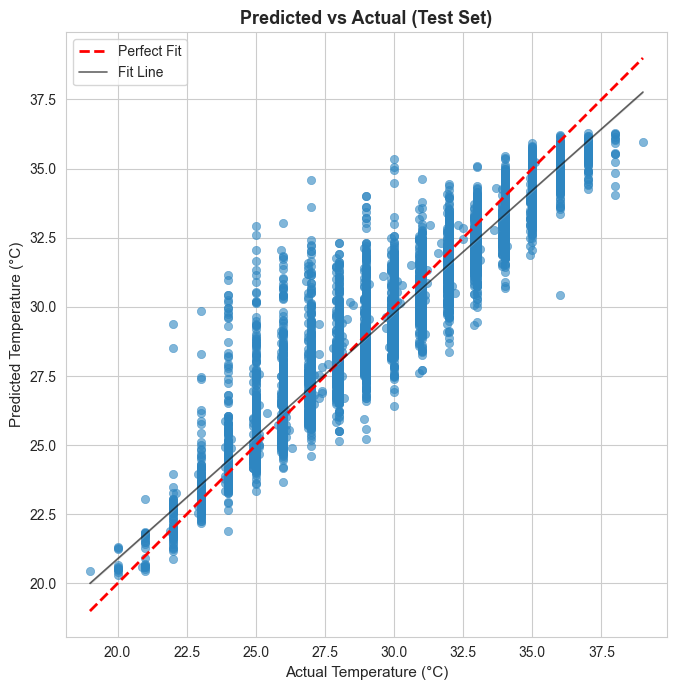

In [115]:
# ---  Retrain the best model from Optuna study ---
best_xgb_params = study_xgb.best_params

xgb_best = XGBRegressor(
    **best_xgb_params,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

xgb_best.fit(X_train_sel, y_train)

# --- Predict on test set ---
y_pred_test = xgb_best.predict(X_test_sel)

# --- Plot Predicted vs Actual ---
plt.figure(figsize=(7,7))
sns.set_style("whitegrid")

sns.scatterplot(x=y_test, y=y_pred_test, color="#2E86C1", edgecolor=None, alpha=0.6)

lims = [
    np.min([y_test.min(), y_pred_test.min()]),
    np.max([y_test.max(), y_pred_test.max()])
]
plt.plot(lims, lims, 'r--', lw=2, label="Perfect Fit")
sns.regplot(x=y_test, y=y_pred_test, scatter=False, color="black", line_kws={'lw':1.2, 'alpha':0.6}, label="Fit Line")

plt.xlabel('Actual Temperature (°C)', fontsize=11)
plt.ylabel('Predicted Temperature (°C)', fontsize=11)
plt.title('Predicted vs Actual (Test Set)', fontsize=13, fontweight='bold')
plt.legend()
plt.axis('equal')
plt.tight_layout()
plt.show()


<Figure size 800x400 with 0 Axes>

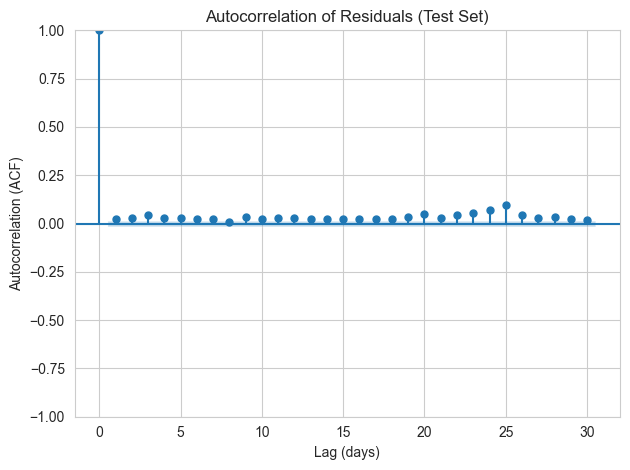

In [116]:
# ---  Residuals for test set ---
y_pred_test = xgb_best.predict(X_test_sel)
residuals = y_test - y_pred_test

# --- Autocorrelation plot ---
plt.figure(figsize=(8,4))
plot_acf(residuals, lags=30)
plt.title("Autocorrelation of Residuals (Test Set)")
plt.xlabel("Lag (days)")
plt.ylabel("Autocorrelation (ACF)")
plt.tight_layout()
plt.show()


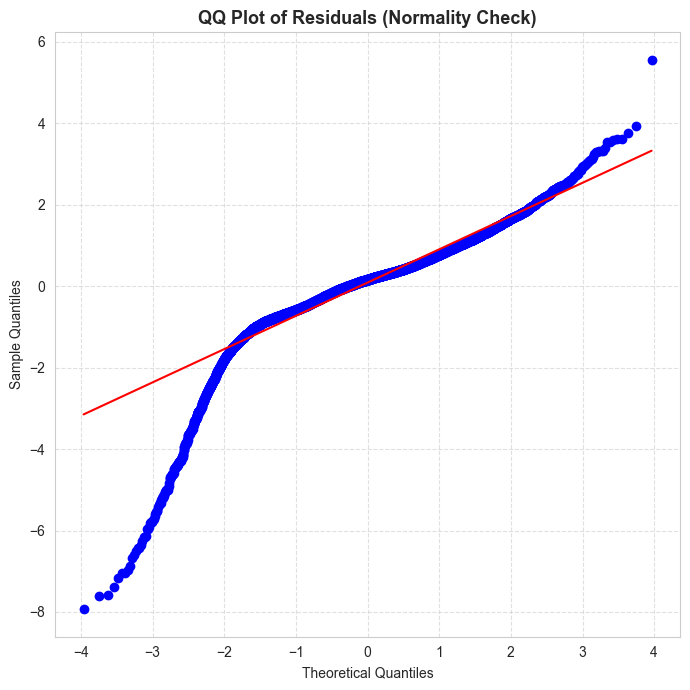

In [117]:
# ---  QQ Plot for Residuals ---
residuals = y_test - y_pred_test

plt.figure(figsize=(7,7))
sns.set_style("whitegrid")

stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals (Normality Check)", fontsize=13, fontweight='bold')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

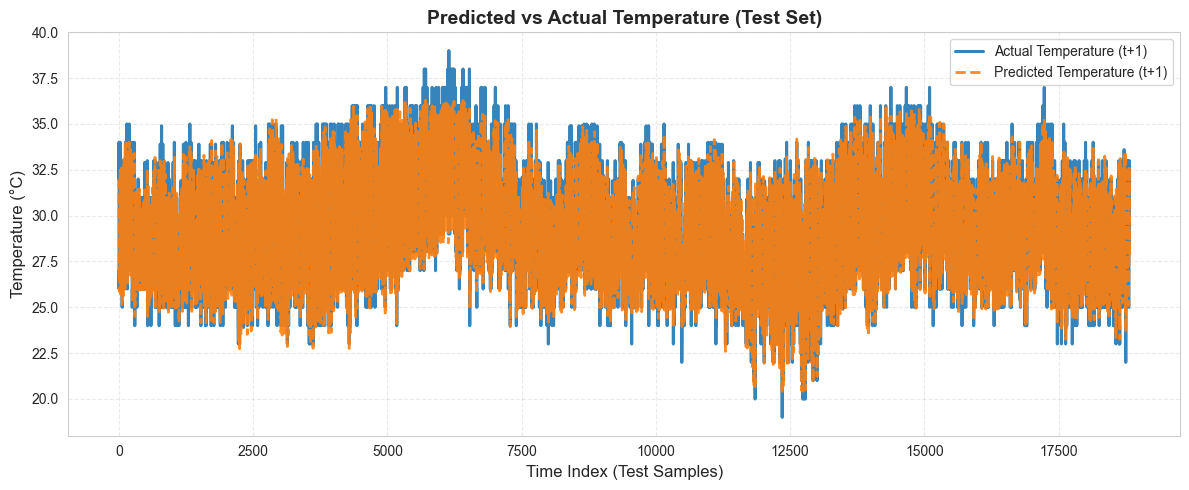

In [118]:
# ---  Predicted vs Actual Temperature (Time-Series View) ---
y_pred_test = xgb_best.predict(X_test_sel)

plt.figure(figsize=(12, 5))
sns.set_style("whitegrid")

# Plot actual vs predicted
plt.plot(
    y_test.values, 
    label='Actual Temperature (t+1)', 
    color='tab:blue', 
    linewidth=2.2, 
    alpha=0.9
)
plt.plot(
    y_pred_test, 
    '--', 
    label='Predicted Temperature (t+1)', 
    color='tab:orange', 
    linewidth=2.0, 
    alpha=0.9
)

# Highlight style
plt.title("Predicted vs Actual Temperature (Test Set)", fontsize=14, fontweight='bold')
plt.xlabel("Time Index (Test Samples)", fontsize=12)
plt.ylabel("Temperature (°C)", fontsize=12)
plt.legend(frameon=True, fontsize=10)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()